Import Libraries

In [ ]:
pip install msoffcrypto-tool

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


In [667]:
import os
import msoffcrypto
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from pmdarima import model_selection
import math
import pytz
import datetime

In [668]:
xls = pd.ExcelFile("RawData18.xlsx")
Factor_data = pd.read_excel(xls,'Factor')
Gold_data = pd.read_excel(xls,'Gold')

In [669]:
# Factor_data[['(Inflation)','PTT_แก๊สโซฮอล์_95','(Inflation)_LAG_1','(Inflation)_LAG_2','(Inflation)_LAG_3','PTT_แก๊สโซฮอล์_95_LAG_1','PTT_แก๊สโซฮอล์_95_LAG_2','PTT_แก๊สโซฮอล์_95_LAG_3']]
# Factor_data[['(Inflation)','(Inflation)_LAG_1','(Inflation)_LAG_2','(Inflation)_LAG_3','LOG_(Inflation)','LOG_(Inflation)_LAG_1','LOG_(Inflation)_LAG_2','LOG_(Inflation)_LAG_3']]
# Factor_data[['(Inflation)_LAG_1','(Inflation)_LAG_2','(Inflation)_LAG_3','%CHANGE_(Inflation)_LAG_1','%CHANGE_(Inflation)_LAG_2','%CHANGE_(Inflation)_LAG_3']]

In [670]:
factor_col = Factor_data.columns[1:]
# factor_col = Factor_data.columns[1:3]

In [671]:
factor_col

Index(['(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', 'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
       'XAU_USD', 'CPI', 'น้ำมัน brent(USD)', 'SET Index', 'Core_CPI'],
      dtype='object')

In [672]:
Factor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Report Date                             156 non-null    datetime64[ns]
 1   (Inflation)                             156 non-null    float64       
 2   PTT_แก๊สโซฮอล์_95                       156 non-null    float64       
 3   PTT_แก๊สโซฮอล์_91                       156 non-null    float64       
 4   PTT_ดีเซล                               156 non-null    float64       
 5   อัตราแลกเปลี่ยน_USD_THB                 156 non-null    float64       
 6   BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)  156 non-null    float64       
 7   SCB_ออมทรัพย์(อัตราดอกเบี้ย)            156 non-null    float64       
 8   SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)        156 non-null    float64       
 9   SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)        156 non-null  

In [673]:
Gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Report Date   162 non-null    datetime64[ns]
 1   GoldBar_Sale  162 non-null    int64         
 2   GoldBar_Buy   162 non-null    int64         
 3   GoldJew_Sale  162 non-null    int64         
 4   GoldJew_Buy   162 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 6.5 KB


LAG , LOG , LAG %CHANGE

In [674]:
for month in range(1,6):  #6
    Factor_data[[i+f'_LAG_{month}' for i in factor_col]] = Factor_data[factor_col].shift(month)

In [675]:
for month in range(0,6): #6
    Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
    Factor_data[[i+f'_LAG_{month}' if month!=0 else i for i in factor_col]].apply(np.log)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2650533508.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2650533508.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2650533508.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [676]:
# %change
for month in range(1,6): #6
    Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
    (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2781292075.py:4: RuntimeWarning: divide by zero encountered in divide
  (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2781292075.py:4: RuntimeWarning: invalid value encountered in divide
  (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2781292075.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
C:\Users\temp5\AppData\Local\

In [677]:
# Gold_data = Gold_data[Gold_data['Report Date'] >= '2021-01-31']
# Gold_data = Gold_data[Gold_data['Report Date'] <= '2023-12-31']

In [678]:
Gold_Factor_data = \
                pd.merge(
                    Gold_data,
                    Factor_data,
                    left_on = 'Report Date',
                    right_on = 'Report Date',
                    how = 'left'
                )

In [679]:
# Gold_data
Gold_Factor_data

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
0    2011-01-31         19700        19600         20100     19313.84   
1    2011-02-28         20350        20250         20750     19950.56   
2    2011-03-31         20350        20250         20750     19950.56   
3    2011-04-30         21650        21550         22050     21239.16   
4    2011-05-30         22000        21900         22400     21587.84   
..          ...           ...          ...           ...          ...   
157  2024-02-29         34550        34450         35050     33837.12   
158  2024-03-31         38550        38450         39050     37763.56   
159  2024-04-29         40950        40850         41450     40113.36   
160  2024-05-31         40800        40700         41300     39961.76   
161  2024-06-30         40500        40400         41000     39673.72   

     (Inflation)  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
0           1.32              35.14              32.64      29.99   
1           1.44              36.34              33.84      29.99   
2           1.62              37.44              34.94      29.99   
3           2.06              38.84              36.34      29.99   
4           2.49              37.54              35.04      29.99   
..           ...                ...                ...        ...   
157          NaN                NaN                NaN        NaN   
158          NaN                NaN                NaN        NaN   
159          NaN                NaN                NaN        NaN   
160          NaN                NaN                NaN        NaN   
161          NaN                NaN                NaN        NaN   

     อัตราแลกเปลี่ยน_USD_THB  ...  \
0                     30.905  ...   
1                     30.595  ...   
2                     30.255  ...   
3                     29.850  ...   
4                     30.300  ...   
..                       ...  ...   
157                      NaN  ...   
158                      NaN  ...   
159                      NaN  ...   
160                      NaN  ...   
161                      NaN  ...   

     %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5  \
0                                                  NaN      
1                                                  NaN      
2                                                  NaN      
3                                                  NaN      
4                                                  NaN      
..                                                 ...      
157                                                NaN      
158                                                NaN      
159                                                NaN      
160                                                NaN      
161                                                NaN      

     %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
..                                          ...   
157                                         NaN   
158                                         NaN   
159                                         NaN   
160                                         NaN   
161                                         NaN   

     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
..                                              ...   
157                                             NaN   
158                                             NaN   
159         

In [680]:
Gold_Factor_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
# Gold_Factor_data.replace([np.inf, -np.inf],np.nan,inplace=True)
Gold_Factor_data = Gold_Factor_data.dropna(axis='columns')

In [681]:
Gold_Factor_data.columns

Index(['Report Date', 'GoldBar_Sale', 'GoldBar_Buy', 'GoldJew_Sale',
       'GoldJew_Buy', '(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB',
       ...
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_XAU_USD_LAG_5', '%CHANGE_CPI_LAG_5',
       '%CHANGE_น้ำมัน brent(USD)_LAG_5', '%CHANGE_SET Index_LAG_5',
       '%CHANGE_Core_CPI_LAG_5'],
      dtype='object', length=260)

เอาช่วงของราคาทองคำตั้งแต่ 2021 - 2023

In [682]:
Gold_Factor_data = Gold_Factor_data[Gold_Factor_data['Report Date'] >= '2021-01-31']
Gold_Factor_data = Gold_Factor_data[Gold_Factor_data['Report Date'] <= '2023-12-31']

In [683]:
Gold_Factor_data

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
120  2021-01-31         26250        26150         26750     25681.04   
121  2021-02-28         25350        25250         25850     24801.76   
122  2021-03-31         25500        25400         26000     24938.20   
123  2021-04-30         26250        26150         26750     25681.04   
124  2021-05-31         28100        28000         28600     27500.24   
125  2021-06-30         26900        26800         27400     26317.76   
126  2021-07-31         28300        28200         28800     27697.32   
127  2021-08-30         27950        27850         28450     27348.64   
128  2021-09-30         27850        27750         28350     27257.68   
129  2021-10-31         28200        28100         28700     27591.20   
130  2021-11-29         28650        28550         29150     28030.84   
131  2021-12-31         28650        28550         29150     28030.84   
132  2022-01-31         28450        28350         28950     27833.76   
133  2022-02-28         29150        29050         29650     28531.12   
134  2022-03-31         30550        30450         31050     29895.52   
135  2022-04-30         30800        30700         31300     30153.24   
136  2022-05-30         30000        29900         30500     29364.92   
137  2022-06-30         30400        30300         30900     29759.08   
138  2022-07-31         30200        30100         30700     29562.00   
139  2022-08-31         29750        29650         30250     29122.36   
140  2022-09-30         29400        29300         29900     28773.68   
141  2022-10-31         29650        29550         30150     29016.24   
142  2022-11-30         29700        29600         30200     29061.72   
143  2022-12-31         29650        29550         30150     29016.24   
144  2023-01-30         29950        29850         30450     29319.44   
145  2023-02-27         30000        29900         30500     29364.92   
146  2023-03-31         31800        31700         32300     31123.48   
147  2023-04-30         32050        31950         32550     31381.20   
148  2023-05-31         32000        31900         32500     31320.56   
149  2023-06-30         32150        32050         32650     31472.16   
150  2023-07-31         31800        31700         32300     31123.48   
151  2023-08-31         32000        31900         32500     31320.56   
152  2023-09-30         32650        32550         33150     31957.28   
153  2023-10-30         34200        34100         34700     33488.44   
154  2023-11-30         33600        33500         34100     32897.20   
155  2023-12-31         33650        33550         34150     32942.68   

     (Inflation)  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
120         0.21              24.25              23.98      25.09   
121         0.04              26.05              25.78      26.99   
122         0.09              26.15              25.88      23.19   
123         0.30              29.05              28.78      25.99   
124         0.49              27.95              27.68      25.09   
125         0.52              28.75              28.48      25.79   
126         0.14              29.55              29.28      26.09   
127         0.07              29.25              28.98      25.79   
128         0.19              30.75              30.48      27.69   
129         0.21              32.55              32.28      29.69   
130         0.29              31.05              30.78      28.84   
131         0.29              31.15              30.88      28.44   
132         0.52              34.05              33.78      29.94   
133         1.80              36.55              36.28      29.14   
134         2.00              40.05              39.78      29.94   
135         2.00              38.85              38.58      29.94   
136         2.28              43.85              43.58      31.94   
137         2.51              44.65              44.38      

In [684]:
Gold_Factor_data['GB_S'] = (Gold_Factor_data['GoldBar_Sale'].values)
# Gold_Factor_data['LOG_GB_S'] = np.log(Gold_Factor_data['GoldBar_Sale'].values/Gold_Factor_data['GoldBar_Sale'].shift(1))
Gold_Factor_data['GB_S'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
Gold_Factor_data['GB_B'] = (Gold_Factor_data['GoldBar_Buy'].values)
# Gold_Factor_data['LOG_GB_B'] = np.log(Gold_Factor_data['GoldBar_Buy'].values/Gold_Factor_data['GoldBar_Buy'].shift(1))
Gold_Factor_data['GB_B'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
Gold_Factor_data['GJ_S'] = (Gold_Factor_data['GoldJew_Sale'].values)
# Gold_Factor_data['LOG_GJ_S'] = np.log(Gold_Factor_data['GoldJew_Sale'].values/Gold_Factor_data['GoldJew_Sale'].shift(1))
Gold_Factor_data['GJ_S'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
Gold_Factor_data['GJ_B'] = (Gold_Factor_data['GoldJew_Buy'].values)
# Gold_Factor_data['LOG_GJ_B'] = np.log(Gold_Factor_data['GoldJew_Buy'].values/Gold_Factor_data['GoldJew_Buy'].shift(1))
Gold_Factor_data['GJ_B'].replace([np.inf, -np.inf, np.nan],0,inplace=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\3076389242.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Gold_Factor_data['GB_S'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\3076389242.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [685]:
Factor_data.columns

Index(['Report Date', '(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB',
       'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)',
       ...
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_XAU_USD_LAG_5', '%CHANGE_CPI_LAG_5',
       '%CHANGE_น้ำมัน brent(USD)_LAG_5', '%CHANGE_SET Index_LAG_5',
       '%CHANGE_Core_CPI_LAG_5'],
      dtype='object', length=256)

In [686]:
Gold_Factor_data[['GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']]

GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy
120         26250        26150         26750     25681.04
121         25350        25250         25850     24801.76
122         25500        25400         26000     24938.20
123         26250        26150         26750     25681.04
124         28100        28000         28600     27500.24
125         26900        26800         27400     26317.76
126         28300        28200         28800     27697.32
127         27950        27850         28450     27348.64
128         27850        27750         28350     27257.68
129         28200        28100         28700     27591.20
130         28650        28550         29150     28030.84
131         28650        28550         29150     28030.84
132         28450        28350         28950     27833.76
133         29150        29050         29650     28531.12
134         30550        30450         31050     29895.52
135         30800        30700         31300     30153.24
136         30000        29900         30500     29364.92
137         30400        30300         30900     29759.08
138         30200        30100         30700     29562.00
139         29750        29650         30250     29122.36
140         29400        29300         29900     28773.68
141         29650        29550         30150     29016.24
142         29700        29600         30200     29061.72
143         29650        29550         30150     29016.24
144         29950        29850         30450     29319.44
145         30000        29900         30500     29364.92
146         31800        31700         32300     31123.48
147         32050        31950         32550     31381.20
148         32000        31900         32500     31320.56
149         32150        32050         32650     31472.16
150         31800        31700         32300     31123.48
151         32000        31900         32500     31320.56
152         32650        32550         33150     31957.28
153         34200        34100         34700     33488.44
154         33600        33500         34100     32897.20
155         33650        33550         34150     32942.68

In [687]:
Gold_Factor_data[['GB_S','GB_B','GJ_S','GJ_B']]

GB_S   GB_B   GJ_S      GJ_B
120  26250  26150  26750  25681.04
121  25350  25250  25850  24801.76
122  25500  25400  26000  24938.20
123  26250  26150  26750  25681.04
124  28100  28000  28600  27500.24
125  26900  26800  27400  26317.76
126  28300  28200  28800  27697.32
127  27950  27850  28450  27348.64
128  27850  27750  28350  27257.68
129  28200  28100  28700  27591.20
130  28650  28550  29150  28030.84
131  28650  28550  29150  28030.84
132  28450  28350  28950  27833.76
133  29150  29050  29650  28531.12
134  30550  30450  31050  29895.52
135  30800  30700  31300  30153.24
136  30000  29900  30500  29364.92
137  30400  30300  30900  29759.08
138  30200  30100  30700  29562.00
139  29750  29650  30250  29122.36
140  29400  29300  29900  28773.68
141  29650  29550  30150  29016.24
142  29700  29600  30200  29061.72
143  29650  29550  30150  29016.24
144  29950  29850  30450  29319.44
145  30000  29900  30500  29364.92
146  31800  31700  32300  31123.48
147  32050  31950  32550  31381.20
148  32000  31900  32500  31320.56
149  32150  32050  32650  31472.16
150  31800  31700  32300  31123.48
151  32000  31900  32500  31320.56
152  32650  32550  33150  31957.28
153  34200  34100  34700  33488.44
154  33600  33500  34100  32897.20
155  33650  33550  34150  32942.68

In [688]:
Gold_Factor_data.to_excel("LAG_RESULT.xlsx")

เลือกตัวแปรที่สนใจ และเกี่ยวข้องกับทองคำ

In [689]:
LOG_GOLD = ['GB_S','GB_B','GJ_S','GJ_B']
GOLD_N = ['GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']

In [690]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
main_Factor_list = factor_col
# Factor_list = Gold_Factor_data.drop(columns = ['GoldBar_Sale'] ).columns
# Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','LOGIT']).columns
Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy'
                                               ,'GB_S','GB_B','GJ_S','GJ_B']).columns
All_result_table_GB_S = pd.DataFrame()
# All_result_table_best_GB_S = pd.DataFrame()
All_result_table_GB_B = pd.DataFrame()
# All_result_table_best_GB_B = pd.DataFrame()
All_result_table_GJ_S = pd.DataFrame()
# All_result_table_best_GJ_S = pd.DataFrame()
All_result_table_GJ_B = pd.DataFrame()
# All_result_table_best_GJ_B = pd.DataFrame()
for lg_g in LOG_GOLD: 
    for ix , temp_factor_group in enumerate(main_Factor_list,1):
        Factor_group = [i for i in Factor_list if temp_factor_group in i]
        r2_list = []
        print(lg_g)
        # print(ix , " " , temp_factor_group , " " , Factor_group)
        # print('---------------------------------------------')
        temp_result_table = pd.DataFrame()
        for temp_factor in Factor_group:
            X_train = np.array(Gold_Factor_data[temp_factor].values , dtype=float)
            y_train = np.array(Gold_Factor_data[lg_g].values , dtype=float)
            # y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
            # print(temp_factor)
            print('X_train -> ',X_train , X_train.shape)
            # print('y_train -> ',y_train , y_train.shape)
            X_train_1 = X_train.reshape(-1,1)
            y_train_1 = y_train.reshape(-1,1)
            # print('X_train_1',X_train_1 , X_train_1.shape)
            # print('y_train_1',y_train_1 , y_train_1.shape)
            # test stationary test 10%

            adf = adfuller(X_train)[1]
            adf_result = 'PASS' if adfuller(X_train)[1] <= 0.1 else 'FAIL'
            # print('adf -> ' ,adf)
            # print('adf result ->',adf_result)
            #Regression
            linear_model = LinearRegression()
            linear_model.fit(X_train_1 , y_train_1)

            X_train = sm.add_constant(X_train)
            # print('add constant Xtrain',X_train)
            reg = sm.OLS(y_train , X_train).fit()
            sign = '+' if linear_model.coef_ > 0 else '-'

            r2_list.append((temp_factor,reg.rsquared,sign,adf,adf_result))
            # print(r2_list)

        temp_result_table['Factor'] = np.array(r2_list)[:,0]
        temp_result_table['r2'] = np.array(r2_list)[:,1]
        temp_result_table['sign'] = np.array(r2_list)[:,2]
        temp_result_table['adf'] = np.array(r2_list)[:,3]
        temp_result_table['adf_result'] = np.array(r2_list)[:,4]

        if ix == 1:
            if lg_g == 'GB_S':
                All_result_table_GB_S = temp_result_table
            elif lg_g == 'GB_B':
                All_result_table_GB_B = temp_result_table
            elif lg_g == 'GJ_S':
                All_result_table_GJ_S = temp_result_table
            elif lg_g == 'GJ_B':
                All_result_table_GJ_B = temp_result_table
        else:
            if lg_g == 'GB_S':
                All_result_table_GB_S = pd.concat([All_result_table_GB_S,temp_result_table], ignore_index = True)
            elif lg_g == 'GB_B':
                All_result_table_GB_B = pd.concat([All_result_table_GB_B,temp_result_table], ignore_index = True)
            elif lg_g == 'GJ_S':
                All_result_table_GJ_S = pd.concat([All_result_table_GJ_S,temp_result_table], ignore_index = True)
            elif lg_g == 'GJ_B':
                All_result_table_GJ_B = pd.concat([All_result_table_GJ_B,temp_result_table], ignore_index = True)


GB_S
X_train ->  [0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29 0.29 0.52 1.8
 2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04 1.93 1.75 1.66
 1.55 1.32 0.86 0.79 0.63 0.66 0.58 0.58] (36,)
X_train ->  [0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29 0.29 0.52
 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04 1.93 1.75
 1.66 1.55 1.32 0.86 0.79 0.63 0.66 0.58] (36,)
X_train ->  [0.18 0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29 0.29
 0.52 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04 1.93
 1.75 1.66 1.55 1.32 0.86 0.79 0.63 0.66] (36,)
X_train ->  [0.19 0.18 0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29
 0.29 0.52 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04
 1.93 1.75 1.66 1.55 1.32 0.86 0.79 0.63] (36,)
X_train ->  [0.25 0.19 0.18 0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21
 0.29 0.29 0.52 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23
 3.04 1.93 1.75 1.66 1.55 1.32 0.8

In [691]:
# adf = adfuller(Gold_Factor_data['GoldBar_Sale'].values)[1]
# adf_result = 'PASS' if adfuller(Gold_Factor_data['GoldBar_Sale'].values)[1] <= 0.05 else 'FAIL'
# adf_result
# All_result_table_GB_S

In [696]:
# Goldbar_sale
All_result_table_GB_S[All_result_table_GB_S['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

Factor sign adf_result
0                                          (Inflation)    +       PASS
3                                    (Inflation)_LAG_3    +       PASS
4                                    (Inflation)_LAG_4    +       PASS
6                                      LOG_(Inflation)    +       PASS
7                                LOG_(Inflation)_LAG_1    +       PASS
8                                LOG_(Inflation)_LAG_2    +       PASS
9                                LOG_(Inflation)_LAG_3    +       PASS
10                               LOG_(Inflation)_LAG_4    +       PASS
24                         LOG_PTT_แก๊สโซฮอล์_95_LAG_1    +       PASS
29                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_1    -       PASS
30                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_2    -       PASS
31                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_3    -       PASS
41                         LOG_PTT_แก๊สโซฮอล์_91_LAG_1    +       PASS
46                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_1    -       PASS
47                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_2    -       PASS
63                             %CHANGE_PTT_ดีเซล_LAG_1    -       PASS
65                             %CHANGE_PTT_ดีเซล_LAG_3    -       PASS
80               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1    -       PASS
81               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2    -       PASS
82               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3    -       PASS
83               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4    -       PASS
97   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
98   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
114         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_1    +       PASS
115         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_2    +       PASS
116         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_3    +       PASS
131     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
132     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
133     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
148     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
149     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
165    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
166    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
167    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
182                              %CHANGE_XAU_USD_LAG_1    +       PASS
183                              %CHANGE_XAU_USD_LAG_2    +       PASS
187                                                CPI    +       PASS
199                                            LOG_CPI    +       PASS
212                             %CHANGE_Core_CPI_LAG_1    -       PASS
214                             %CHANGE_Core_CPI_LAG_2    +       PASS
216                             %CHANGE_Core_CPI_LAG_3    +       PASS
218                             %CHANGE_Core_CPI_LAG_4    +       PASS
220                             %CHANGE_Core_CPI_LAG_5    +       PASS
228                        LOG_น้ำมัน brent(USD)_LAG_1    +       PASS
229                        LOG_น้ำมัน brent(USD)_LAG_2    +       PASS
230                        LOG_น้ำมัน brent(USD)_LAG_3    +       PASS
231                        LOG_น้ำมัน brent(USD)_LAG_4    +       PASS
233                    %CHANGE_น้ำมัน brent(USD)_LAG_1    -       PASS
234                    %CHANGE_น้ำมัน brent(USD)_LAG_2    -       PASS
237                    %CHANGE_น้ำมัน brent(USD)_LAG_5    -       PASS
241                                    SET Index_LAG_3    +       PASS
247                                LOG_SET Index_LAG_3    +       PASS
267                             %CHANGE_Core_CPI_LAG_1    -       PASS
268                             %CHANGE_Core_CPI_LAG_2    +       PASS
269                             %CHANGE_Core_CPI_LAG_3    +       PASS
270                             %CHANGE_Core_CPI_LAG_4    +       PASS
2

In [697]:
# Goldbar_buy
All_result_table_GB_B[All_result_table_GB_B['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

Factor sign adf_result
0                                          (Inflation)    +       PASS
3                                    (Inflation)_LAG_3    +       PASS
4                                    (Inflation)_LAG_4    +       PASS
6                                      LOG_(Inflation)    +       PASS
7                                LOG_(Inflation)_LAG_1    +       PASS
8                                LOG_(Inflation)_LAG_2    +       PASS
9                                LOG_(Inflation)_LAG_3    +       PASS
10                               LOG_(Inflation)_LAG_4    +       PASS
24                         LOG_PTT_แก๊สโซฮอล์_95_LAG_1    +       PASS
29                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_1    -       PASS
30                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_2    -       PASS
31                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_3    -       PASS
41                         LOG_PTT_แก๊สโซฮอล์_91_LAG_1    +       PASS
46                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_1    -       PASS
47                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_2    -       PASS
63                             %CHANGE_PTT_ดีเซล_LAG_1    -       PASS
65                             %CHANGE_PTT_ดีเซล_LAG_3    -       PASS
80               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1    -       PASS
81               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2    -       PASS
82               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3    -       PASS
83               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4    -       PASS
97   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
98   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
114         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_1    +       PASS
115         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_2    +       PASS
116         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_3    +       PASS
131     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
132     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
133     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
148     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
149     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
165    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
166    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
167    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
182                              %CHANGE_XAU_USD_LAG_1    +       PASS
183                              %CHANGE_XAU_USD_LAG_2    +       PASS
187                                                CPI    +       PASS
199                                            LOG_CPI    +       PASS
212                             %CHANGE_Core_CPI_LAG_1    -       PASS
214                             %CHANGE_Core_CPI_LAG_2    +       PASS
216                             %CHANGE_Core_CPI_LAG_3    +       PASS
218                             %CHANGE_Core_CPI_LAG_4    +       PASS
220                             %CHANGE_Core_CPI_LAG_5    +       PASS
228                        LOG_น้ำมัน brent(USD)_LAG_1    +       PASS
229                        LOG_น้ำมัน brent(USD)_LAG_2    +       PASS
230                        LOG_น้ำมัน brent(USD)_LAG_3    +       PASS
231                        LOG_น้ำมัน brent(USD)_LAG_4    +       PASS
233                    %CHANGE_น้ำมัน brent(USD)_LAG_1    -       PASS
234                    %CHANGE_น้ำมัน brent(USD)_LAG_2    -       PASS
237                    %CHANGE_น้ำมัน brent(USD)_LAG_5    -       PASS
241                                    SET Index_LAG_3    +       PASS
247                                LOG_SET Index_LAG_3    +       PASS
267                             %CHANGE_Core_CPI_LAG_1    -       PASS
268                             %CHANGE_Core_CPI_LAG_2    +       PASS
269                             %CHANGE_Core_CPI_LAG_3    +       PASS
270                             %CHANGE_Core_CPI_LAG_4    +       PASS
2

In [698]:
# Goldjew_sale
All_result_table_GJ_S[All_result_table_GJ_S['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

Factor sign adf_result
0                                          (Inflation)    +       PASS
3                                    (Inflation)_LAG_3    +       PASS
4                                    (Inflation)_LAG_4    +       PASS
6                                      LOG_(Inflation)    +       PASS
7                                LOG_(Inflation)_LAG_1    +       PASS
8                                LOG_(Inflation)_LAG_2    +       PASS
9                                LOG_(Inflation)_LAG_3    +       PASS
10                               LOG_(Inflation)_LAG_4    +       PASS
24                         LOG_PTT_แก๊สโซฮอล์_95_LAG_1    +       PASS
29                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_1    -       PASS
30                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_2    -       PASS
31                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_3    -       PASS
41                         LOG_PTT_แก๊สโซฮอล์_91_LAG_1    +       PASS
46                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_1    -       PASS
47                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_2    -       PASS
63                             %CHANGE_PTT_ดีเซล_LAG_1    -       PASS
65                             %CHANGE_PTT_ดีเซล_LAG_3    -       PASS
80               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1    -       PASS
81               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2    -       PASS
82               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3    -       PASS
83               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4    -       PASS
97   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
98   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
114         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_1    +       PASS
115         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_2    +       PASS
116         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_3    +       PASS
131     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
132     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
133     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
148     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
149     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
165    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
166    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
167    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
182                              %CHANGE_XAU_USD_LAG_1    +       PASS
183                              %CHANGE_XAU_USD_LAG_2    +       PASS
187                                                CPI    +       PASS
199                                            LOG_CPI    +       PASS
212                             %CHANGE_Core_CPI_LAG_1    -       PASS
214                             %CHANGE_Core_CPI_LAG_2    +       PASS
216                             %CHANGE_Core_CPI_LAG_3    +       PASS
218                             %CHANGE_Core_CPI_LAG_4    +       PASS
220                             %CHANGE_Core_CPI_LAG_5    +       PASS
228                        LOG_น้ำมัน brent(USD)_LAG_1    +       PASS
229                        LOG_น้ำมัน brent(USD)_LAG_2    +       PASS
230                        LOG_น้ำมัน brent(USD)_LAG_3    +       PASS
231                        LOG_น้ำมัน brent(USD)_LAG_4    +       PASS
233                    %CHANGE_น้ำมัน brent(USD)_LAG_1    -       PASS
234                    %CHANGE_น้ำมัน brent(USD)_LAG_2    -       PASS
237                    %CHANGE_น้ำมัน brent(USD)_LAG_5    -       PASS
241                                    SET Index_LAG_3    +       PASS
247                                LOG_SET Index_LAG_3    +       PASS
267                             %CHANGE_Core_CPI_LAG_1    -       PASS
268                             %CHANGE_Core_CPI_LAG_2    +       PASS
269                             %CHANGE_Core_CPI_LAG_3    +       PASS
270                             %CHANGE_Core_CPI_LAG_4    +       PASS
2

In [699]:
# Goldjew_buy
All_result_table_GJ_B[All_result_table_GJ_B['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

Factor sign adf_result
0                                          (Inflation)    +       PASS
3                                    (Inflation)_LAG_3    +       PASS
4                                    (Inflation)_LAG_4    +       PASS
6                                      LOG_(Inflation)    +       PASS
7                                LOG_(Inflation)_LAG_1    +       PASS
8                                LOG_(Inflation)_LAG_2    +       PASS
9                                LOG_(Inflation)_LAG_3    +       PASS
10                               LOG_(Inflation)_LAG_4    +       PASS
24                         LOG_PTT_แก๊สโซฮอล์_95_LAG_1    +       PASS
29                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_1    -       PASS
30                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_2    -       PASS
31                     %CHANGE_PTT_แก๊สโซฮอล์_95_LAG_3    -       PASS
41                         LOG_PTT_แก๊สโซฮอล์_91_LAG_1    +       PASS
46                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_1    -       PASS
47                     %CHANGE_PTT_แก๊สโซฮอล์_91_LAG_2    -       PASS
63                             %CHANGE_PTT_ดีเซล_LAG_1    -       PASS
65                             %CHANGE_PTT_ดีเซล_LAG_3    -       PASS
80               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1    -       PASS
81               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2    -       PASS
82               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3    -       PASS
83               %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4    -       PASS
97   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
98   %CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)...    +       PASS
114         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_1    +       PASS
115         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_2    +       PASS
116         %CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_3    +       PASS
131     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
132     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
133     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
148     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
149     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
165    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_1    +       PASS
166    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_2    +       PASS
167    %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_3    +       PASS
182                              %CHANGE_XAU_USD_LAG_1    +       PASS
183                              %CHANGE_XAU_USD_LAG_2    +       PASS
187                                                CPI    +       PASS
199                                            LOG_CPI    +       PASS
212                             %CHANGE_Core_CPI_LAG_1    -       PASS
214                             %CHANGE_Core_CPI_LAG_2    +       PASS
216                             %CHANGE_Core_CPI_LAG_3    +       PASS
218                             %CHANGE_Core_CPI_LAG_4    +       PASS
220                             %CHANGE_Core_CPI_LAG_5    +       PASS
228                        LOG_น้ำมัน brent(USD)_LAG_1    +       PASS
229                        LOG_น้ำมัน brent(USD)_LAG_2    +       PASS
230                        LOG_น้ำมัน brent(USD)_LAG_3    +       PASS
231                        LOG_น้ำมัน brent(USD)_LAG_4    +       PASS
233                    %CHANGE_น้ำมัน brent(USD)_LAG_1    -       PASS
234                    %CHANGE_น้ำมัน brent(USD)_LAG_2    -       PASS
237                    %CHANGE_น้ำมัน brent(USD)_LAG_5    -       PASS
241                                    SET Index_LAG_3    +       PASS
247                                LOG_SET Index_LAG_3    +       PASS
267                             %CHANGE_Core_CPI_LAG_1    -       PASS
268                             %CHANGE_Core_CPI_LAG_2    +       PASS
269                             %CHANGE_Core_CPI_LAG_3    +       PASS
270                             %CHANGE_Core_CPI_LAG_4    +       PASS
2

In [700]:
Pass_Factor_list_GB_S = All_result_table_GB_S[All_result_table_GB_S['adf_result'] == 'PASS']
Pass_Factor_list_GB_B = All_result_table_GB_B[All_result_table_GB_B['adf_result'] == 'PASS']
Pass_Factor_list_GJ_S = All_result_table_GJ_S[All_result_table_GJ_S['adf_result'] == 'PASS']
Pass_Factor_list_GJ_B = All_result_table_GJ_B[All_result_table_GJ_B['adf_result'] == 'PASS']

In [703]:
Sign_Check = pd.DataFrame({
    "No" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "Factor" : ['(Inflation)','PTT_แก๊สโซฮอล์_95','PTT_แก๊สโซฮอล์_91'
                ,'PTT_ดีเซล','อัตราแลกเปลี่ยน_USD_THB','BOT_Policy_rate_(อัตราดอกเบี้ยนโยบาย)'
                ,'SCB_ออมทรัพย์(อัตราดอกเบี้ย)','SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)'
                ,'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)','SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
               'XAU_USD','CPI','น้ำมัน brent(USD)','SET Index','Core_CPI'],
    'Sign':['+','+','+','+','-','+','+','+','+','+','+','+','+','+','+']
})
Sign_Check

No                                 Factor Sign
0    1                            (Inflation)    +
1    2                      PTT_แก๊สโซฮอล์_95    +
2    3                      PTT_แก๊สโซฮอล์_91    +
3    4                              PTT_ดีเซล    +
4    5                อัตราแลกเปลี่ยน_USD_THB    -
5    6  BOT_Policy_rate_(อัตราดอกเบี้ยนโยบาย)    +
6    7           SCB_ออมทรัพย์(อัตราดอกเบี้ย)    +
7    8       SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)    +
8    9       SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)    +
9   10      SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)    +
10  11                                XAU_USD    +
11  12                                    CPI    +
12  13                      น้ำมัน brent(USD)    +
13  14                              SET Index    +
14  15                               Core_CPI    +

In [705]:
Pass_Factor_list_GB_S.to_excel("ADF_RESULT_PASS_GB_S_10 logv3.xlsx")
Pass_Factor_list_GB_B.to_excel("ADF_RESULT_PASS_GB_B_10 logv3.xlsx")
Pass_Factor_list_GJ_S.to_excel("ADF_RESULT_PASS_GJ_S_10 logv3.xlsx")
Pass_Factor_list_GJ_B.to_excel("ADF_RESULT_PASS_GJ_B_10 logv3.xlsx")

In [706]:
Pass_Factor_list_GB_S = Pass_Factor_list_GB_S[((Pass_Factor_list_GB_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GB_S['sign']== '-'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_S['sign'] =='+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SET Index', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('Core_CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))].reset_index(drop=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\656966558.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Pass_Factor_list_GB_S = Pass_Factor_list_GB_S[((Pass_Factor_list_GB_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\656966558.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GB_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_S['sign'] =='+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\656966558.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=Fals

In [707]:
Pass_Factor_list_GB_B = Pass_Factor_list_GB_B[((Pass_Factor_list_GB_B['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GB_B['sign']== '-'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_B['sign'] =='+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
                        | ((Pass_Factor_list_GB_B['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))].reset_index(drop=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\776788584.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Pass_Factor_list_GB_B = Pass_Factor_list_GB_B[((Pass_Factor_list_GB_B['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\776788584.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GB_B['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_B['sign'] =='+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\776788584.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=Fals

In [708]:
Pass_Factor_list_GJ_B = Pass_Factor_list_GJ_B[((Pass_Factor_list_GJ_B['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+')) 
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+')) 
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+')) 
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GJ_B['sign']== '-'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GJ_B['sign'] =='+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_B['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))].reset_index(drop=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2089641210.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Pass_Factor_list_GJ_B = Pass_Factor_list_GJ_B[((Pass_Factor_list_GJ_B['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2089641210.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GJ_B['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GJ_B['sign'] =='+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\2089641210.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=F

In [709]:
Pass_Factor_list_GJ_S = Pass_Factor_list_GJ_S[((Pass_Factor_list_GJ_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GJ_S['sign']== '-'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GJ_S['sign'] =='+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
                        | ((Pass_Factor_list_GJ_S['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))].reset_index(drop=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\3134441856.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Pass_Factor_list_GJ_S = Pass_Factor_list_GJ_S[((Pass_Factor_list_GJ_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\3134441856.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GJ_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GJ_S['sign'] =='+'))
C:\Users\temp5\AppData\Local\Temp\ipykernel_11512\3134441856.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=F

In [710]:
Pass_Factor_list_GB_S = Pass_Factor_list_GB_S['Factor']
Pass_Factor_list_GB_B = Pass_Factor_list_GB_B['Factor']
Pass_Factor_list_GJ_S = Pass_Factor_list_GJ_S['Factor']
Pass_Factor_list_GJ_B = Pass_Factor_list_GJ_B['Factor']

In [711]:
# Pass_Factor_list_GJ_B
# Pass_Factor_list_GJ_S
# Pass_Factor_list_GB_B
Pass_Factor_list_GB_S
Pass_Factor_list_GB_S.count()

28

Overall Model Performance

In [713]:
from itertools import combinations
# comb_list = [i for i in combinations(Pass_Factor_list , 3)] + [i for i in combinations(Pass_Factor_list, 2)]
# test_1 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3']
# comb_list = [i for i in combinations(test_1, 3)]
comb_list_GB_S = [i for i in combinations(Pass_Factor_list_GB_S, 3)]
comb_list_GB_B = [i for i in combinations(Pass_Factor_list_GB_B, 3)]
comb_list_GJ_S = [i for i in combinations(Pass_Factor_list_GJ_S, 3)]
comb_list_GJ_B = [i for i in combinations(Pass_Factor_list_GJ_B, 3)]
# comb_list = [i for i in combinations(Pass_Stat_list['FACTOR_1'], 2)]
len(comb_list_GB_S)
# 2 fac
#5000 = 2 min
#2346 = 50 sec
#30856 = 14 min
#4186 = 1.34 min/sec
#9453 = 3.32 min/sec
#17020 = 6.52 min/sec # 7.45.39 min/sec/msec
# 1 fac
#185 = 12ms
# new 3 fac
# 11480 = 5 min
# 2925 =1 min 10s
# new 4 fac
# 17550 = 9 mins
# new 3 fac
# new 3 fac add %change
# 27720 = 12min
# 64824 = 51 min 39 sec
# 3 fac for 4 type gold all
# 5984*4 ->23936= 9 min 28 sec
# 7140*4 ->28560  = 11 min 44 sec
# 58905*4 -> =  1d 5h
# 816 ->
# 3276

3276

In [714]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import anderson as AD
from statsmodels.stats.outliers_influence import variance_inflation_factor

all_stats_results_GB_S = pd.DataFrame()
all_stats_results_GB_B = pd.DataFrame()
all_stats_results_GJ_S = pd.DataFrame()
all_stats_results_GJ_B = pd.DataFrame()

# y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
for lg_g in LOG_GOLD:
    y_train = np.array(Gold_Factor_data[lg_g].values , dtype=float)
    if lg_g == 'GB_S':
        comb_list = comb_list_GB_S
    elif lg_g == 'GB_B':
        comb_list = comb_list_GB_B
    elif lg_g == 'GJ_S':
        comb_list = comb_list_GJ_S
    elif lg_g == 'GJ_B':
        comb_list = comb_list_GJ_B

    for out_index , comb in enumerate(comb_list,1):
        selected_Factor = list(comb)
        X_train = np.array(Gold_Factor_data[selected_Factor].values , dtype = float)

        linear_model = LinearRegression()
        linear_model.fit(X_train , y_train)

        X_train = sm.add_constant(X_train)
        reg = sm.OLS(y_train , X_train).fit()

        X_train = X_train[:,1:]
        y_pred = linear_model.predict(X_train)

        stats_results = pd.DataFrame()
        stats_results[[f'FACTOR_{i+1}' for i in range(len(selected_Factor))]] = np.array([selected_Factor])

        coeff_result = reg.summary2().tables[1].iloc[:,:1].transpose().reset_index(drop=True)
        for i in ['const','x1','x2','x3']:
            if i in coeff_result.columns:
                stats_results[i] = coeff_result[i]
            else:
                stats_results[i] = None
        # P-Value
        stats_results[['intercept_p_value'] + [f'FACTOR_{i+1}_p_value' for i in range(len(selected_Factor))]] = reg.pvalues
        # ADJ Rsq
        r2 = r2_score(y_train,y_pred)
        n , p = X_train.shape
        adj_r2 = 1 - (( 1 - r2 ) * (n - 1) / (n - p - 1))
        stats_results['r2'] = r2
        stats_results['adj_r2'] = adj_r2
        # F stats
        stats_results['Probability of F-Stats'] = reg.summary2().tables[0][3].astype(float)[5]
        # Anderson Darling
        stats_results['AD'] = AD(reg.resid , dist='norm')[0]
        stats_results['AD_criteria'] = [{i:j for i , j in zip(AD( reg.resid , dist='norm')[2],
                                                             AD( reg.resid , dist='norm')[1]
                                                             )}]
        stats_results['AD_criteria_0.05'] = AD( reg.resid , dist='norm')[1][2:3]
        # Breusch-Pagan
        name_stats = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
        test = sm.stats.het_breuschpagan(reg.resid , reg.model.exog )
        stats_results['BP_pvalues'] = lzip(name_stats , test )[1][1]
        # Durbin Watson
        stats_results['Durbin_Watson'] = sm.stats.durbin_watson(reg.resid)
        # VIF
        VIF_values = [variance_inflation_factor(Gold_Factor_data[selected_Factor].values , i) for i in range(len(selected_Factor))]

        for in_index , i in enumerate(selected_Factor , 0 ):
            stats_results[f'VIF_Factor_{in_index+1}'] = VIF_values[in_index]
        if out_index == 1:
            if lg_g == 'GB_S':
                all_stats_results_GB_S = stats_results
            elif lg_g == 'GB_B':
                all_stats_results_GB_B = stats_results
            elif lg_g == 'GJ_S':
                all_stats_results_GJ_S = stats_results
            elif lg_g == 'GJ_B':
                all_stats_results_GJ_B = stats_results
        else:
            if lg_g == 'GB_S':
                all_stats_results_GB_S = pd.concat([all_stats_results_GB_S, stats_results], axis = 0).reset_index(drop=True)
            elif lg_g == 'GB_B':
                all_stats_results_GB_B = pd.concat([all_stats_results_GB_B, stats_results], axis = 0).reset_index(drop=True)
            elif lg_g == 'GJ_S':
                all_stats_results_GJ_S = pd.concat([all_stats_results_GJ_S, stats_results], axis = 0).reset_index(drop=True)
            elif lg_g == 'GJ_B':
                all_stats_results_GJ_B = pd.concat([all_stats_results_GJ_B, stats_results], axis = 0).reset_index(drop=True)
all_stats_results_GB_S = all_stats_results_GB_S.sort_values('adj_r2', ascending = False)
all_stats_results_GB_B = all_stats_results_GB_B.sort_values('adj_r2', ascending = False)
all_stats_results_GJ_S = all_stats_results_GJ_S.sort_values('adj_r2', ascending = False)
all_stats_results_GJ_B = all_stats_results_GJ_B.sort_values('adj_r2', ascending = False)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Us

In [715]:
# comb_list = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3']
# len(Pass_Factor_list_GB_S)

In [716]:
# reg.summary()

In [728]:
reg.resid
# stats_results['AD']
# stats_results['AD_criteria_0.05']
# stats_results['AD_criteria']
all_stats_results_GB_S.to_excel("CheckStats.xlsx")

In [721]:
#Adj Stats in factor to interesting # GB_S
Pass_Stat_list_GB_S = all_stats_results_GB_S[all_stats_results_GB_S['r2'] >= 0.5]
Pass_Stat_list_GB_S = all_stats_results_GB_S[all_stats_results_GB_S['adj_r2'] >= 0.5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['Probability of F-Stats'] <= 0.5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['AD'] < Pass_Stat_list_GB_S['AD_criteria_0.05']]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['BP_pvalues'] > 0.05]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['Durbin_Watson'] >= 1]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_1'] <= 5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_2'] <= 5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_3'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
Pass_Stat_list_GB_S[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

FACTOR_1                               FACTOR_2  \
40        (Inflation)                      (Inflation)_LAG_4   
39        (Inflation)                      (Inflation)_LAG_4   
150       (Inflation)                  LOG_(Inflation)_LAG_4   
149       (Inflation)                  LOG_(Inflation)_LAG_4   
296       (Inflation)                                LOG_CPI   
302       (Inflation)                                LOG_CPI   
292       (Inflation)                                    CPI   
286       (Inflation)                                    CPI   
262       (Inflation)                  %CHANGE_XAU_USD_LAG_1   
249       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
204       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
261       (Inflation)                  %CHANGE_XAU_USD_LAG_1   
248       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
203       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
235       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
220       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
234       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
219       (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
141       (Inflation)                  LOG_(Inflation)_LAG_4   
31        (Inflation)                      (Inflation)_LAG_4   
1050  LOG_(Inflation)                  LOG_(Inflation)_LAG_4   
32        (Inflation)                      (Inflation)_LAG_4   
53        (Inflation)                        LOG_(Inflation)   

                         FACTOR_3          const           x1            x2  \
40                        LOG_CPI -396927.786498 -1038.131383   -447.667550   
39                            CPI  -61723.434764 -1029.685556   -471.206741   
150                       LOG_CPI -416556.823035 -1115.254673   -432.270105   
149                           CPI  -66775.024204 -1110.396824   -456.699012   
296        %CHANGE_Core_CPI_LAG_2 -355001.638338 -1266.020048  83055.865016   
302        %CHANGE_Core_CPI_LAG_2 -355001.638338 -1266.020048  83055.865016   
292        %CHANGE_Core_CPI_LAG_2  -52392.259039 -1268.447823    798.906439   
286        %CHANGE_Core_CPI_LAG_2  -52392.259039 -1268.447823    798.906439   
262                       LOG_CPI -352444.301691 -1167.090813   3157.020566   
249                       LOG_CPI -357366.859666 -1172.310415   3112.972265   
204                       LOG_CPI -352922.707394 -1177.519357  -4815.816946   
261                           CPI  -51859.716731 -1164.049982   3293.570083   
248                           CPI  -52946.827652 -1169.037042   3157.741635   
203                           CPI  -51900.980326 -1174.167648  -4853.632245   
235                       LOG_CPI -355180.775916 -1166.828891   1114.183785   
220                       LOG_CPI -354785.671326 -1169.953777    273.538556   
234                           CPI  -52429.856938 -1163.372943   1112.807119   
219                           CPI  -52329.078766 -1166.521891    259.298861   
141   LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -11679.350239 -1090.829305    745.399823   
31    LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -17946.204275 -1221.291567    794.202564   
1050                          CPI  -86538.474197  -997.415714   -860.900586   
32    LOG_PTT_แก๊สโซฮอล์_91_LAG_1  -17078.561650 -1224.920582    797.114301   
53          LOG_(Inflation)_LAG_3   34648.716244 -2879.397180   2483.705829   

                x3        r2    adj_r2        AD  AD_criteria_0.05  \
40    92140.963689  0.869350  0.857102  0.653515             0.721   
39      891.301974  0.868454  0.856122  0.662704             0.721   
150   96223.456478  0.866304  0.853770  0.620144             0.721   
149     933.070844  0.865139  0.852496  0.629610             0.721   
296   48155.657763  0.863587  0.850798  0.368805             0.721   
302   48155.657763  0.863587  0.850798  0.368805             0.721   
292   50452.773502  0.862159  0.849237  0.359339             0.721   
286   50452.773502 

In [722]:
#Adj Stats in factor to interesting # GB_B
Pass_Stat_list_GB_B = all_stats_results_GB_B[all_stats_results_GB_B['r2'] >= 0.5]
Pass_Stat_list_GB_B = all_stats_results_GB_B[all_stats_results_GB_B['adj_r2'] >= 0.5]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['Probability of F-Stats'] <= 0.5]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['AD'] < Pass_Stat_list_GB_B['AD_criteria_0.05']]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['BP_pvalues'] > 0.05]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['Durbin_Watson'] >= 1]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['VIF_Factor_1'] <= 5]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['VIF_Factor_2'] <= 5]
Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['VIF_Factor_3'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
Pass_Stat_list_GB_B[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

FACTOR_1                               FACTOR_2  \
38       (Inflation)                      (Inflation)_LAG_4   
37       (Inflation)                      (Inflation)_LAG_4   
138      (Inflation)                  LOG_(Inflation)_LAG_4   
137      (Inflation)                  LOG_(Inflation)_LAG_4   
264      (Inflation)                                LOG_CPI   
268      (Inflation)                                LOG_CPI   
260      (Inflation)                                    CPI   
256      (Inflation)                                    CPI   
236      (Inflation)                  %CHANGE_XAU_USD_LAG_1   
225      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
186      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
235      (Inflation)                  %CHANGE_XAU_USD_LAG_1   
224      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
185      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
213      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
200      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
212      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
199      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
129      (Inflation)                  LOG_(Inflation)_LAG_4   
29       (Inflation)                      (Inflation)_LAG_4   
897  LOG_(Inflation)                  LOG_(Inflation)_LAG_4   
30       (Inflation)                      (Inflation)_LAG_4   
49       (Inflation)                        LOG_(Inflation)   

                        FACTOR_3          const           x1            x2  \
38                       LOG_CPI -397027.786498 -1038.131383   -447.667550   
37                           CPI  -61823.434764 -1029.685556   -471.206741   
138                      LOG_CPI -416656.823035 -1115.254673   -432.270105   
137                          CPI  -66875.024204 -1110.396824   -456.699012   
264       %CHANGE_Core_CPI_LAG_2 -355101.638338 -1266.020048  83055.865016   
268       %CHANGE_Core_CPI_LAG_2 -355101.638338 -1266.020048  83055.865016   
260       %CHANGE_Core_CPI_LAG_2  -52492.259039 -1268.447823    798.906439   
256       %CHANGE_Core_CPI_LAG_2  -52492.259039 -1268.447823    798.906439   
236                      LOG_CPI -352544.301691 -1167.090813   3157.020566   
225                      LOG_CPI -357466.859666 -1172.310415   3112.972265   
186                      LOG_CPI -353022.707394 -1177.519357  -4815.816946   
235                          CPI  -51959.716731 -1164.049982   3293.570083   
224                          CPI  -53046.827652 -1169.037042   3157.741635   
185                          CPI  -52000.980326 -1174.167648  -4853.632245   
213                      LOG_CPI -355280.775916 -1166.828891   1114.183785   
200                      LOG_CPI -354885.671326 -1169.953777    273.538556   
212                          CPI  -52529.856938 -1163.372943   1112.807119   
199                          CPI  -52429.078766 -1166.521891    259.298861   
129  LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -11779.350239 -1090.829305    745.399823   
29   LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -18046.204275 -1221.291567    794.202564   
897                          CPI  -86638.474197  -997.415714   -860.900586   
30   LOG_PTT_แก๊สโซฮอล์_91_LAG_1  -17178.561650 -1224.920582    797.114301   
49         LOG_(Inflation)_LAG_3   34548.716244 -2879.397180   2483.705829   

               x3        r2    adj_r2        AD  AD_criteria_0.05  BP_pvalues  \
38   92140.963689  0.869350  0.857102  0.653515             0.721    0.126314   
37     891.301974  0.868454  0.856122  0.662704             0.721    0.136247   
138  96223.456478  0.866304  0.853770  0.620144             0.721    0.188508   
137    933.070844  0.865139  0.852496  0.629610             0.721    0.199911   
264  48155.657763  0.863587  0.850798  0.368805             0.721    0.127835   
268  48155.657763  0.863587  0.850798  0.368805             0.721    0.127835   
260  50452.773502  0.862159  0.849237  0.359339            

In [723]:
#Adj Stats in factor to interesting # GJ_S
Pass_Stat_list_GJ_S = all_stats_results_GJ_S[all_stats_results_GJ_S['r2'] >= 0.5]
Pass_Stat_list_GJ_S = all_stats_results_GJ_S[all_stats_results_GJ_S['adj_r2'] >= 0.5]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['Probability of F-Stats'] <= 0.5]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['AD'] < Pass_Stat_list_GJ_S['AD_criteria_0.05']]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['BP_pvalues'] > 0.05]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['Durbin_Watson'] >= 1]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['VIF_Factor_1'] <= 5]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['VIF_Factor_2'] <= 5]
Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['VIF_Factor_3'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
Pass_Stat_list_GJ_S[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

FACTOR_1                               FACTOR_2  \
38       (Inflation)                      (Inflation)_LAG_4   
37       (Inflation)                      (Inflation)_LAG_4   
138      (Inflation)                  LOG_(Inflation)_LAG_4   
137      (Inflation)                  LOG_(Inflation)_LAG_4   
264      (Inflation)                                LOG_CPI   
268      (Inflation)                                LOG_CPI   
260      (Inflation)                                    CPI   
256      (Inflation)                                    CPI   
236      (Inflation)                  %CHANGE_XAU_USD_LAG_1   
225      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
186      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
235      (Inflation)                  %CHANGE_XAU_USD_LAG_1   
224      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
185      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
213      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
200      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
212      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
199      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
129      (Inflation)                  LOG_(Inflation)_LAG_4   
29       (Inflation)                      (Inflation)_LAG_4   
897  LOG_(Inflation)                  LOG_(Inflation)_LAG_4   
30       (Inflation)                      (Inflation)_LAG_4   
49       (Inflation)                        LOG_(Inflation)   

                        FACTOR_3          const           x1            x2  \
38                       LOG_CPI -396427.786498 -1038.131383   -447.667550   
37                           CPI  -61223.434764 -1029.685556   -471.206741   
138                      LOG_CPI -416056.823035 -1115.254673   -432.270105   
137                          CPI  -66275.024204 -1110.396824   -456.699012   
264       %CHANGE_Core_CPI_LAG_2 -354501.638338 -1266.020048  83055.865016   
268       %CHANGE_Core_CPI_LAG_2 -354501.638338 -1266.020048  83055.865016   
260       %CHANGE_Core_CPI_LAG_2  -51892.259039 -1268.447823    798.906439   
256       %CHANGE_Core_CPI_LAG_2  -51892.259039 -1268.447823    798.906439   
236                      LOG_CPI -351944.301691 -1167.090813   3157.020566   
225                      LOG_CPI -356866.859666 -1172.310415   3112.972265   
186                      LOG_CPI -352422.707394 -1177.519357  -4815.816946   
235                          CPI  -51359.716731 -1164.049982   3293.570083   
224                          CPI  -52446.827652 -1169.037042   3157.741635   
185                          CPI  -51400.980326 -1174.167648  -4853.632245   
213                      LOG_CPI -354680.775916 -1166.828891   1114.183785   
200                      LOG_CPI -354285.671326 -1169.953777    273.538556   
212                          CPI  -51929.856938 -1163.372943   1112.807119   
199                          CPI  -51829.078766 -1166.521891    259.298861   
129  LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -11179.350239 -1090.829305    745.399823   
29   LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -17446.204275 -1221.291567    794.202564   
897                          CPI  -86038.474197  -997.415714   -860.900586   
30   LOG_PTT_แก๊สโซฮอล์_91_LAG_1  -16578.561650 -1224.920582    797.114301   
49         LOG_(Inflation)_LAG_3   35148.716244 -2879.397180   2483.705829   

               x3        r2    adj_r2        AD  AD_criteria_0.05  BP_pvalues  \
38   92140.963689  0.869350  0.857102  0.653515             0.721    0.126314   
37     891.301974  0.868454  0.856122  0.662704             0.721    0.136247   
138  96223.456478  0.866304  0.853770  0.620144             0.721    0.188508   
137    933.070844  0.865139  0.852496  0.629610             0.721    0.199911   
264  48155.657763  0.863587  0.850798  0.368805             0.721    0.127835   
268  48155.657763  0.863587  0.850798  0.368805             0.721    0.127835   
260  50452.773502  0.862159  0.849237  0.359339            

In [724]:
#Adj Stats in factor to interesting # GJ_B
Pass_Stat_list_GJ_B = all_stats_results_GJ_B[all_stats_results_GJ_B['r2'] >= 0.5]
Pass_Stat_list_GJ_B = all_stats_results_GJ_B[all_stats_results_GJ_B['adj_r2'] >= 0.5]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['Probability of F-Stats'] <= 0.5]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['AD'] < Pass_Stat_list_GJ_B['AD_criteria_0.05']]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['BP_pvalues'] > 0.05]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['Durbin_Watson'] >= 1]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['VIF_Factor_1'] <= 5]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['VIF_Factor_2'] <= 5]
Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['VIF_Factor_3'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
Pass_Stat_list_GJ_B[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

FACTOR_1                               FACTOR_2  \
38       (Inflation)                      (Inflation)_LAG_4   
37       (Inflation)                      (Inflation)_LAG_4   
138      (Inflation)                  LOG_(Inflation)_LAG_4   
137      (Inflation)                  LOG_(Inflation)_LAG_4   
264      (Inflation)                                LOG_CPI   
268      (Inflation)                                LOG_CPI   
256      (Inflation)                                    CPI   
260      (Inflation)                                    CPI   
236      (Inflation)                  %CHANGE_XAU_USD_LAG_1   
225      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
186      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
235      (Inflation)                  %CHANGE_XAU_USD_LAG_1   
224      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   
185      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1   
213      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
200      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
212      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3   
199      (Inflation)  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   
129      (Inflation)                  LOG_(Inflation)_LAG_4   
29       (Inflation)                      (Inflation)_LAG_4   
897  LOG_(Inflation)                  LOG_(Inflation)_LAG_4   
30       (Inflation)                      (Inflation)_LAG_4   
49       (Inflation)                        LOG_(Inflation)   

                        FACTOR_3          const           x1            x2  \
38                       LOG_CPI -389582.125628 -1017.366869   -439.687495   
37                           CPI  -60648.037713 -1009.083750   -462.796090   
138                      LOG_CPI -408718.826823 -1093.242549   -423.570587   
137                          CPI  -65577.589402 -1088.479168   -447.542371   
264       %CHANGE_Core_CPI_LAG_2 -348402.800121 -1241.059151  81494.260227   
268       %CHANGE_Core_CPI_LAG_2 -348402.800121 -1241.059151  81494.260227   
256       %CHANGE_Core_CPI_LAG_2  -51483.278070 -1243.446337    783.887844   
260       %CHANGE_Core_CPI_LAG_2  -51483.278070 -1243.446337    783.887844   
236                      LOG_CPI -345895.322196 -1144.033458   3095.319512   
225                      LOG_CPI -350727.419525 -1149.154687   3058.626369   
186                      LOG_CPI -346374.131222 -1154.218051  -4693.899268   
235                          CPI  -50961.097621 -1141.054969   3229.295407   
224                          CPI  -52028.332566 -1145.948655   3102.566961   
185                          CPI  -51003.800244 -1150.934549  -4730.991510   
213                      LOG_CPI -348589.266120 -1143.704640   1113.878890   
200                      LOG_CPI -348199.777994 -1146.809201    282.162921   
212                          CPI  -51522.785285 -1140.319248   1112.536559   
199                          CPI  -51423.344927 -1143.447312    268.205785   
129  LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -11550.774991 -1069.607514    731.404136   
29   LOG_PTT_แก๊สโซฮอล์_95_LAG_1  -17701.321435 -1197.355449    778.870223   
897                          CPI  -84943.394895  -977.524906   -843.728284   
30   LOG_PTT_แก๊สโซฮอล์_91_LAG_1  -16849.913316 -1200.922508    781.726638   
49         LOG_(Inflation)_LAG_3   33921.841165 -2824.354510   2436.752999   

               x3        r2    adj_r2        AD  AD_criteria_0.05  BP_pvalues  \
38   90417.545436  0.869026  0.856748  0.655794             0.721    0.124340   
37     874.636372  0.868139  0.855777  0.665208             0.721    0.133999   
138  94396.764677  0.865908  0.853337  0.618738             0.721    0.185558   
137    915.360963  0.864747  0.852067  0.627078             0.721    0.196656   
264  47229.603635  0.863221  0.850398  0.368154             0.721    0.127001   
268  47229.603635  0.863221  0.850398  0.368154             0.721    0.127001   
256  49483.546614  0.861800  0.848844  0.358577            

In [643]:
Pass_Stat_list_GB_S.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Sale signv6.xlsx',index=False)
Pass_Stat_list_GB_B.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Buy signv6.xlsx',index=False)
Pass_Stat_list_GJ_S.to_excel('Pass_Stat_list 3 factor Pass GoldJew_Sale signv6.xlsx',index=False)
Pass_Stat_list_GJ_B.to_excel('Pass_Stat_list 3 factor Pass GoldJew_Buy signv6.xlsx',index=False)
# Pass_Stat_list.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Sales v2.xlsx')

In [236]:
# !wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [237]:
# comb_list_GB_S

<Axes: >

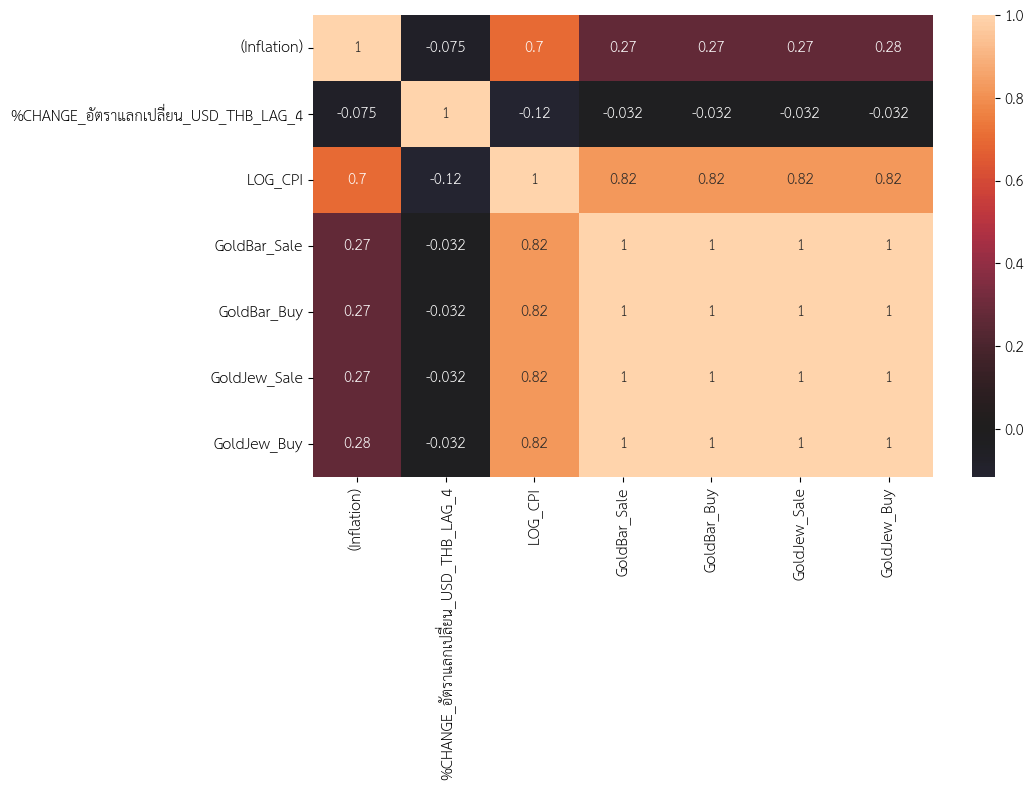

In [644]:
import seaborn as sns
import matplotlib.font_manager as fm

# ตั้งค่าฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['font.size'] = 16
Correlation_Gold = pd.DataFrame()
Correlation_Gold = Gold_Factor_data.drop(columns = ['Report Date'])
# plt.figure(figsize=(8, 6))
# sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3','LOG_GB_S','LOG_GB_B','LOG_GJ_S','LOG_GJ_B']].corr(),annot=True,center=0)
# sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)
sns.heatmap(Correlation_Gold[['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)
# plt.title('Correlation Matrix')
# plt.show()

<Axes: >

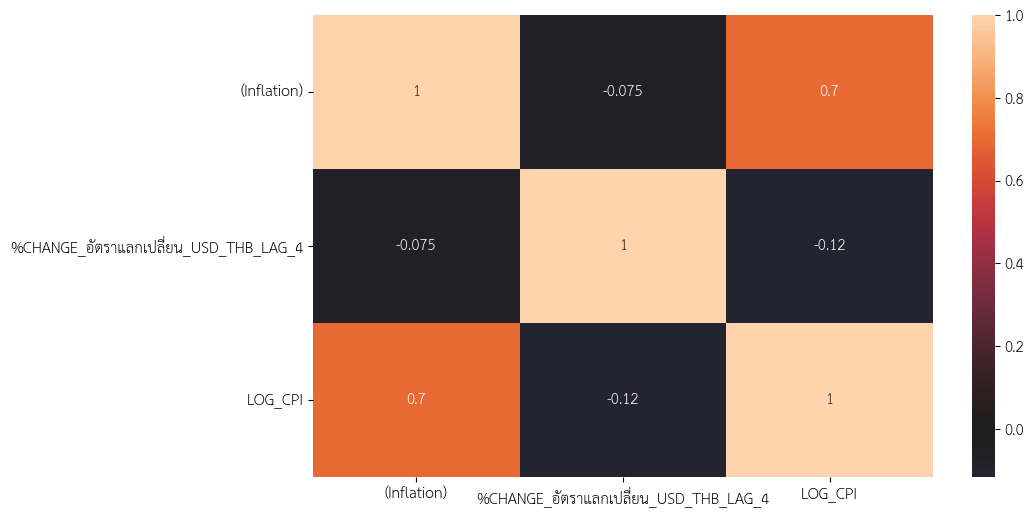

In [645]:
sns.heatmap(Correlation_Gold[['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']].corr(),annot=True,center=0)

<Axes: >

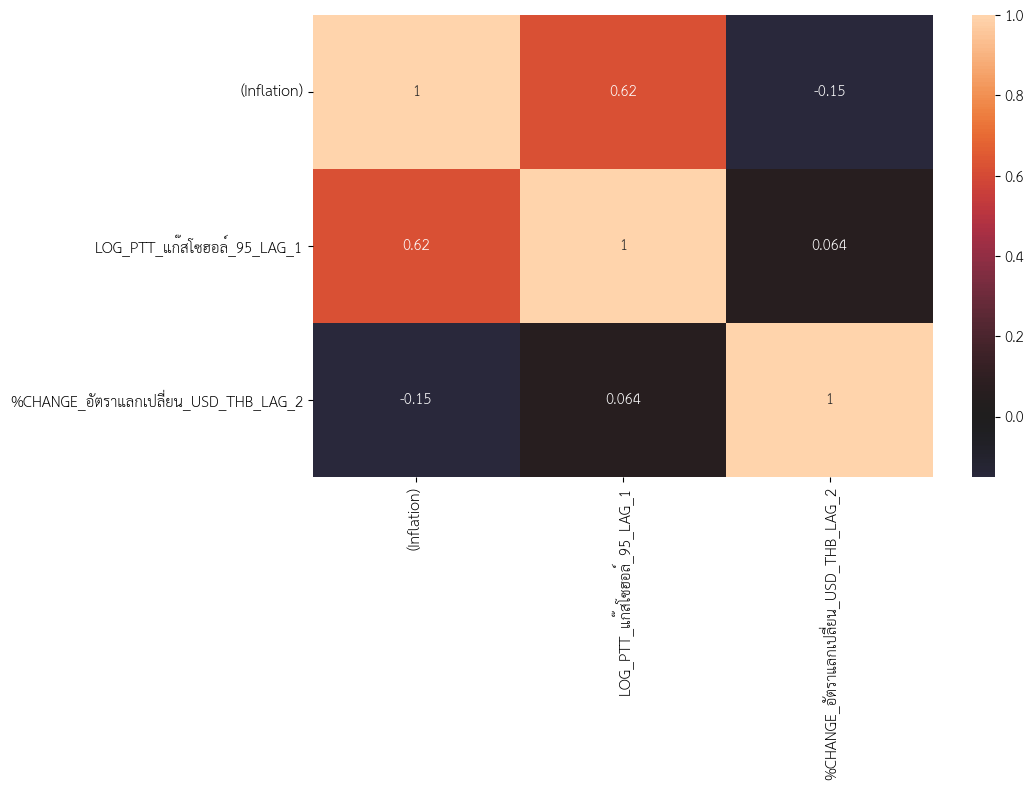

In [646]:
sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']].corr(),annot=True,center=0)

<Axes: >

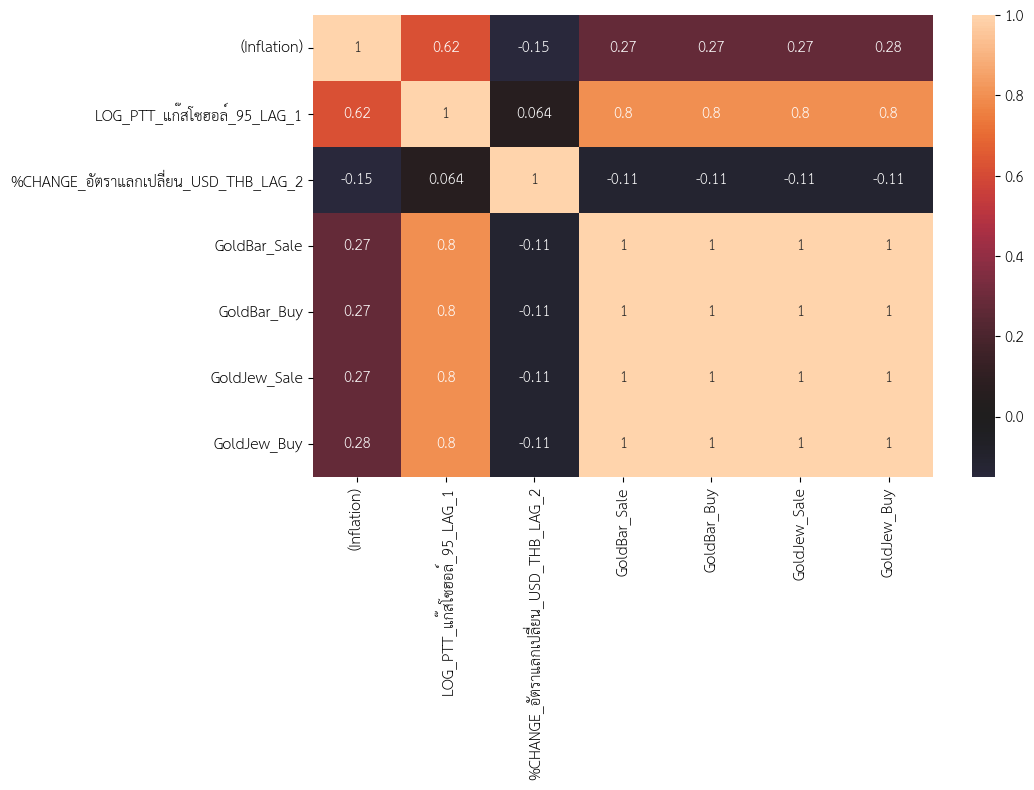

In [647]:
sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)


# ตัวแปรที่สนใจ

In [648]:
# ตัวแปรที่สนใจ
Factor_interested = ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
Factor_interested_2 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']

In [649]:
Gold_Factor_data[['GoldBar_Sale']].count()

GoldBar_Sale    36
dtype: int64

ราคาขายทองคำแท่ง

In [652]:
from sklearn.linear_model import LinearRegression
X_gb_s = Gold_Factor_data[Factor_interested_2]
y_gb_s = ((Gold_Factor_data[['GoldBar_Sale']]))
lrm_gb_s = LinearRegression()
lrm_gb_s.fit(X_gb_s,y_gb_s)
print('intercept , b : ',lrm_gb_s.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gb_s.coef_) # a
r2_gb_s = lrm_gb_s.score(X_gb_s,y_gb_s)
predict_GB_S = lrm_gb_s.predict(X_gb_s)
GB_S = pd.DataFrame()
GB_S['Report Date'] =Gold_Factor_data['Report Date']
GB_S['Predict'] = (predict_GB_S)
X_gb_s = sm.add_constant(X_gb_s)
reg_gb_s = sm.OLS(y_gb_s,X_gb_s).fit()
reg_gb_s.summary()

intercept , b :  [-23359.73311817]
coef x1,x2,x3 :  [[  -874.76630646  15470.45469667 -14936.33342116]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GoldBar_Sale   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     37.44
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.40e-10
Time:                        15:52:56   Log-Likelihood:                -301.53
No. Observations:                  36   AIC:                             611.1
Df Residuals:                      32   BIC:                             617.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                 -2.336e+04   5236.741     -4.461      0.000    -3.4e+04   -1.27e+04
(Inflation)                            -874.7663    219.005     -3.994      0.000   -1320.865    -428.668
LOG_PTT_แก๊สโซฮอล์_95_LAG_1            1.547e+04   1541.926     10.033      0.000    1.23e+04    1.86e+04
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -1.494e+04   5179.947     -2.883      0.007   -2.55e+04   -4385.127
==============================================================================
Omnibus:                        1.258   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.213
Skew:                           0.331   Prob(JB):                        0.545
Kurtosis:                       2.392   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
reg_gb_s.f_pvalue

1.7199121776921931e-13

In [54]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested], i) for i in range(len(Factor_interested))]
vif

Variable       VIF
0                            (Inflation)  2.486349
1  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4  1.132820
2                                LOG_CPI  2.673618

('Lagrange multiplier statistic', 3.351959014532929)
('p-value', 0.34047614238676516)
('f-value', 1.0951416504367557)
('f p-value', 0.3653741397711133)


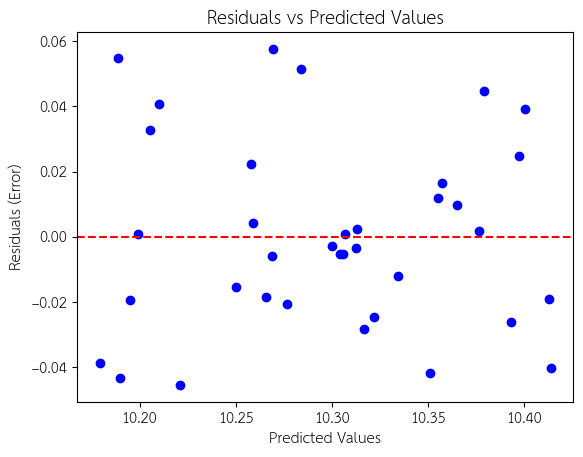

In [55]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gb_s.resid, X_gb_s)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gb_s.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

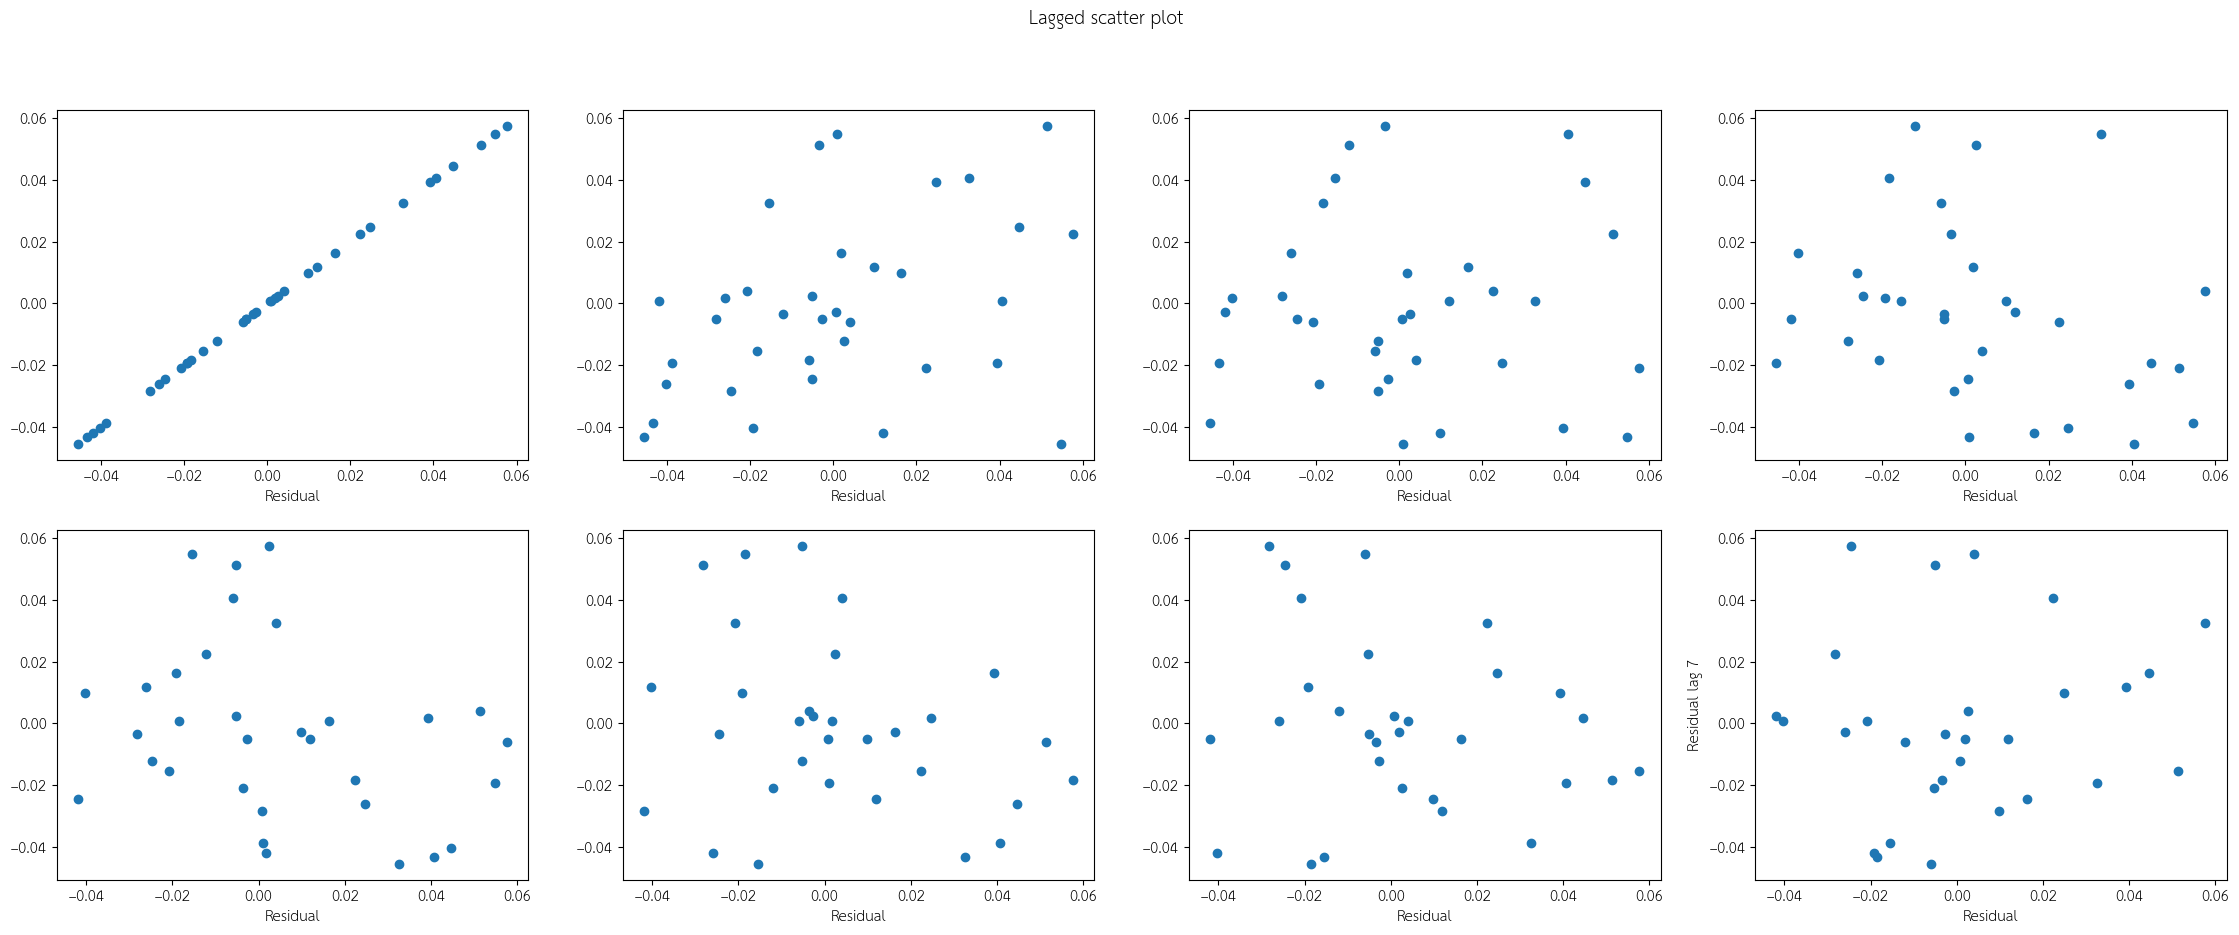

In [56]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gb_s.resid,
                y = reg_gb_s.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

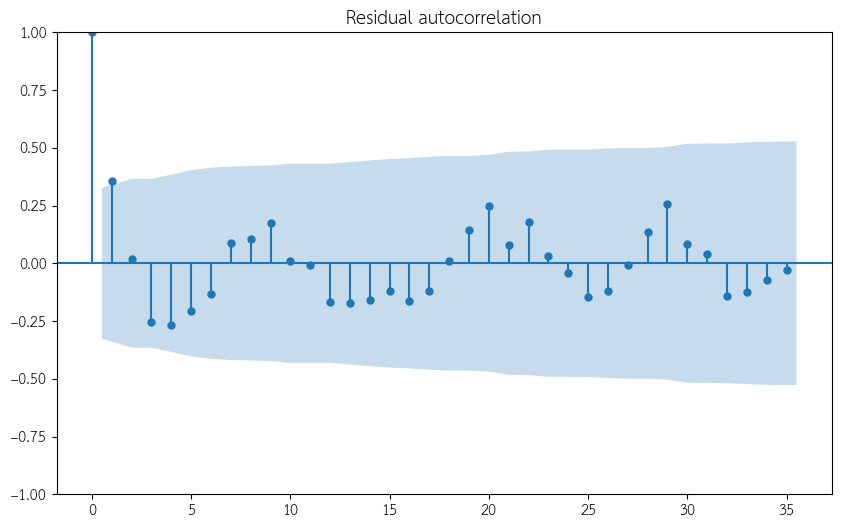

Durbin-Watson :  1.2107869675164178


In [57]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gb_s.resid, lags = reg_gb_s.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gb_s.resid))


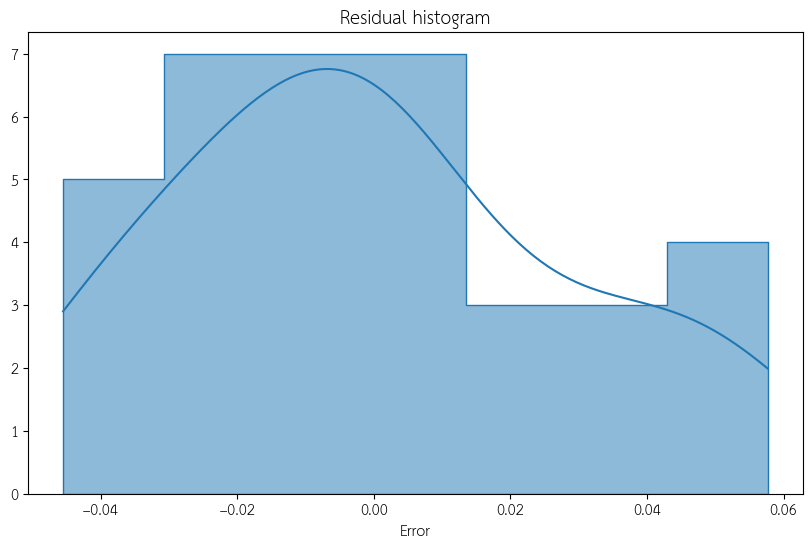

In [58]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gb_s.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

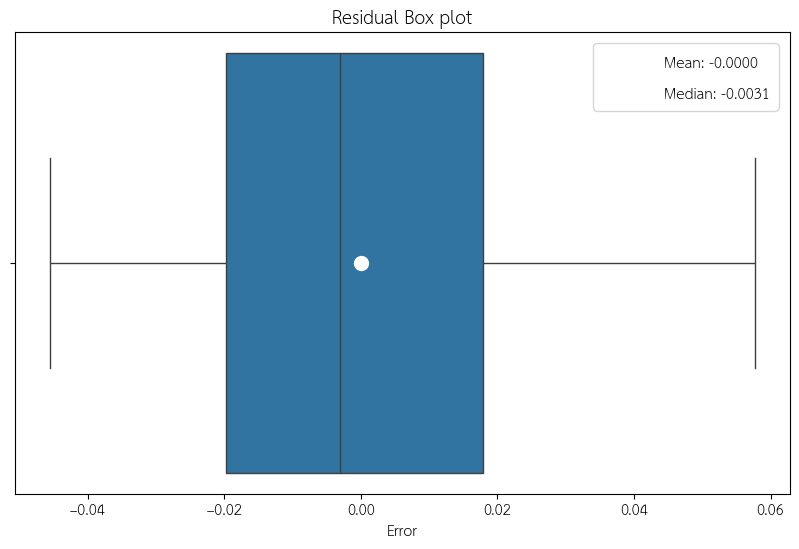

In [59]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gb_s.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gb_s.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gb_s.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

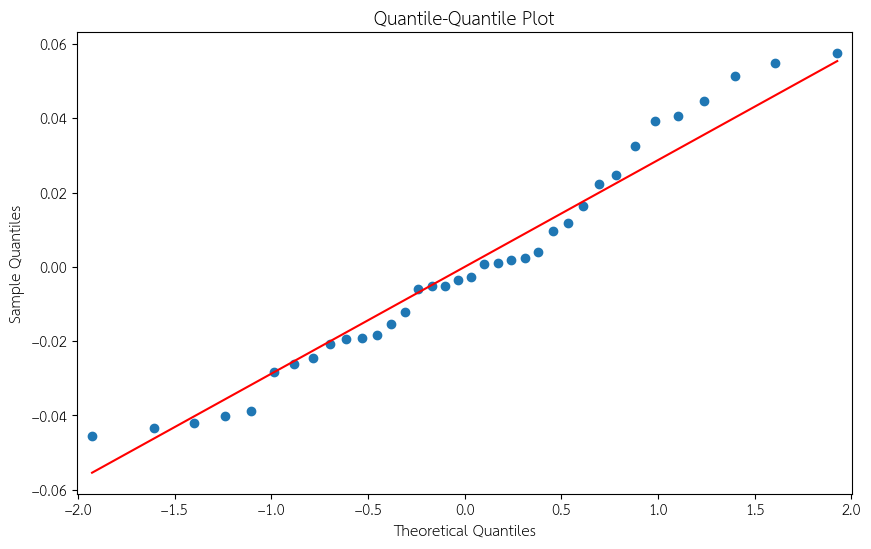

In [60]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gb_s.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [61]:
#Anderson darling for normality
ad = AD(reg_gb_s.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gb_s.resid, dist='norm')[2], AD(reg_gb_s.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gb_s.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.43596000405347013
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


ราคาซื้อทองคำแท่ง

In [62]:
from sklearn.linear_model import LinearRegression
X_gb_b = Gold_Factor_data[Factor_interested]
y_gb_b = np.log(Gold_Factor_data[['GoldBar_Buy']])
lrm_gb_b = LinearRegression()
lrm_gb_b.fit(X_gb_b,y_gb_b)
print('intercept , b : ',lrm_gb_b.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gb_b.coef_) # a
r2_gb_b = lrm_gb_b.score(X_gb_b,y_gb_b)
predict_GB_B = lrm_gb_b.predict(X_gb_b)
GB_B = pd.DataFrame()
GB_B['Report Date'] =Gold_Factor_data['Report Date']
GB_B['Predict'] = (predict_GB_B)
X_gb_b = sm.add_constant(X_gb_b)
reg_gb_b = sm.OLS(y_gb_b,X_gb_b).fit()
reg_gb_b.summary()

intercept , b :  [-2.70845983]
coef x1,x2,x3 :  [[-0.03740789  0.11181963  2.80541584]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GoldBar_Buy   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     62.67
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.72e-13
Time:                        08:33:20   Log-Likelihood:                 76.539
No. Observations:                  36   AIC:                            -145.1
Df Residuals:                      32   BIC:                            -138.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.7085      1.001     -2.706      0.011      -4.747      -0.670
(Inflation)                              -0.0374      0.006     -5.846      0.000      -0.050      -0.024
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4     0.1118      0.105      1.068      0.293      -0.101       0.325
LOG_CPI                                   2.8054      0.216     12.966      0.000       2.365       3.246
==============================================================================
Omnibus:                        1.940   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.379   Jarque-Bera (JB):                1.608
Skew:                           0.366   Prob(JB):                        0.448
Kurtosis:                       2.268   Cond. No.                         994.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested], i) for i in range(len(Factor_interested))]
vif

Variable       VIF
0                            (Inflation)  2.486349
1  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4  1.132820
2                                LOG_CPI  2.673618

('Lagrange multiplier statistic', 3.357712950080978)
('p-value', 0.3396905136247293)
('f-value', 1.0972149330741405)
('f p-value', 0.3645429525756876)


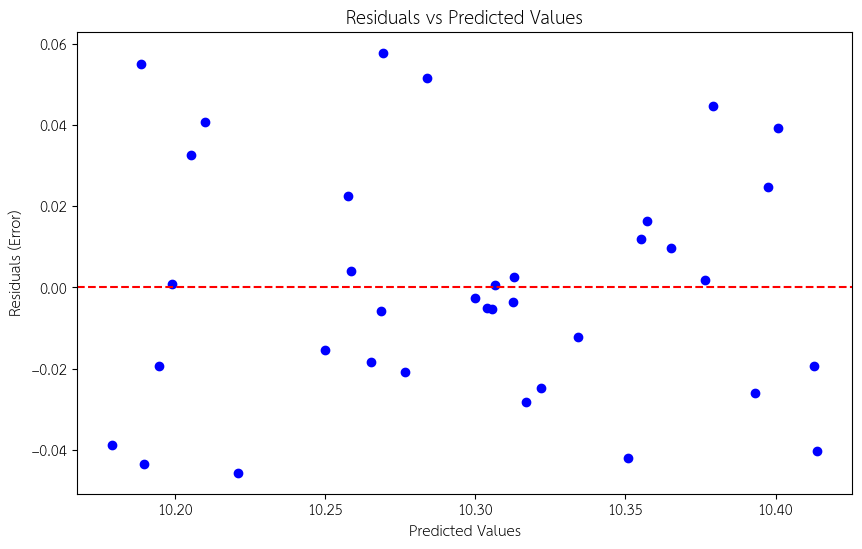

In [64]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gb_b.resid, X_gb_b)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gb_b.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

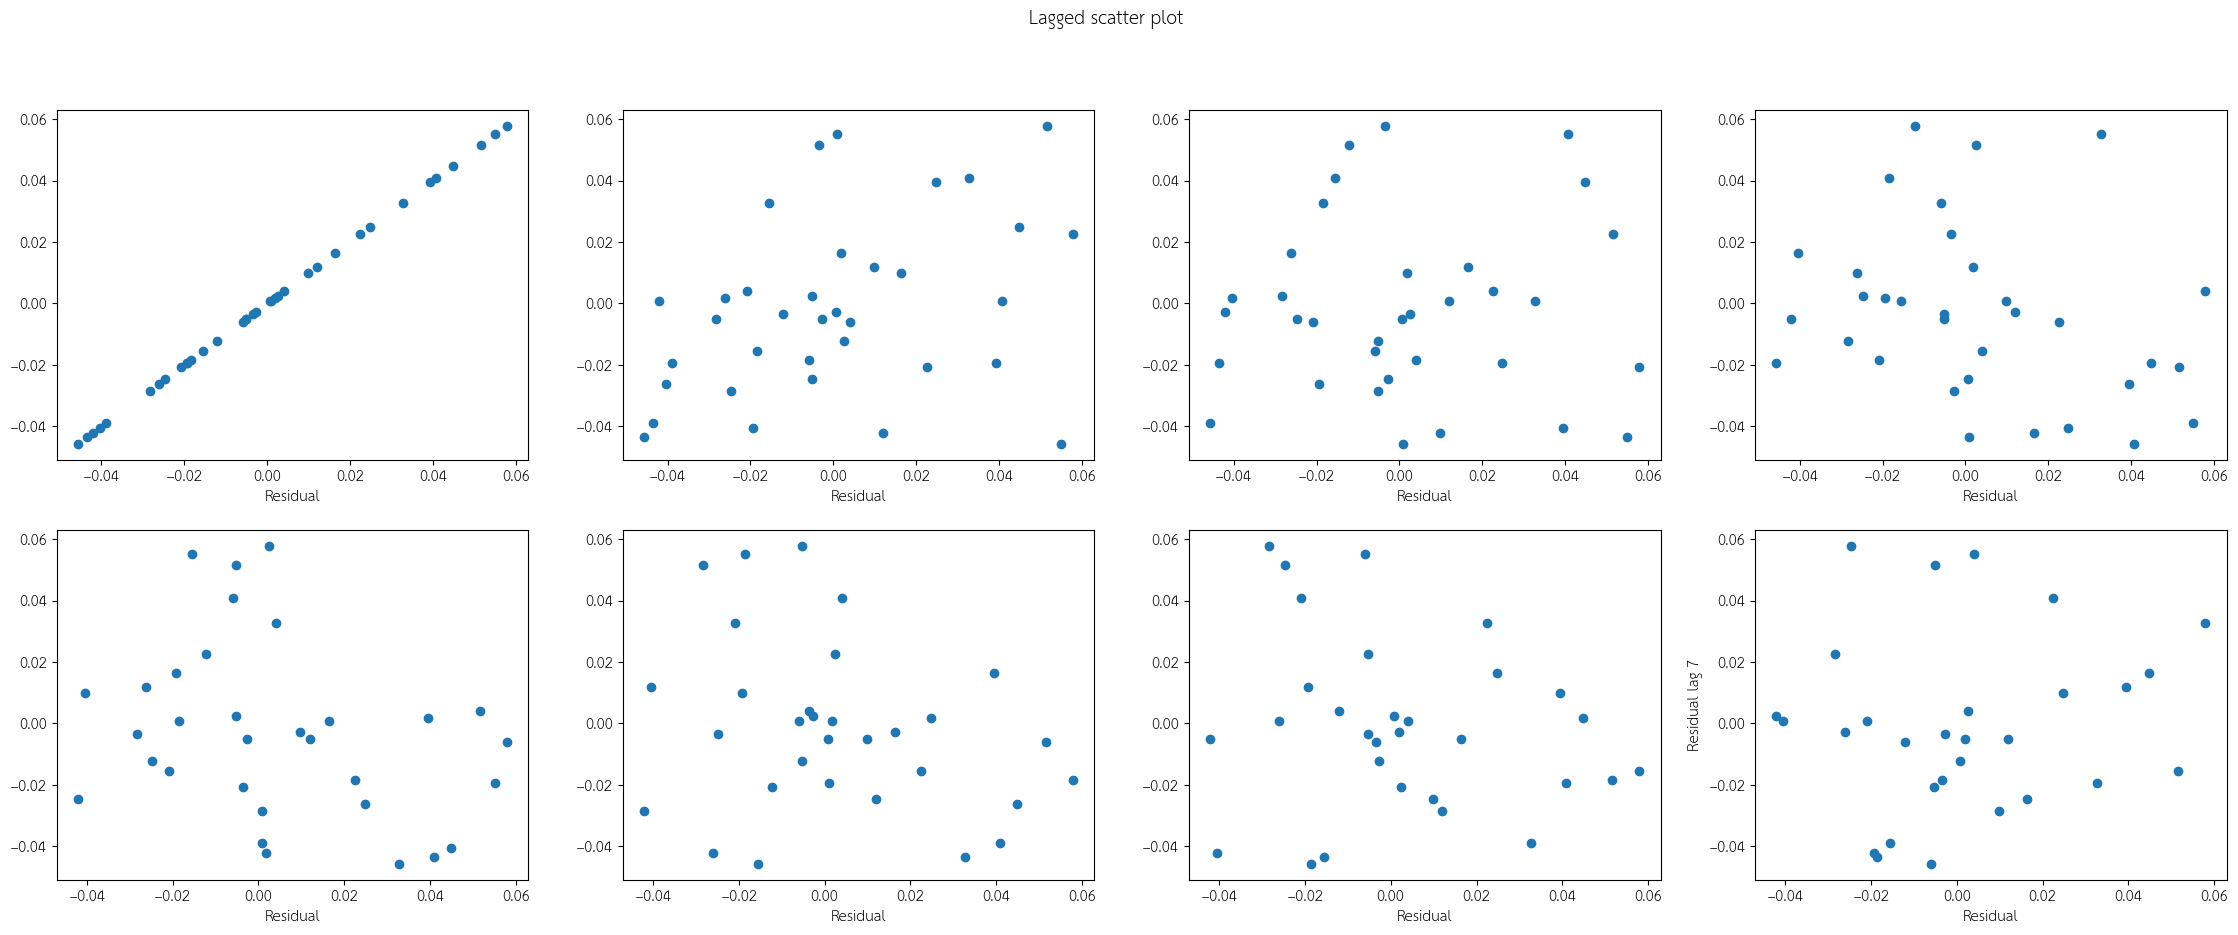

In [65]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gb_b.resid,
                y = reg_gb_b.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

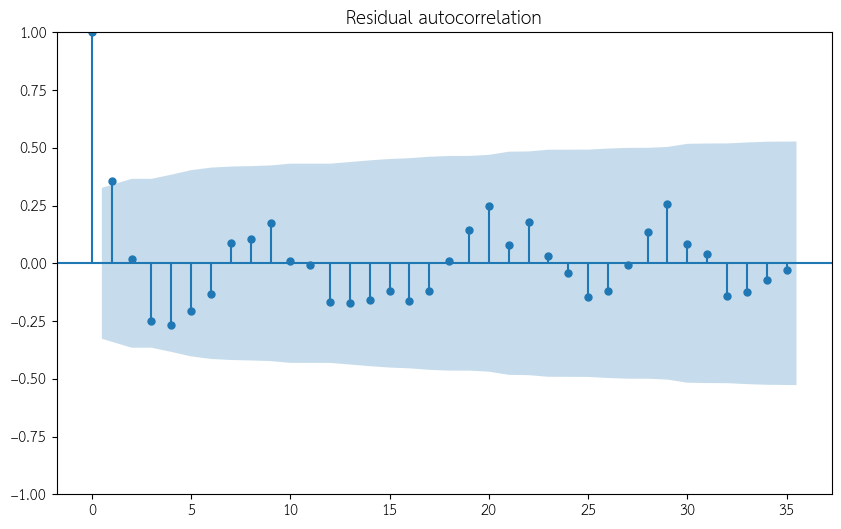

Durbin-Watson :  1.2107089772038402


In [66]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gb_b.resid, lags = reg_gb_b.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gb_b.resid))


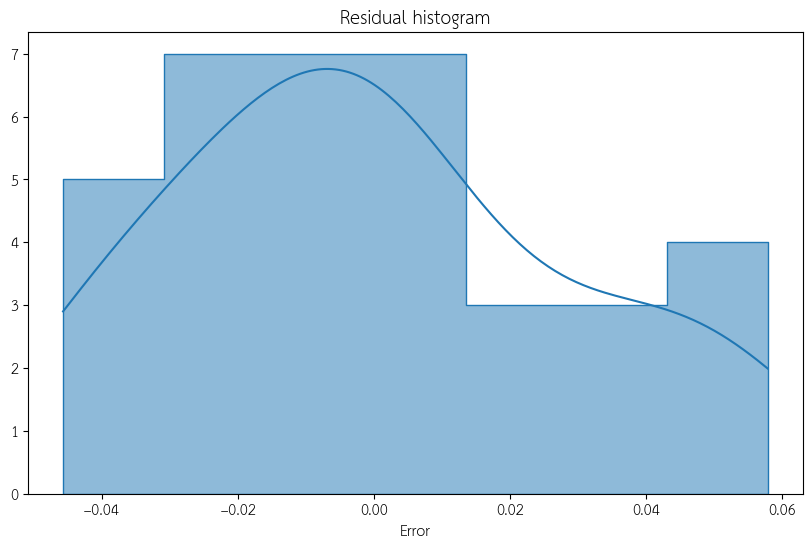

In [67]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gb_b.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

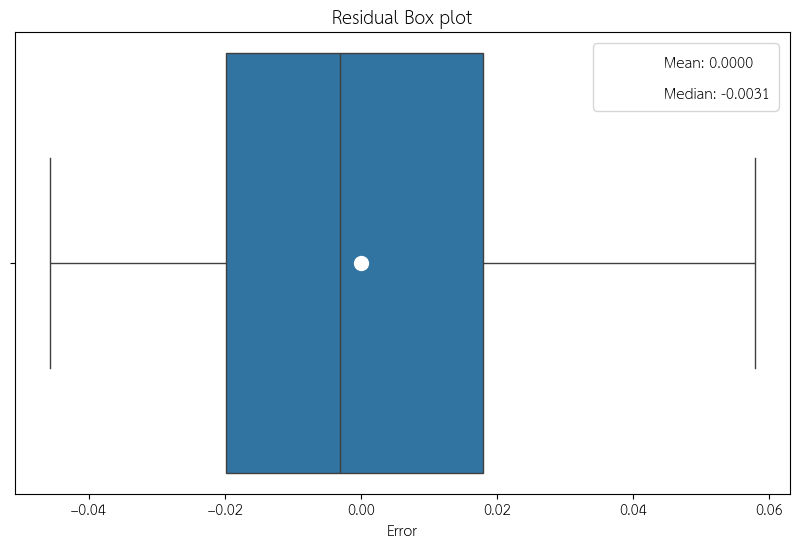

In [68]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gb_b.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gb_b.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gb_b.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

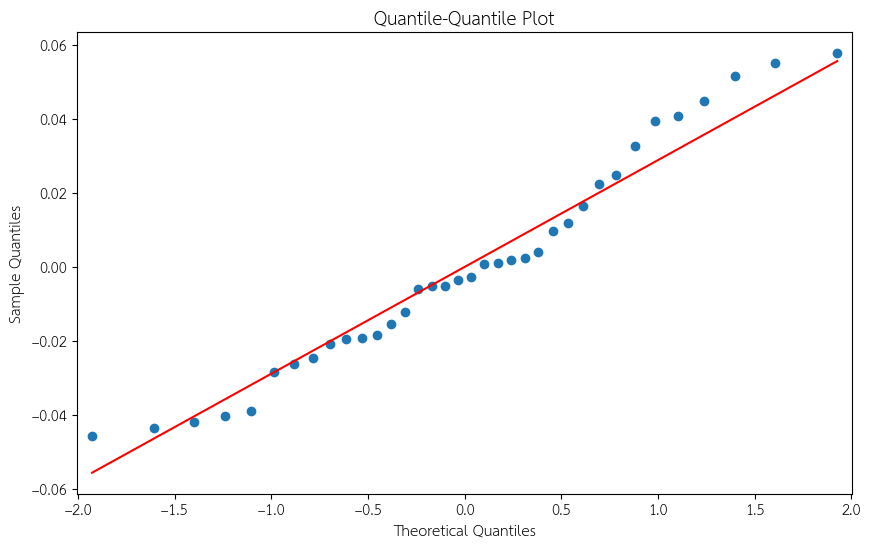

In [69]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gb_b.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [70]:
#Anderson darling for normality
ad = AD(reg_gb_b.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gb_b.resid, dist='norm')[2], AD(reg_gb_b.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gb_b.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.4356119017851441
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


ราคาขายทองคำรูปพรรณ

In [71]:
from sklearn.linear_model import LinearRegression
X_gj_s = Gold_Factor_data[Factor_interested]
y_gj_s = np.log(Gold_Factor_data[['GoldJew_Sale']])
lrm_gj_s = LinearRegression()
lrm_gj_s.fit(X_gj_s,y_gj_s)
print('intercept , b : ',lrm_gj_s.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gj_s.coef_) # a
r2_gj_s = lrm_gj_s.score(X_gj_s,y_gj_s)
predict_GJ_S = lrm_gj_s.predict(X_gj_s)
GJ_S = pd.DataFrame()
GJ_S['Report Date'] =Gold_Factor_data['Report Date']
GJ_S['Predict'] = (predict_GJ_S)
predict_GJ_S
X_gj_s = sm.add_constant(X_gj_s)
reg_gj_s = sm.OLS(y_gj_s,X_gj_s).fit()
reg_gj_s.summary()

intercept , b :  [-2.43034298]
coef x1,x2,x3 :  [[-0.03670408  0.10944589  2.7497693 ]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GoldJew_Sale   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     62.70
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.71e-13
Time:                        08:33:22   Log-Likelihood:                 77.277
No. Observations:                  36   AIC:                            -146.6
Df Residuals:                      32   BIC:                            -140.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.4303      0.980     -2.479      0.019      -4.428      -0.433
(Inflation)                              -0.0367      0.006     -5.854      0.000      -0.049      -0.024
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4     0.1094      0.103      1.067      0.294      -0.099       0.318
LOG_CPI                                   2.7498      0.212     12.972      0.000       2.318       3.182
==============================================================================
Omnibus:                        1.955   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                1.617
Skew:                           0.368   Prob(JB):                        0.445
Kurtosis:                       2.267   Cond. No.                         994.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested], i) for i in range(len(Factor_interested))]
vif

Variable       VIF
0                            (Inflation)  2.486349
1  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4  1.132820
2                                LOG_CPI  2.673618

('Lagrange multiplier statistic', 3.3239967225094067)
('p-value', 0.34431668842067936)
('f-value', 1.0850765541612242)
('f p-value', 0.36943461068417094)


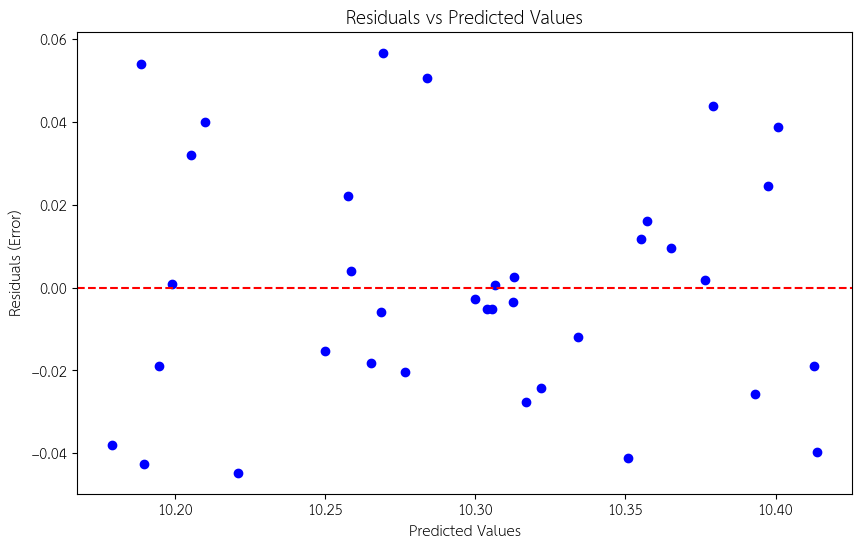

In [73]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gj_s.resid, X_gb_s)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gj_s.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

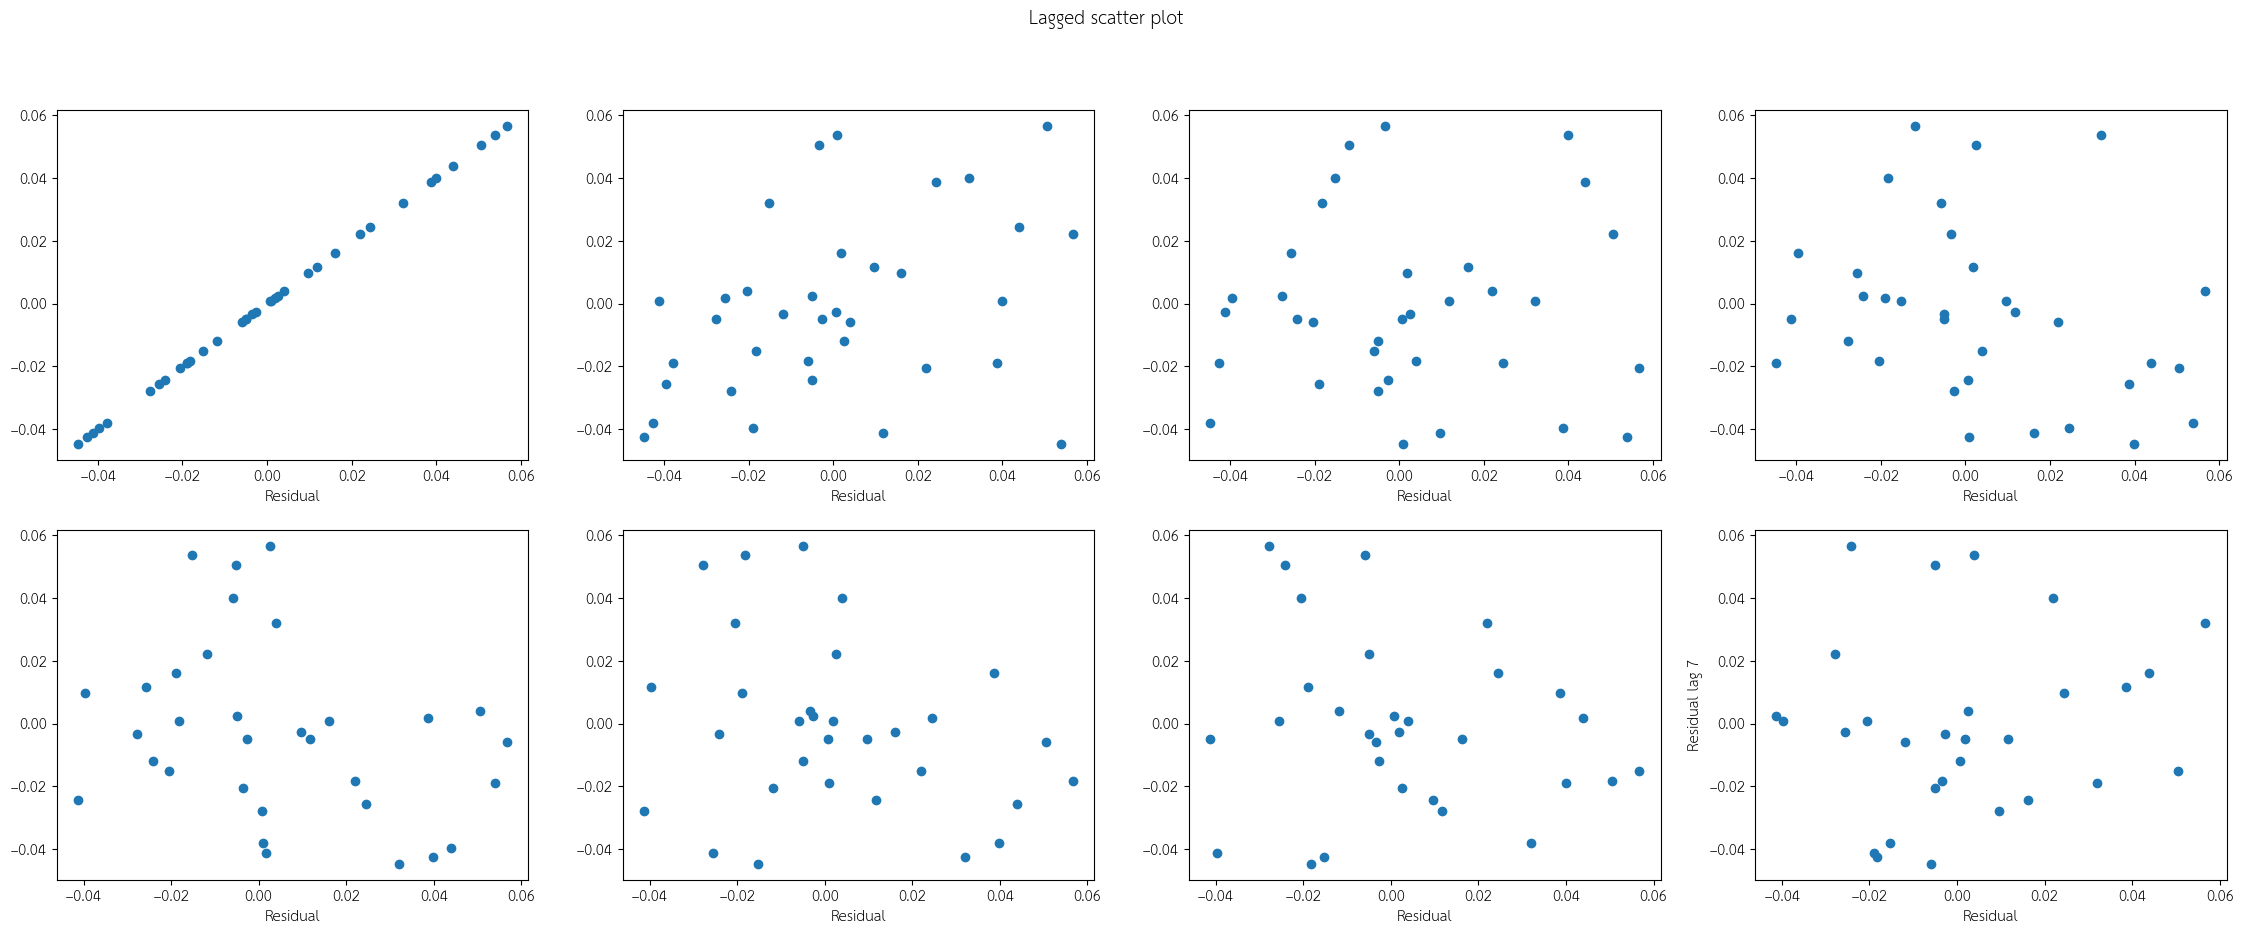

In [74]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gj_s.resid,
                y = reg_gj_s.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

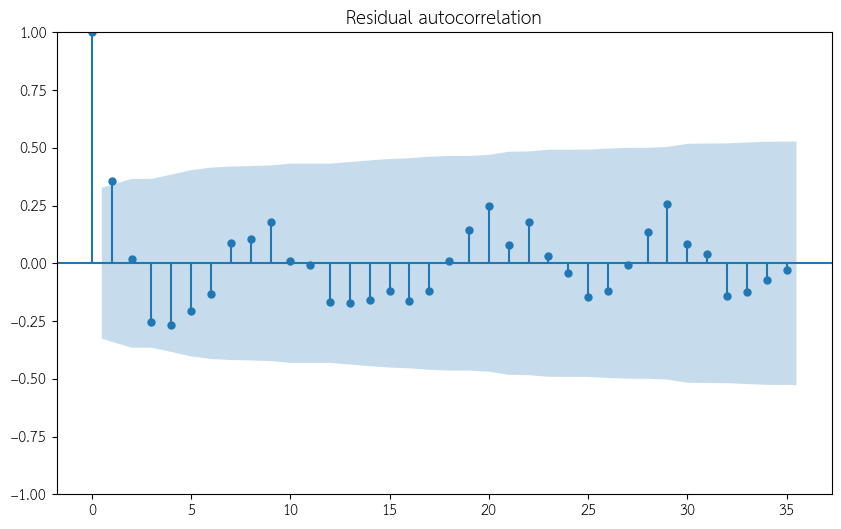

Durbin-Watson :  1.2111662583446043


In [75]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gj_s.resid, lags = reg_gj_s.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gj_s.resid))


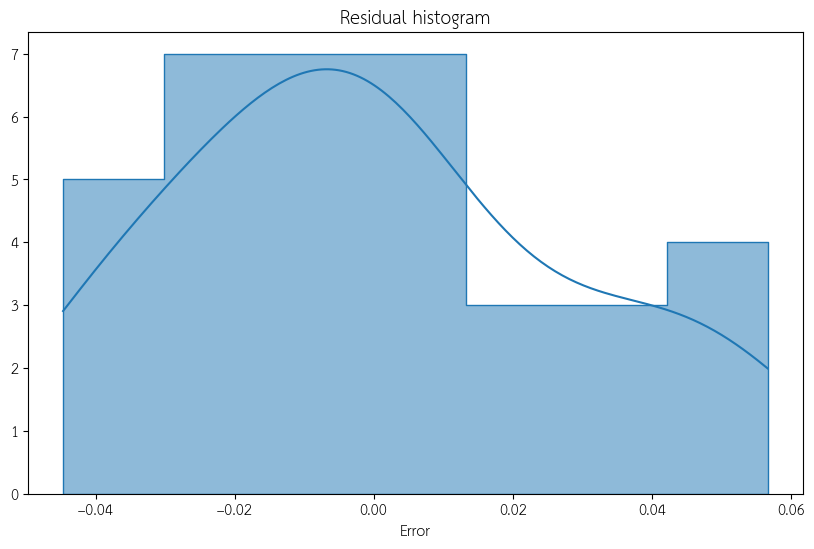

In [76]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gj_s.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

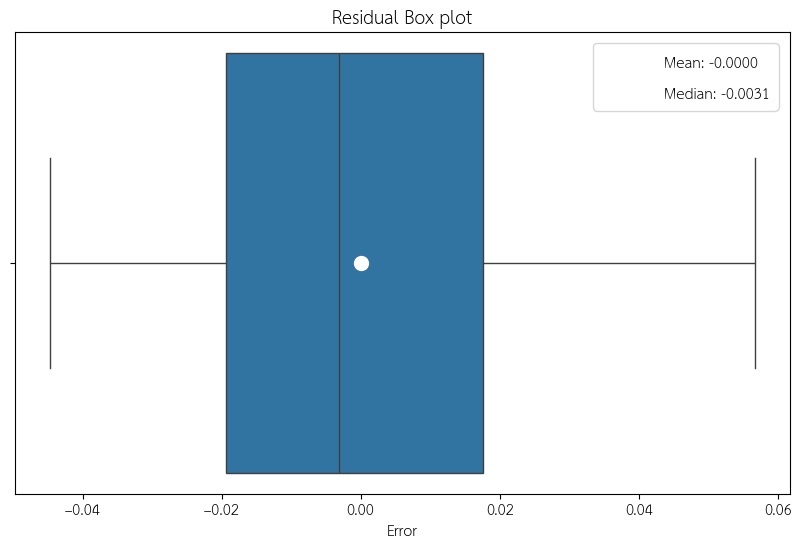

In [77]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gj_s.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gj_s.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gj_s.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

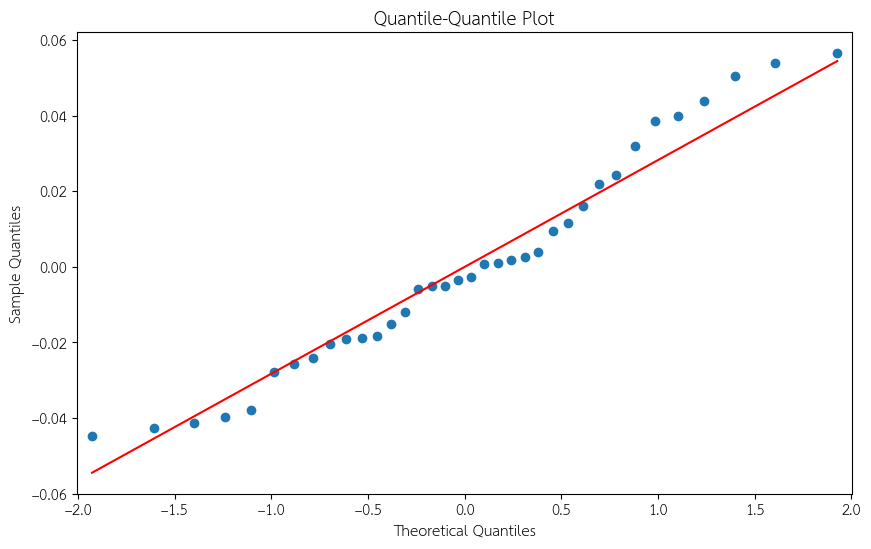

In [78]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gj_s.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [79]:
#Anderson darling for normality
ad = AD(reg_gj_s.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gj_s.resid, dist='norm')[2], AD(reg_gj_s.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gj_s.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.4377096542607717
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


ราคาซื้อทองรูปพรรณ

In [80]:
from sklearn.linear_model import LinearRegression
X_gj_b = Gold_Factor_data[Factor_interested]
y_gj_b = np.log(Gold_Factor_data[['GoldJew_Buy']])
lrm_gj_b = LinearRegression()
lrm_gj_b.fit(X_gj_b,y_gj_b)
print('intercept , b : ',lrm_gj_b.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gj_b.coef_) # a
r2_gj_b = lrm_gj_b.score(X_gj_b,y_gj_b)
predict_GJ_B = lrm_gj_b.predict(X_gj_b)
GJ_B = pd.DataFrame()
GJ_B['Report Date'] =Gold_Factor_data['Report Date']
GJ_B['Predict'] = (predict_GJ_B)
predict_GJ_B
X_gj_b = sm.add_constant(X_gj_b)
reg_gj_b = sm.OLS(y_gj_b,X_gj_b).fit()
reg_gj_b.summary()

intercept , b :  [-2.71632764]
coef x1,x2,x3 :  [[-0.03734     0.11186947  2.80318348]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GoldJew_Buy   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     62.51
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.78e-13
Time:                        08:33:25   Log-Likelihood:                 76.516
No. Observations:                  36   AIC:                            -145.0
Df Residuals:                      32   BIC:                            -138.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.7163      1.001     -2.713      0.011      -4.756      -0.677
(Inflation)                              -0.0373      0.006     -5.831      0.000      -0.050      -0.024
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4     0.1119      0.105      1.068      0.293      -0.101       0.325
LOG_CPI                                   2.8032      0.216     12.948      0.000       2.362       3.244
==============================================================================
Omnibus:                        1.962   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.617
Skew:                           0.366   Prob(JB):                        0.445
Kurtosis:                       2.264   Cond. No.                         994.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested], i) for i in range(len(Factor_interested))]
vif

Variable       VIF
0                            (Inflation)  2.486349
1  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4  1.132820
2                                LOG_CPI  2.673618

('Lagrange multiplier statistic', 3.3239967225094067)
('p-value', 0.34431668842067936)
('f-value', 1.0850765541612242)
('f p-value', 0.36943461068417094)


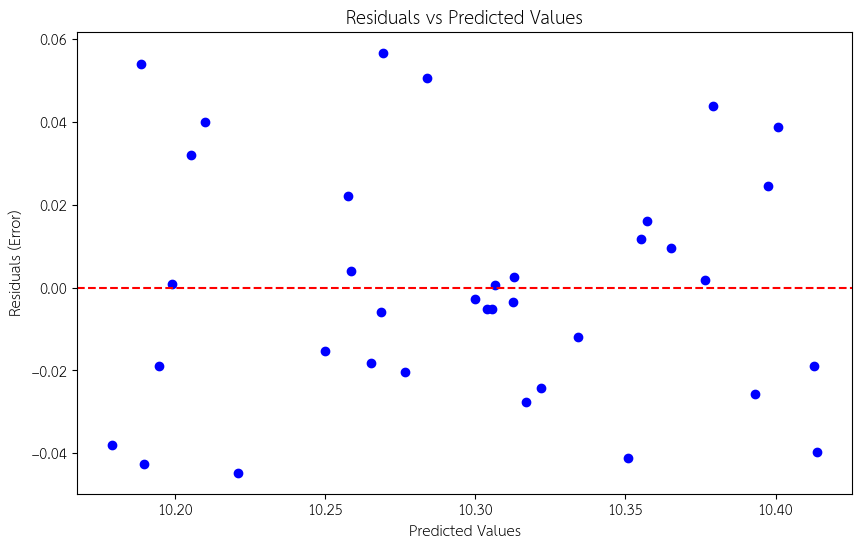

In [82]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gj_s.resid, X_gj_s)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gj_s.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

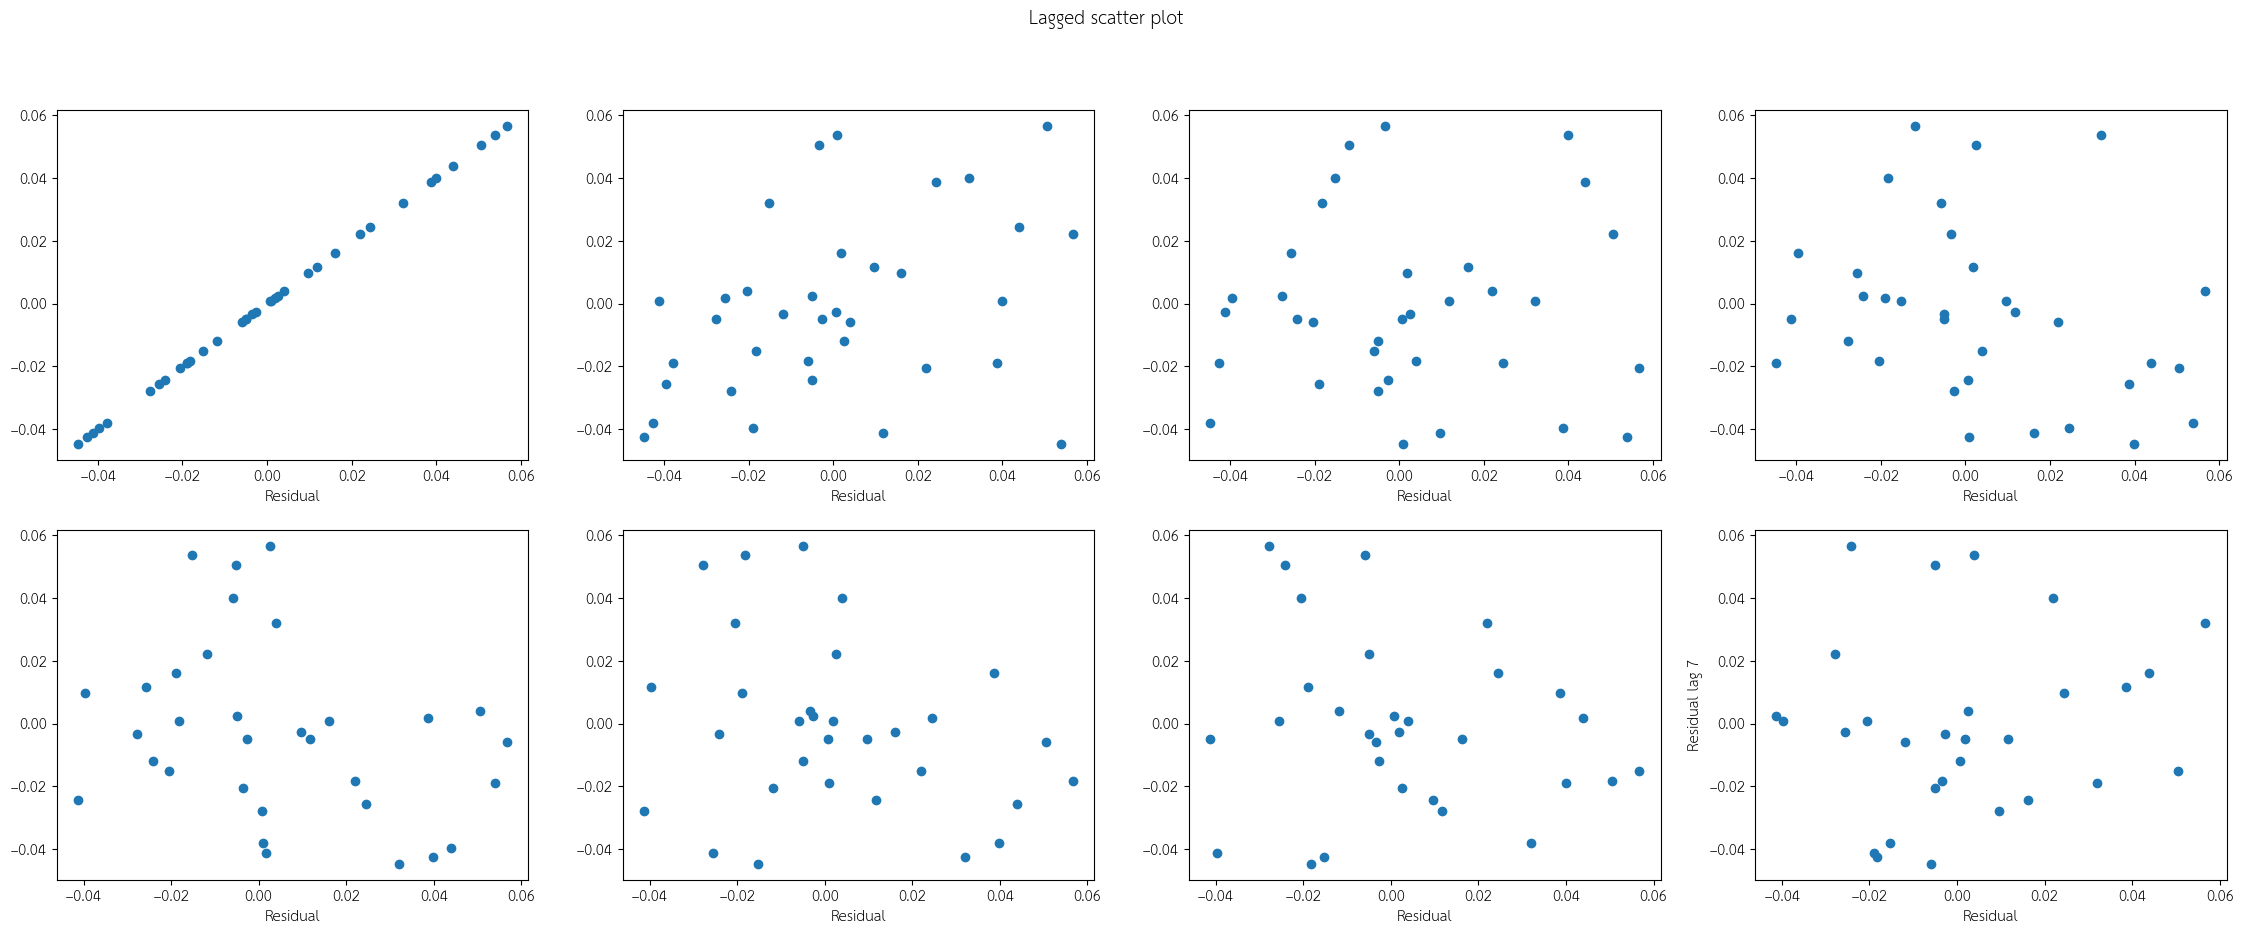

In [83]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gj_s.resid,
                y = reg_gj_s.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

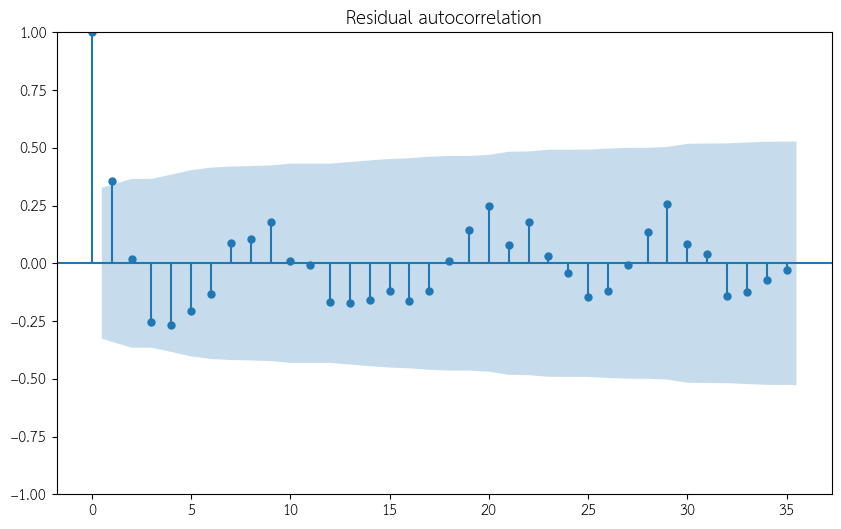

Durbin-Watson :  1.2107869675164178


In [84]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gj_s.resid, lags = reg_gj_s.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gb_s.resid))


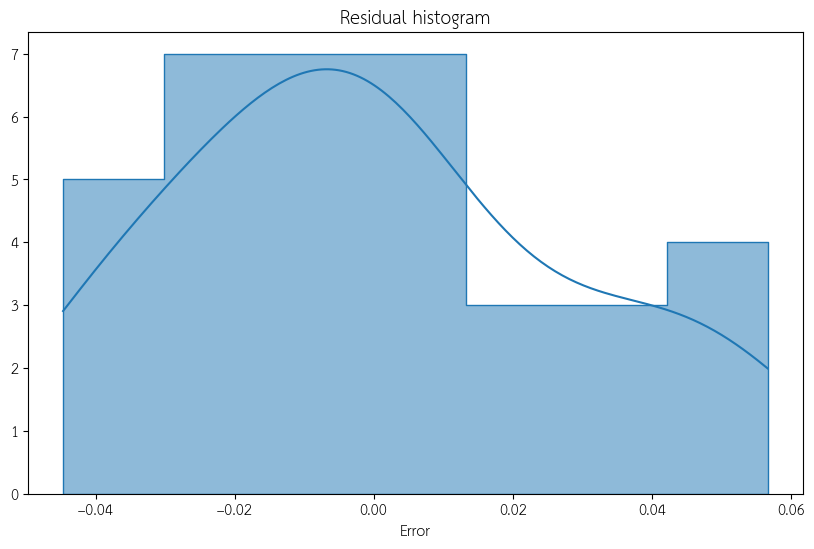

In [85]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gj_s.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

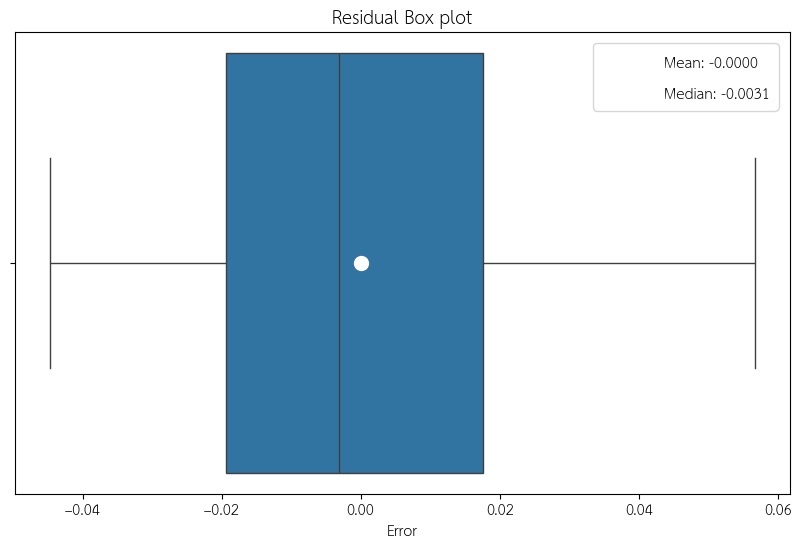

In [86]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gj_s.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gj_s.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gj_s.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

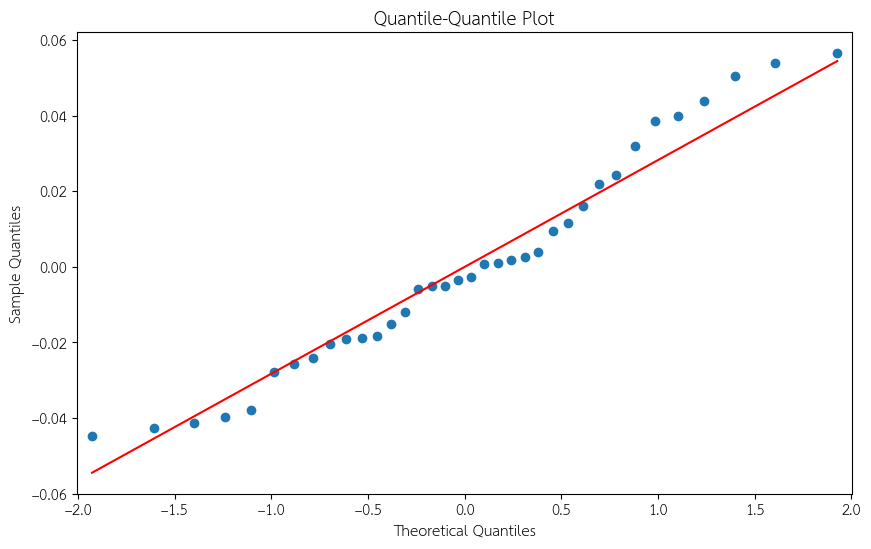

In [87]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gj_s.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [88]:
#Anderson darling for normality
ad = AD(reg_gj_b.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gj_b.resid, dist='norm')[2], AD(reg_gj_b.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gj_b.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.43698509413004416
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


Actual data vs Predict data (GoldBar_Sale price in Thailnad) Ex

In [89]:
Gold_Factor_data
GB_S

Report Date    Predict
120  2021-01-31  10.194790
121  2021-02-28  10.179253
122  2021-03-31  10.189814
123  2021-04-30  10.220915
124  2021-05-31  10.188714
125  2021-06-30  10.198953
126  2021-07-31  10.209980
127  2021-08-30  10.205523
128  2021-09-30  10.250036
129  2021-10-31  10.265493
130  2021-11-29  10.268810
131  2021-12-31  10.258840
132  2022-01-31  10.276672
133  2022-02-28  10.257786
134  2022-03-31  10.269454
135  2022-04-30  10.283850
136  2022-05-30  10.312463
137  2022-06-30  10.334296
138  2022-07-31  10.313083
139  2022-08-31  10.305760
140  2022-09-30  10.316969
141  2022-10-31  10.321843
142  2022-11-30  10.304051
143  2022-12-31  10.299919
144  2023-01-30  10.306571
145  2023-02-27  10.350856
146  2023-03-31  10.355325
147  2023-04-30  10.365303
148  2023-05-31  10.357076
149  2023-06-30  10.376348
150  2023-07-31  10.393246
151  2023-08-31  10.413760
152  2023-09-30  10.412856
153  2023-10-30  10.400695
154  2023-11-30  10.397495
155  2023-12-31  10.379127

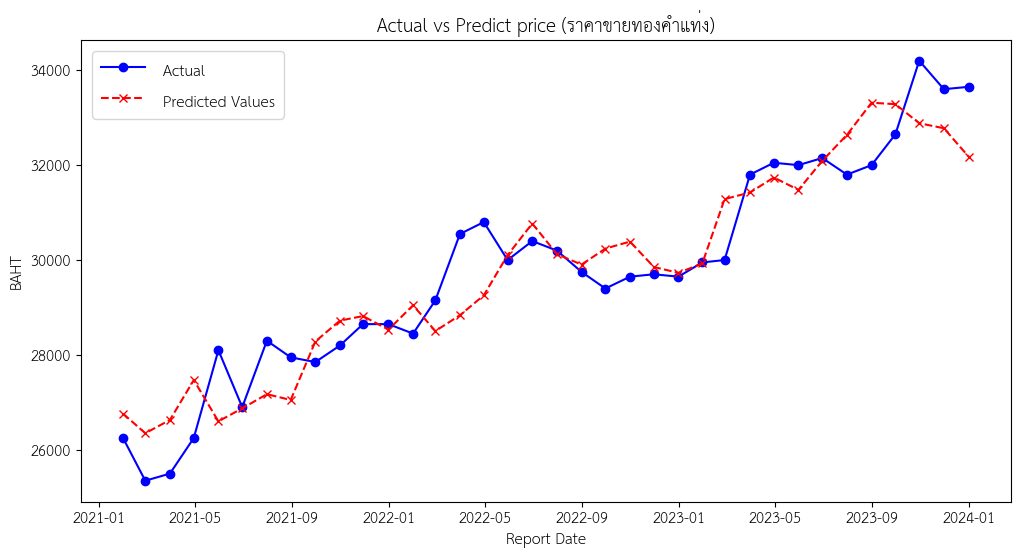

In [90]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'],(Gold_Factor_data['GoldBar_Sale']),label='Actual', color='blue',marker='o')
plt.plot(GB_S['Report Date'].iloc[0:],np.exp(GB_S['Predict']),label='Predicted Values',
         color='red',linestyle='--',marker='x')
plt.xlabel('Report Date')
plt.ylabel('BAHT')
plt.title('Actual vs Predict price (ราคาขายทองคำแท่ง)')
plt.legend()
plt.show()

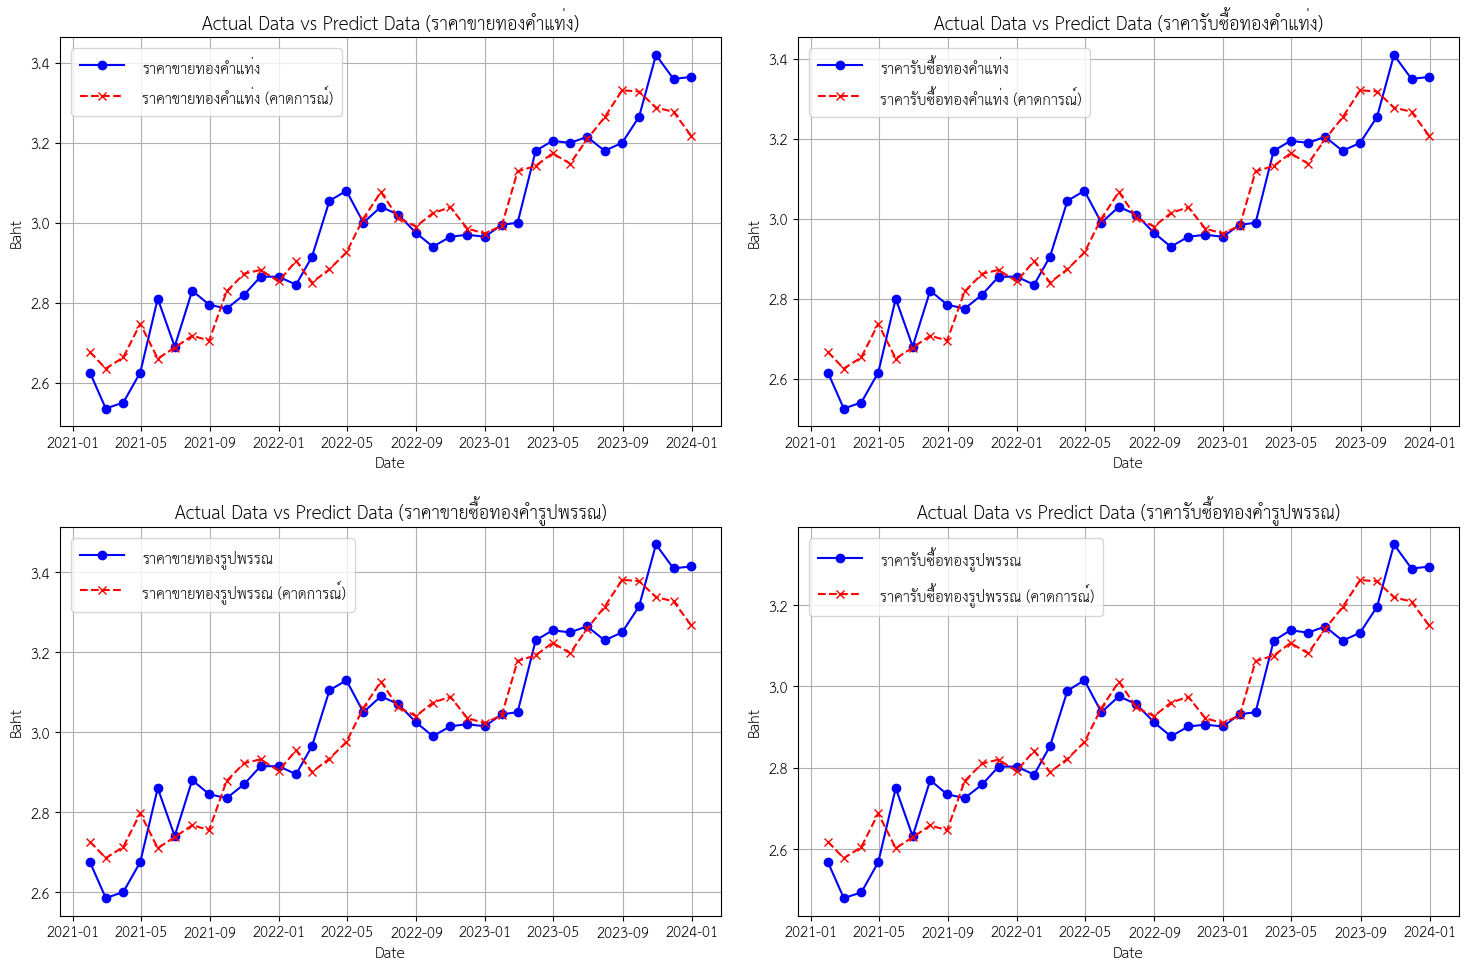

In [91]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # สร้างพื้นที่สำหรับ subplot 3 แถว 2 คอลัมน์
# กราฟที่ 1: ราคาขายทองคำแท่ง
axs[0, 0].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldBar_Sale']/10000, label='ราคาขายทองคำแท่ง',color='blue',marker='o')
axs[0, 0].plot(GB_S['Report Date'], np.exp(GB_S['Predict'])/10000, label='ราคาขายทองคำแท่ง (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Baht')
axs[0, 0].set_title('Actual Data vs Predict Data (ราคาขายทองคำแท่ง)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# กราฟที่ 2: ราคารับซื้อทองคำแท่ง
axs[0, 1].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldBar_Buy']/10000, label='ราคารับซื้อทองคำแท่ง',color='blue',marker='o')
axs[0, 1].plot(GB_B['Report Date'], np.exp(GB_B['Predict'])/10000, label='ราคารับซื้อทองคำแท่ง (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Baht')
axs[0, 1].set_title('Actual Data vs Predict Data (ราคารับซื้อทองคำแท่ง)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# กราฟที่ 3: ราคาขายทองคำรูปพรรณ
axs[1, 0].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldJew_Sale']/10000, label='ราคาขายทองรูปพรรณ',color='blue',marker='o')
axs[1, 0].plot(GJ_S['Report Date'], np.exp(GJ_S['Predict'])/10000, label='ราคาขายทองรูปพรรณ (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Baht')
axs[1, 0].set_title('Actual Data vs Predict Data (ราคาขายซื้อทองคำรูปพรรณ)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# กราฟที่ 4: ราคารับซื้อทองคำรูปพรรณ
axs[1, 1].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldJew_Buy']/10000, label='ราคารับซื้อทองรูปพรรณ',color='blue',marker='o')
axs[1, 1].plot(GJ_B['Report Date'], np.exp(GJ_B['Predict'])/10000, label='ราคารับซื้อทองรูปพรรณ (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Baht')
axs[1, 1].set_title('Actual Data vs Predict Data (ราคารับซื้อทองคำรูปพรรณ)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [91]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldBar_Sale']),np.exp(GB_S['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldBar_Sale']),np.exp(GB_S['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldBar_Sale'],np.exp(GB_S['Predict']))
print("Model of GoldBar_Sale")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE*100) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gb_s)
adj_r2 = 1 - ((1 - r2_gb_s) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldBar_Sale
MSE :  721698.6839544947
RMSE :  849.5285068521802
MAE :  684.6244219068235
MAPE :  2.3085479778943827
R-squared :  0.8545589886864543
Adj-R-squared :  0.8409238938758095


In [92]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldBar_Buy']),np.exp(GB_B['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldBar_Buy']),np.exp(GB_B['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldBar_Sale'],np.exp(GB_B['Predict']))
print("Model of GoldBar_Buy")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE*100) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gb_b)
adj_r2 = 1 - ((1 - r2_gb_b) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldBar_Buy
MSE :  721734.0400695162
RMSE :  849.5493158548927
MAE :  684.6310022058232
MAPE :  2.2846506699375424
R-squared :  0.8545478639643596
Adj-R-squared :  0.8409117262110183


In [93]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldJew_Sale']),np.exp(GJ_S['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldJew_Sale']),np.exp(GJ_S['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldJew_Sale'],np.exp(GJ_S['Predict']))
print("Model of GoldJew_Sale")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE*100) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gj_s)
adj_r2 = 1 - ((1 - r2_gj_s) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldJew_Sale
MSE :  721526.8888679141
RMSE :  849.4273888143201
MAE :  684.5923579074355
MAPE :  2.269937262109982
R-squared :  0.8546129220321407
Adj-R-squared :  0.8409828834726538


In [94]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldJew_Buy']),np.exp(GJ_B['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldJew_Buy']),np.exp(GJ_S['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldJew_Buy'],np.exp(GJ_S['Predict']))
print("Model of GoldJew_Buy")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE*100) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gj_b)
adj_r2 = 1 - ((1 - r2_gj_b) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldJew_Buy
MSE :  1957760.281952635
RMSE :  1399.1998720528225
MAE :  673.1137146049715
MAPE :  4.2712346638899605
R-squared :  0.8542435416889338
Adj-R-squared :  0.8405788737222714


Version 2

In [95]:
# Gold_Factor_data[['LOGIT']+Factor_interested].corr()
Gold_Factor_data[['GoldBar_Sale']+Factor_interested].corr()
# ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']

GoldBar_Sale  (Inflation)  \
GoldBar_Sale                               1.000000     0.274858   
(Inflation)                                0.274858     1.000000   
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4     -0.032353    -0.075122   
LOG_CPI                                    0.822405     0.698434   

                                       %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4  \
GoldBar_Sale                                                       -0.032353   
(Inflation)                                                        -0.075122   
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4                               1.000000   
LOG_CPI                                                            -0.116885   

                                        LOG_CPI  
GoldBar_Sale                           0.822405  
(Inflation)                            0.698434  
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4 -0.116885  
LOG_CPI                                1.000000

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

a :  0.020336311250102112
b : 10.271003395560848
intercept : [10.2710034]
R-squared : 0.09024038469496243
MAE :  1706.1813697510747
MAPE :  0.056975766936050665
MSE :  4622729.655033961
RMSE :  2150.0534074840934


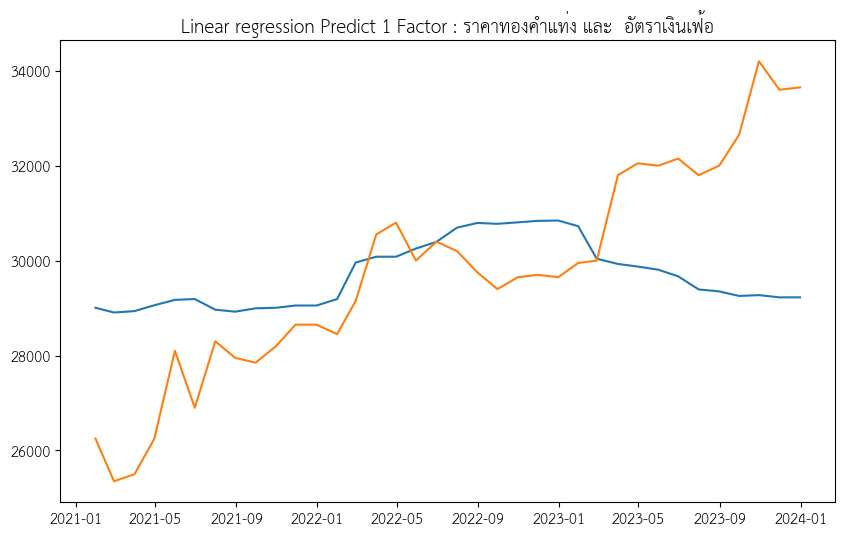

In [161]:
X = Gold_Factor_data[['(Inflation)']]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])
lrm = LinearRegression()
lrm.fit(X,y)
print("a : ",lrm.coef_[0][0]) # a
print("b :",lrm.intercept_[0]) # b
plt.title("Linear regression Predict 1 Factor : ราคาทองคำแท่ง และ  อัตราเงินเฟ้อ")
predictions = lrm.predict(X)
print("intercept :",lrm.intercept_)
print("R-squared :",lrm.score(X,y))
# n , p = X.shape
# adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
# print("Adj-R-squared : ",adj_r2_linear)
print("MAE : ",(metrics.mean_absolute_error(np.exp(y),np.exp(predictions))))
print("MAPE : ",metrics.mean_absolute_percentage_error(np.exp(y),np.exp(predictions)))
print("MSE : ",metrics.mean_squared_error(np.exp(y),np.exp(predictions)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(np.exp(y),np.exp(predictions))))

# plt.scatter(X,y,color='black')
plt.plot(Gold_Factor_data[['Report Date']],np.exp(predictions))
plt.plot(Gold_Factor_data[['Report Date']],np.exp(y))


In [175]:
Ex1 = pd.DataFrame({
    "Performance of model" : ['R-squared','MAE','MAPE','MSE','RMSE'],
    "Value" : [lrm.score(X,y),metrics.mean_absolute_error(np.exp(y),np.exp(predictions)),
              metrics.mean_absolute_percentage_error(np.exp(y),np.exp(predictions)),
              metrics.mean_squared_error(np.exp(y),np.exp(predictions)),
              np.sqrt(metrics.mean_squared_error(np.exp(y),np.exp(predictions)))]
})
Ex1['Value'] = Ex1['Value'].apply(lambda x: f"{x:.6f}")
Ex1

Performance of model           Value
0            R-squared        0.090240
1                  MAE     1706.181370
2                 MAPE        0.056976
3                  MSE  4622729.655034
4                 RMSE     2150.053407

In [168]:
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm
# combined_df = y.join(X)
# combined_df.columns.y = "Y"
# combined_df.columns.X = "X"
# model = ols('y ~ X', data=combined_df).fit()
# # # สร้างโมเดล Linear Regression

# # X = sm.add_constant(X)
# # model = sm.OLS(y,X).fit()
# # ดูสรุปของโมเดล
# # print(model.summary())
# model.summary()

# anova_table = anova_lm(model, typ=3)
# anova_table

In [170]:
# combined_df

In [171]:
# model.summary()

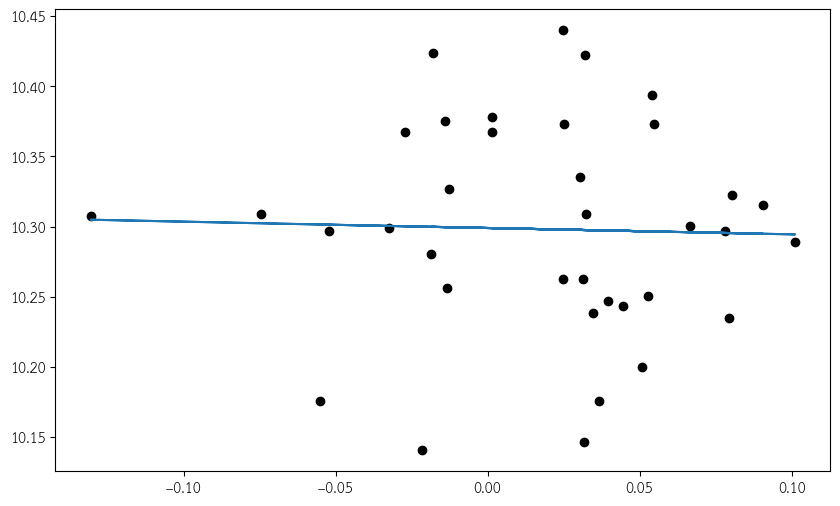

In [98]:
X = Gold_Factor_data[['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4']]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])
lrm = LinearRegression()
lrm.fit(X,y)
lrm.intercept_ # b
lrm.coef_ # a
predictions = lrm.predict(X)
plt.scatter(X,y,color='black')
plt.plot(X,predictions)

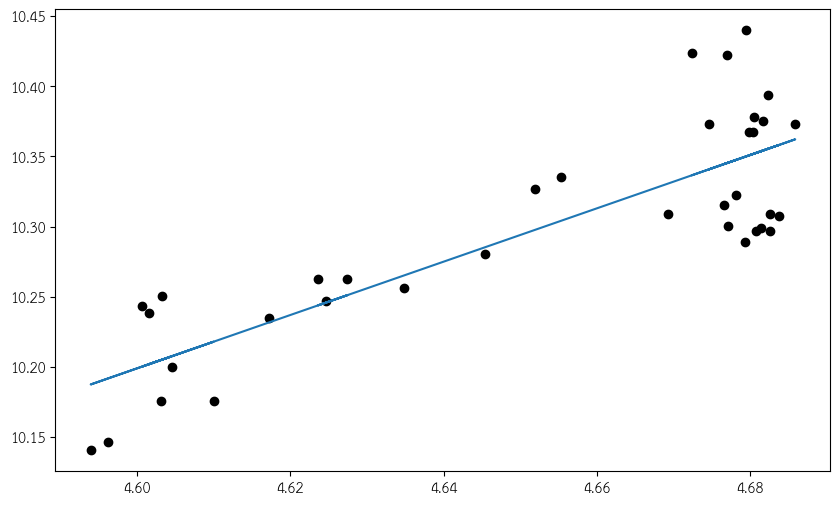

In [99]:
X = Gold_Factor_data[['LOG_CPI']]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])
lrm = LinearRegression()
lrm.fit(X,y)
lrm.intercept_ # b
lrm.coef_ # a
predictions = lrm.predict(X)
plt.scatter(X,y,color='black')
plt.plot(X,predictions)

In [100]:
from sklearn import metrics
metrics.mean_absolute_error(y,predictions)

0.03528752326215597

In [101]:
Gold_Factor_data[['GoldBar_Sale']+Factor_interested].corr()

GoldBar_Sale  (Inflation)  \
GoldBar_Sale                               1.000000     0.274858   
(Inflation)                                0.274858     1.000000   
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4     -0.032353    -0.075122   
LOG_CPI                                    0.822405     0.698434   

                                       %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4  \
GoldBar_Sale                                                       -0.032353   
(Inflation)                                                        -0.075122   
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4                               1.000000   
LOG_CPI                                                            -0.116885   

                                        LOG_CPI  
GoldBar_Sale                           0.822405  
(Inflation)                            0.698434  
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4 -0.116885  
LOG_CPI                                1.000000

In [102]:
from sklearn.linear_model import LinearRegression
X = Gold_Factor_data[Factor_interested]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])

In [103]:
lrm = LinearRegression()
lrm.fit(X,y)

LinearRegression()

In [104]:
predictions = lrm.predict(X)
np.exp(predictions)

array([[26763.38906775],
       [26350.77655832],
       [26630.54721249],
       [27471.80137168],
       [26601.27284493],
       [26875.0395831 ],
       [27173.03365617],
       [27052.18699573],
       [28283.56207896],
       [28724.13912353],
       [28819.56972608],
       [28533.66626013],
       [29047.03489112],
       [28503.6217885 ],
       [28838.13275118],
       [29256.30756528],
       [30105.48523275],
       [30770.00208322],
       [30124.16567853],
       [29904.37511278],
       [30241.45059429],
       [30389.20889642],
       [29853.31184944],
       [29730.20960677],
       [29928.63266139],
       [31283.79793586],
       [31423.93819797],
       [31739.04751384],
       [31478.99793753],
       [32091.54633424],
       [32638.45032411],
       [33314.89558682],
       [33284.7945461 ],
       [32882.46761248],
       [32777.42501355],
       [32180.84021532]])

In [105]:
from sklearn import metrics
metrics.mean_absolute_error(y,predictions) # MAE

0.023134766172107152

In [106]:
y.mean()

GoldBar_Sale    10.29822
dtype: float64

In [107]:
metrics.mean_squared_error(y,predictions) # MSE

0.0008276449596369482

In [ ]:
np.sqrt(metrics.mean_squared_error(y,predictions)) #RMSE

0.023765583533065848

In [ ]:
lrm.score(X,y) # R-Square

0.9007478836959921

In [ ]:
# MEAN : 10.040206
# MAE : 0.09521426489602582 ค่าต่ำ แสดงถึง โมเดลคาดการณ์ได้ดี
# MSE : 0.014789767007600822 ค่าต่ำแสดงถึง โมเดลคาดการณ์ได้ดี
# RMSE : 0.12161318599395718 # ค่าต่ำแสดงถึง ค่าความคลาดเคลื่อนจากค่าจริง
# R-Squared : 0.532340099507458 # โมเดลสามารถอธิบายความแปรผันของตัวแปรตามได้ประมาณ 53.23%
# ซึ่งแสดงให้เห็นว่ามีความสัมพันธ์ระหว่างตัวแปรต้นและตัวแปรตาม แต่ยังไม่สูงมากนัก อาจมีปัจจัยอื่นที่ยังไม่ได้ถูกพิจารณา.
# metrics.mean_absolute_error(y,predictions)
# metrics.mean_squared_error(y,predictions)
# np.sqrt(metrics.mean_squared_error(y,predictions))

OLS Regression Model

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
X = Gold_Factor_data[Factor_interested]
y = (Gold_Factor_data[['GoldBar_Sale']])

In [ ]:
model = sm.OLS(y,X)

In [ ]:
# model.params # ceof
result = model.fit()
result.params

(Inflation)                     -275.461534
LOG_PTT_แก๊สโซฮอล์_95_LAG_2     8747.573220
%CHANGE_PTT_ดีเซล_LAG_5       -11299.500698
dtype: float64

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           GoldBar_Sale   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.610e+04
Date:                Thu, 25 Jul 2024   Prob (F-statistic):                    2.74e-52
Time:                        09:00:20   Log-Likelihood:                         -290.82
No. Observations:                  36   AIC:                                      587.6
Df Residuals:                      33   BIC:                                      592.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
(Inflation)                  -275.4615    126.772     -2.173      0.037    -533.381     -17.542
LOG_PTT_แก๊สโซฮอล์_95_LAG_2  8747.5732     64.607    135.397      0.000    8616.130    8879.017
%CHANGE_PTT_ดีเซล_LAG_5      -1.13e+04   1423.889     -7.936      0.000   -1.42e+04   -8402.577
==============================================================================
Omnibus:                        3.340   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.370
Skew:                          -0.619   Prob(JB):                        0.306
Kurtosis:                       3.216   Cond. No.                         39.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot Graph

       ! Gold_data -> File


<Axes: >

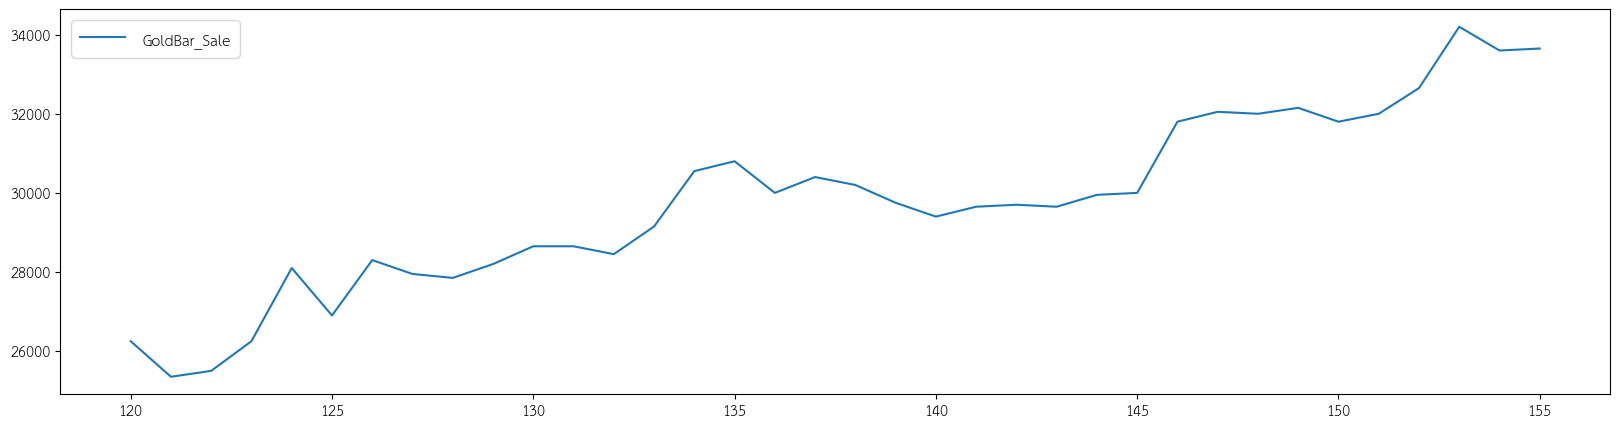

In [720]:
(Gold_Factor_data['GoldBar_Sale']).plot(figsize = (20,5) , legend = True)

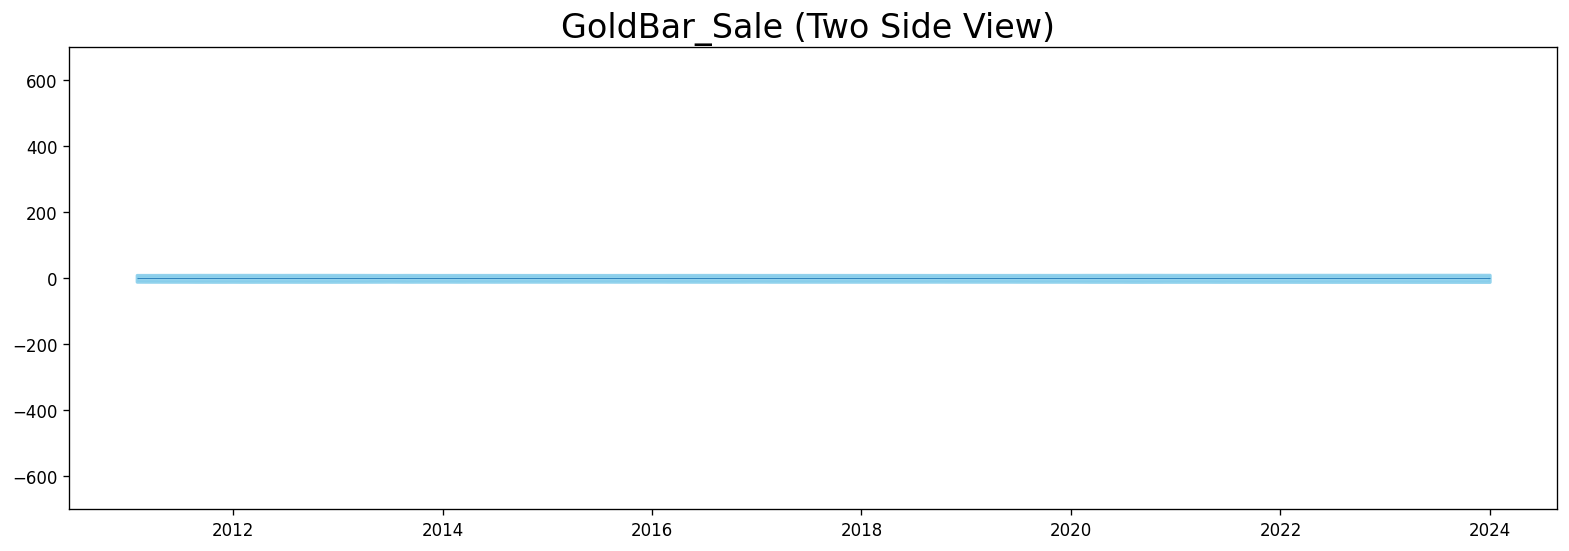

In [ ]:
#Plot Two Side View
fig , ax = plt.subplots(1,1,figsize=(16,5) , dpi=120)
x = Gold_data['Report Date'].values

y1 = np.log(Gold_data['GoldBar_Sale'].values)

plt.fill_between( x , y1 = y1 , y2 = -y1 , alpha=0.9 , linewidth=2, color='skyblue')

plt.ylim(-700 , 700 )
plt.title('GoldBar_Sale (Two Side View) ' , fontsize = 20)

plt.hlines( y=0 , xmin = np.min(Gold_data['Report Date']) , xmax = np.max(Gold_data['Report Date']) , linewidth=0.5)

plt.show()

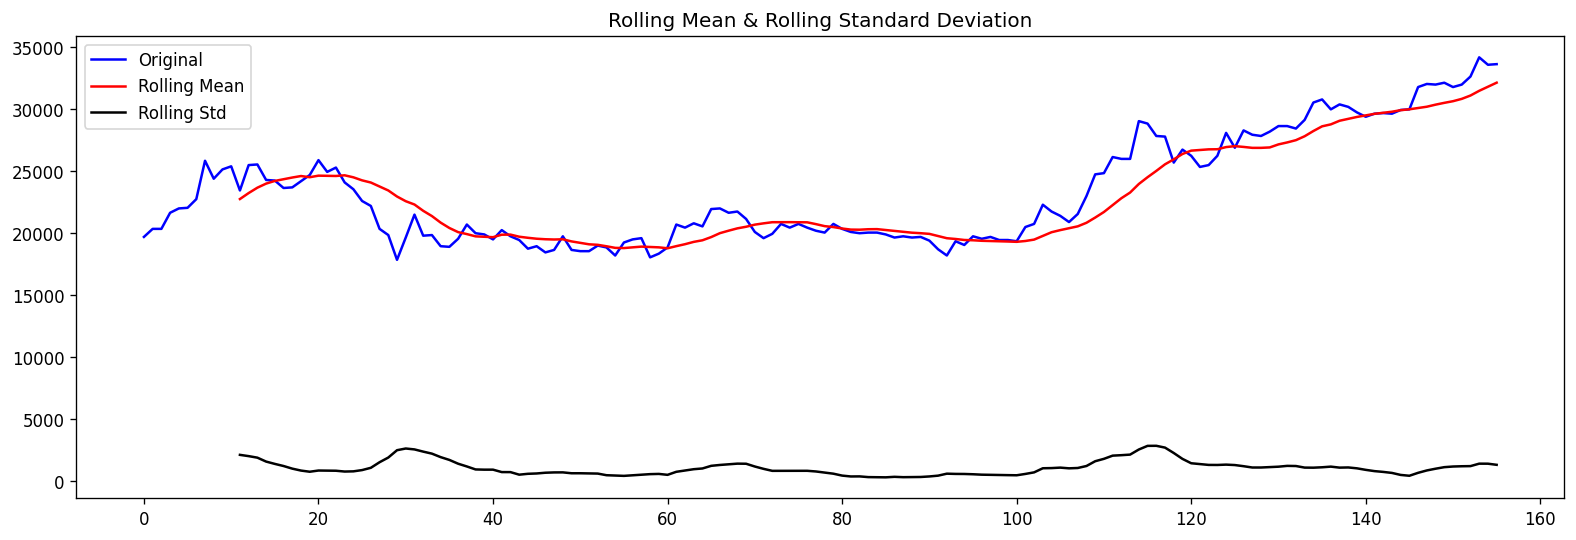

In [ ]:
#ทดสอบ Stationary
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window = 12).mean()
rolling_std = Gold_data['GoldBar_Sale'].rolling(window = 12).std()
fig , ax = plt.subplots(1,1,figsize=(16,5),dpi = 120)
plt.plot(Gold_data['GoldBar_Sale'],color = 'blue',label = 'Original')
plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
result = adfuller(Gold_data['GoldBar_Sale'])
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical Values:')
for key , value in result[4].items():
    print('\t{}: {}'.format(key,value))

ADF Statistic : -0.25132470546380203
p-value : 0.9321208869747761
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525


In [ ]:
# function
def get_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    original = plt.plot(timeseries, color = 'blue' , label ='Original')
    mean = plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
    std = plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block =False)
    # Dickey-Fuller Test
    result = adfuller(timeseries)
    print('ADF Statiestic: {} '.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key , value in result[4].items():
        print('\t{} : {}'.format(key,value))

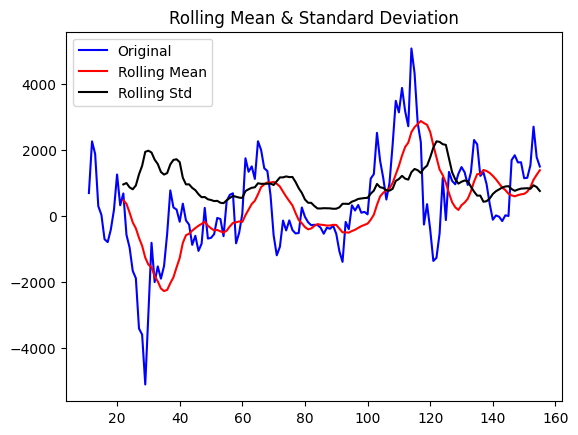

ADF Statiestic: -3.3308983120231344 
p-value: 0.013552562125553171
Critical Values:
	1% : -3.476597917537401
	5% : -2.8818291230495543
	10% : -2.5775887982253085


In [ ]:
# วิธีแรกในการปรับข้อมูลให้เรียบคือ การลบด้วยค่าเฉลี่ยเคลื่อนที่ 12 เดือนย้อนหลังออกไป เพื่อกำจัด ฤดูกาลกับแนวโน้ม
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window=12).mean()
df_log_minus_mean = Gold_data['GoldBar_Sale'] - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

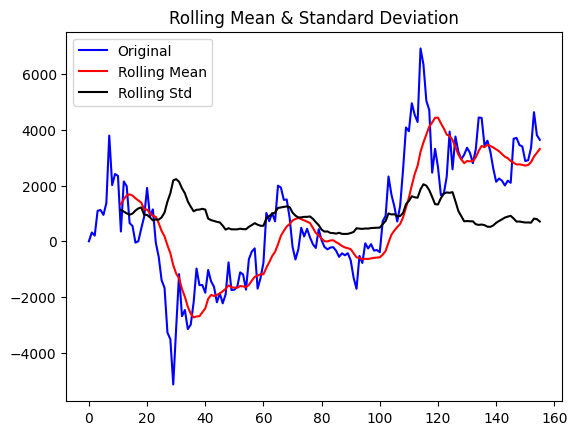

ADF Statiestic: -2.206766739159659 
p-value: 0.20379869426954533
Critical Values:
	1% : -3.4732590518613002
	5% : -2.880374082105334
	10% : -2.5768120811654525


In [ ]:
# p value ต่ำแล้ว ลองวิธี take log
rolling_mean_exp_decay = Gold_data['GoldBar_Sale'].ewm(halflife=12,min_periods=0,adjust=True).mean()

df_log_exp_decay = Gold_data['GoldBar_Sale'] - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace = True)
get_stationarity(df_log_exp_decay)

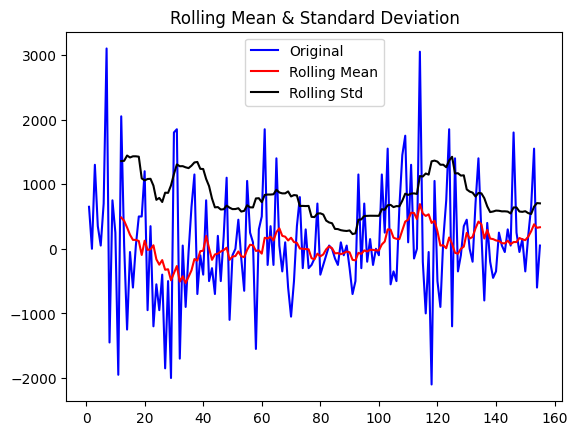

ADF Statiestic: -13.656836430155131 
p-value: 1.5480057912548305e-25
Critical Values:
	1% : -3.473542528196209
	5% : -2.880497674144038
	10% : -2.576878053634677


In [ ]:
# วิธีลบด้วยค่าก่อนหน้า
df_log_shift = Gold_data['GoldBar_Sale'] - Gold_data['GoldBar_Sale'].shift()
df_log_shift.dropna(inplace = True)
get_stationarity(df_log_shift)

สร้าง ARIMA Model

In [105]:
# import libaries
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import joblib
import os

In [92]:
# 1,1,2 ARIMA Model
model = pm.ARIMA(order=(1,1,2),seasonal=False)
model_fit = model.fit(Gold_Factor_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregress

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -277.333
Date:                Thu, 08 Aug 2024   AIC                            564.665
Time:                        09:02:38   BIC                            572.442
Sample:                             0   HQIC                           567.350
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    281.4693   1682.581      0.167      0.867   -3016.329    3579.267
ar.L1         -0.1253      6.769     -0.019      0.985     -13.392      13.141
ma.L1         -0.0380      6.776     -0.006      0.9

In [107]:
# 1,1,1 ARIMA Model
model = pm.ARIMA(order=(1,1,1),seasonal=False)
model_fit = model.fit(Gold_Factor_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -277.351
Date:                Wed, 07 Aug 2024   AIC                            562.703
Time:                        08:21:39   BIC                            568.924
Sample:                             0   HQIC                           564.850
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    239.7733    237.081      1.011      0.312    -224.898     704.444
ar.L1          0.0437      0.980      0.045      0.964      -1.878       1.965
ma.L1         -0.2080      0.994     -0.209      0.8

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


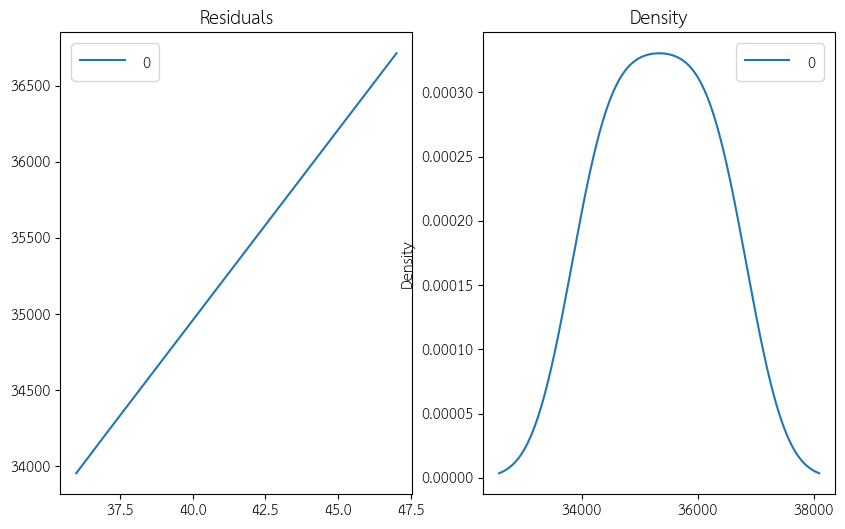

In [108]:
# เลือกอันที่ P > |Z| ดีๆ คือค่าน้อยๆ
preds, conf_int = model_fit.predict(n_periods=12, return_conf_int=True)
residuals = pd.DataFrame(preds)
fig,ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

ARIMA MODEL pmdarima

In [109]:
arima = pm.auto_arima(Gold_Factor_data['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=False, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)

preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)
arima_only_predict = preds
arima_only_best_case = conf_int[:, 1]  # upper bound ของ confidence interval
arima_only_worst_case = conf_int[:, 0]  # lower bound ของ confidence interval
arima.summary()

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -277.367
Date:                Wed, 07 Aug 2024   AIC                            560.733
Time:                        08:21:40   BIC                            565.400
Sample:                             0   HQIC                           562.344
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    258.0427    124.861      2.067      0.039      13.320     502.766
ma.L1         -0.1646      0.161     -1.023      0.306      -0.480       0.151
sigma2      4.464e+05   1.23e+05      3.628      0.000    2.05e+05    6.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.68   Prob(JB):                         0.09
Heteroskedasticity (H):               0.88   Skew:                             0.87
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
arima_only_predict

36    33959.494775
37    34217.537510
38    34475.580246
39    34733.622981
40    34991.665716
41    35249.708451
42    35507.751186
43    35765.793922
44    36023.836657
45    36281.879392
46    36539.922127
47    36797.964862
dtype: float64

In [111]:
arima_only_best_case

array([35269.07791044, 35923.98710425, 36502.63042866, 37037.07575282,
       37541.73569567, 38024.56324552, 38490.49847001, 38942.859169  ,
       39384.00120851, 39815.66886548, 40239.19641701, 40655.63157942])

In [112]:
arima_only_worst_case

array([32649.91163976, 32511.08791637, 32448.53006238, 32430.17020864,
       32441.5957362 , 32474.85365678, 32525.0039027 , 32588.72867413,
       32663.67210504, 32748.08991848, 32840.64783737, 32940.29814538])

In [113]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [114]:
Date = Gold_Factor_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = 12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)
# Date_forecast_period['Report Date']

In [115]:
Date_forecast_period

Report Date
0   2024-01-31
1   2024-02-29
2   2024-03-31
3   2024-04-30
4   2024-05-31
5   2024-06-30
6   2024-07-31
7   2024-08-31
8   2024-09-30
9   2024-10-31
10  2024-11-30
11  2024-12-31

In [116]:
# Gold_Factor_data['Report Date'].iloc[-1:]
# Date_forecast_period['Report Date'].iloc[:1]
# arima_only_best_case[0]
# Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]

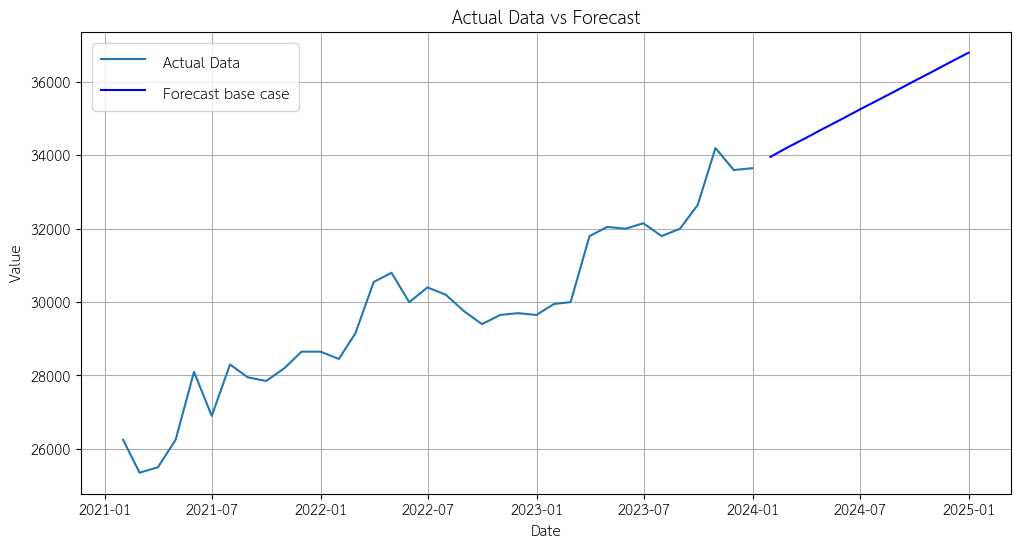

In [117]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_Factor_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
Date_for_connect['Value'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:],arima_only_predict.iloc[:1]])
# Date_for_connect['Best'] = pd.concat([(Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]),arima_only_best_case[0]])
# Date_for_connect['Worst'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_worst_case[0]])
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict , label='Forecast base case' , color = 'blue')
# plt.plot(Date_forecast_period,arima_only_best_case , label='Forecast best case' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_worst_case , label='Forecast worst case' , color = 'red')
plt.plot(Date_for_connect['Report Date'] ,Date_for_connect['Value'],color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'], np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], arima_only_best_case),color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'] ,np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], base_case),color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Forecast GoldBar_Sale price in Thailand with 3 Factor by LinearRegression and ARIMA model

In [118]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [119]:
Date = Gold_Factor_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = 12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)
Date_forecast_period

Report Date
0   2024-01-31
1   2024-02-29
2   2024-03-31
3   2024-04-30
4   2024-05-31
5   2024-06-30
6   2024-07-31
7   2024-08-31
8   2024-09-30
9   2024-10-31
10  2024-11-30
11  2024-12-31

In [120]:
Factor_data_selected_P = Gold_Factor_data[[
                                '(Inflation)',
]]
Factor_data_selected_NoP = Gold_Factor_data[[
    '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4',
    'LOG_CPI',
    'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
    '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
]]
# ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
# Factor_interested = ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
# Factor_interested_2 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']

In [237]:
import warnings

# ปิด DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [238]:
# Forecast ข้อมูล
output2_base = pd.DataFrame()
output2_worst = pd.DataFrame()
output2_best = pd.DataFrame()
for col in Factor_data_selected_NoP:
    data = Factor_data_selected_NoP[col]
    df = pd.DataFrame(data)
    df['LOG'] = np.log(df.values/df.shift(1))

    df = df.replace((np.inf, -np.inf, np.nan),0).reset_index(drop=True)
    df2 = df[1:]
    if col == '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4':
        print(col)
        arima_change_usd_thb_4 = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_change_usd_thb_4.predict(n_periods=period, return_conf_int=True)
    elif col == 'LOG_CPI':
        print(col)
        arima_log_cpi = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_log_cpi.predict(n_periods=period, return_conf_int=True)
    elif col == 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1':
        print(col)
        arima_ptt_95 = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_ptt_95.predict(n_periods=period, return_conf_int=True)
    elif col == '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2':
        print(col)
        arima_change_usd_thb_2 = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_change_usd_thb_2.predict(n_periods=period, return_conf_int=True)
        
        
    output = pd.DataFrame(preds)
    output.columns =['LOG']
    per_10 = np.percentile(df2['LOG'], 10)
    per_50 = np.percentile(df2['LOG'], 50)
    per_90 = np.percentile(df2['LOG'], 90)
    worst_return = per_50 - per_10
    best_return = per_90 - per_50
    print("\n\npercentile-10 :",per_10)
    print('percentile-50 :',per_50)
    print('percentile-90 :',per_90)
    print('worst_return : ',worst_return)
    print('best_return : ',best_return)
    v = Factor_data_selected_NoP[col].iloc[-1]
    print(v)
    base = []
    worst = []
    best = []
    for i in output.iterrows():
        x_base = v*math.exp(i[1].values)
        x_worst = v*math.exp(i[1].values - worst_return)
        x_best = v*math.exp(i[1].values + best_return)
        print("x base",x_base)
        print("x worst",x_worst)
        print("x_best",x_best)
        v = x_base
        print(f"v : {v} \n\n",)
        base = np.append(base, x_base)
        worst = np.append(worst, x_worst)
        best = np.append(best, x_best)
    output_base = pd.DataFrame(base)
    output_worst = pd.DataFrame(worst)
    output_best = pd.DataFrame(best)
    output2_base[col] = output_base
    if col == '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4':
        output2_worst[col] = output_best
        output2_best[col] = output_worst
    else:
        output2_worst[col] = output_worst
        output2_best[col] = output_best

%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=102.159, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=97.324, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=100.390, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=99.836, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=95.392, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=98.503, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=98.446, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=100.445, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=99.225, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=98.864, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=99.208, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 0.668 seconds


percentile-10 : -0.7481364299143389
percentile-50 : 0.0
percentile-90 : 0.8024702767082716
worst_return :  0.748136429914

In [235]:
arima_change_usd_thb_4.summary()
# arima_log_cpi.summary()
# arima_ptt_95.summary()
# arima_change_usd_thb_2.summary()
# arima_change_usd_thb_4.params
# arima_log_cpi.params
# arima_ptt_95.params
# arima_change_usd_thb_2.get_params()
# arima_change_usd_thb_2.order

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                        SARIMAX   Log Likelihood                 -46.696
Date:                Wed, 07 Aug 2024   AIC                             95.392
Time:                        13:35:05   BIC                             96.948
Sample:                             0   HQIC                            95.929
                                 - 35                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8441      0.095      8.865      0.000       0.657       1.031
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                72.75
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               9.82   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
output2_worst

%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   LOG_CPI  \
0                               -0.040182  4.668318   
1                               -0.040182  4.670314   
2                               -0.040182  4.672311   
3                               -0.040182  4.674309   
4                               -0.040182  4.676307   
5                               -0.040182  4.678307   
6                               -0.040182  4.680307   
7                               -0.040182  4.682308   
8                               -0.040182  4.684310   
9                               -0.040182  4.686313   
10                              -0.040182  4.688317   
11                              -0.040182  4.690321   

    LOG_PTT_แก๊สโซฮอล์_95_LAG_1  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  
0                      3.535183                              -0.026346  
1                      3.535183                              -0.026346  
2                      3.535183                              -0.026346  
3                      3.535183                              -0.026346  
4                      3.535183                              -0.026346  
5                      3.535183                              -0.026346  
6                      3.535183                              -0.026346  
7                      3.535183                              -0.026346  
8                      3.535183                              -0.026346  
9                      3.535183                              -0.026346  
10                     3.535183                              -0.026346  
11                     3.535183                              -0.026346

In [171]:
df.shift(1)
df

%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2       LOG
0                               -0.013871  0.000000
1                                0.014314  0.000000
2                                0.046216  1.172064
3                                0.021989 -0.742784
4                               -0.001601  0.000000
5                                0.028259  0.000000
6                                0.054505  0.656857
7                                0.006246 -2.166329
8                                0.023715  1.334169
9                                0.033209  0.336701
10                               0.001188 -3.330554
11                              -0.001802  0.000000
12                              -0.014536  2.087523
13                              -0.016852  0.147873
14                               0.001806  0.000000
15                               0.048056  3.281181
16                               0.030649 -0.449772
17                               0.030958  0.010028
18                               0.058017  0.628115
19                               0.034561 -0.518021
20                               0.040783  0.165532
21                               0.041895  0.026908
22                              -0.070426  0.000000
23                              -0.090407  0.249759
24                              -0.064654 -0.335277
25                               0.017625  0.000000
26                               0.040195  0.824423
27                              -0.031232  0.000000
28                               0.014052  0.000000
29                               0.033705  0.874903
30                              -0.012413  0.000000
31                              -0.008222 -0.411928
32                               0.067232  0.000000
33                               0.033162 -0.706748
34                              -0.032868  0.000000
35                              -0.049530  0.410080

In [123]:
output3_worst = Date_forecast_period.join(output2_worst)
output3_base = Date_forecast_period.join(output2_base)
output3_best = Date_forecast_period.join(output2_best)

# output3_worst.to_excel(result_worst_NoP)
# output3_base.to_excel(result_base_NoP)
# output3_best.to_excel(result_best_NoP)

In [241]:
# for rate type data

output2_base = pd.DataFrame()
output2_worst = pd.DataFrame()
output2_best = pd.DataFrame()
# Loop data
for col in Factor_data_selected_P:
    data = Factor_data_selected_P[col]
    df2 = data[1:]
    # arima
    print(col)
    arima = pm.auto_arima(df2, start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
    
    preds, conf_int = arima.predict(n_periods=period, return_conf_int=True)

    output = pd.DataFrame(preds)
    output.columns =['LOG']
    # ค่าความแปรปรวนร่วม Covariance
    # ส่วนเบี่ยงเบนมาตรฐาน
    var = math.sqrt(np.cov(df2))
    print(f'\n{var}')
    # ค่า Z = 1.28 ความมั่นใจที่ 80%
    worst_return = 1.28*var/math.sqrt(len(df2))
    best_return = 1.28*var/math.sqrt(len(df2))

    v = Factor_data_selected_P[col].iloc[-1]
    base = []
    worst = []
    best = []
    for i in output.iterrows():
        x_base = i[1]
        x_worst = i[1].values - worst_return
        x_best = i[1].values + best_return
        v = x_base
        base = np.append(base, x_base)
        worst = np.append(worst, x_worst)
        best = np.append(best, x_best)
    output_base = pd.DataFrame(base)
    output_worst = pd.DataFrame(worst)
    output_best = pd.DataFrame(best)
    output2_base[col] = output_base
    if col == 'Unemployment Rate':
        output2_worst[col] = output_best
        output2_best[col] = output_worst
    else:
        output2_worst[col] = output_worst
        output2_best[col] = output_best

(Inflation)
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-0.239, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=110.848, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=141.130, Time=0.00 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-3.137, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=28.363, Time=0.04 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-1.203, Time=0.45 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-9.189, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=24.428, Time=0.16 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-7.263, Time=0.57 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-2.82

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [186]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   35
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood                  10.595
Date:                             Wed, 07 Aug 2024   AIC                             -9.189
Time:                                     11:55:36   BIC                              0.143
Sample:                                          0   HQIC                            -5.968
                                              - 35                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0152      0.024      0.627      0.531      -0.032       0.063
ar.L1          1.9521      0.118     16.586      0.000       1.721       2.183
ar.L2         -0.9593      0.122     -7.866      0.000      -1.198      -0.720
ma.L1         -0.7377      0.373     -1.977      0.048      -1.469      -0.006
ar.S.L12      -0.9403      0.034    -27.298      0.000      -1.008      -0.873
sigma2         0.0136      0.007      1.841      0.066      -0.001       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                26.44
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             1.42
Prob(H) (two-sided):                  0.30   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
np.cov(df2)

array(1.27621731)

In [180]:
from scipy.stats import norm
# ระดับความเชื่อมั่น 80%
confidence_level = 0.80
alpha = 1 - confidence_level
z_score = norm.ppf(1 - alpha / 2)
print('Z-score for 80% Confidence Interval:', z_score)

Z-score for 80% Confidence Interval: 1.2815515655446004


In [183]:
1 - (alpha / 2)

0.9

In [172]:
var

1.1296978848012287

In [160]:
data[1:]

121    0.04
122    0.09
123    0.30
124    0.49
125    0.52
126    0.14
127    0.07
128    0.19
129    0.21
130    0.29
131    0.29
132    0.52
133    1.80
134    2.00
135    2.00
136    2.28
137    2.51
138    2.99
139    3.15
140    3.12
141    3.17
142    3.22
143    3.23
144    3.04
145    1.93
146    1.75
147    1.66
148    1.55
149    1.32
150    0.86
151    0.79
152    0.63
153    0.66
154    0.58
155    0.58
Name: (Inflation), dtype: float64

In [155]:
df2

121    0.04
122    0.09
123    0.30
124    0.49
125    0.52
126    0.14
127    0.07
128    0.19
129    0.21
130    0.29
131    0.29
132    0.52
133    1.80
134    2.00
135    2.00
136    2.28
137    2.51
138    2.99
139    3.15
140    3.12
141    3.17
142    3.22
143    3.23
144    3.04
145    1.93
146    1.75
147    1.66
148    1.55
149    1.32
150    0.86
151    0.79
152    0.63
153    0.66
154    0.58
155    0.58
Name: (Inflation), dtype: float64

In [125]:
output3_base = output3_base.join(output2_base)
output3_best = output3_best.join(output2_best)
output3_worst = output3_worst.join(output2_worst)

In [126]:
output3_base

Report Date  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4   LOG_CPI  \
0   2024-01-31                               -0.01801  4.674453   
1   2024-02-29                               -0.01801  4.676451   
2   2024-03-31                               -0.01801  4.678451   
3   2024-04-30                               -0.01801  4.680451   
4   2024-05-31                               -0.01801  4.682452   
5   2024-06-30                               -0.01801  4.684454   
6   2024-07-31                               -0.01801  4.686457   
7   2024-08-31                               -0.01801  4.688461   
8   2024-09-30                               -0.01801  4.690466   
9   2024-10-31                               -0.01801  4.692471   
10  2024-11-30                               -0.01801  4.694478   
11  2024-12-31                               -0.01801  4.696485   

    LOG_PTT_แก๊สโซฮอล์_95_LAG_1  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  \
0                      3.584907                               -0.04953   
1                      3.584907                               -0.04953   
2                      3.584907                               -0.04953   
3                      3.584907                               -0.04953   
4                      3.584907                               -0.04953   
5                      3.584907                               -0.04953   
6                      3.584907                               -0.04953   
7                      3.584907                               -0.04953   
8                      3.584907                               -0.04953   
9                      3.584907                               -0.04953   
10                     3.584907                               -0.04953   
11                     3.584907                               -0.04953   

    (Inflation)  
0      0.717504  
1      1.711454  
2      1.822917  
3      1.842520  
4      1.874462  
5      2.013551  
6      2.364008  
7      2.343604  
8      2.404491  
9      2.284145  
10     2.265435  
11     2.170438

In [127]:
# New_Predict_linear = (Test_Stat['const'].values + (Test_Stat['x1'].values * output3_base[Test_Stat['FACTOR_1']].values) +(Test_Stat['x2'].values * (output3_base[Test_Stat['FACTOR_2']].values)) +(Test_Stat['x3'].values * (output3_base[Test_Stat['FACTOR_3']].values)))
# # New_Predict.to_excel('Test.xlsx')
# np.exp(New_Predict_linear)

In [128]:
# plt.figure(figsize=(12,6))
# plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
# plt.plot(Date_forecast_period,np.exp(New_Predict), label='Forecast' , color = 'red')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Actual Data vs Forecast')
# plt.legend()
# plt.grid(True)
# plt.show()

#ARIMA only from pmdarima VS ARIMA and Multiple Linear Regression 3 Factor

In [129]:
# Gold_Factor_data['Report Date'].iloc[-1]
# Date_forecast_period['Report Date'].iloc[0]
# arima_only_predict.iloc[0]
# Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float)
# [Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]]
# [(Gold_Factor_data['GoldBar_Sale'].iloc[-1],arima_only_predict.iloc[0])][0]
[(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_best_case[0])][0]

(33650.0, 35269.07791044125)

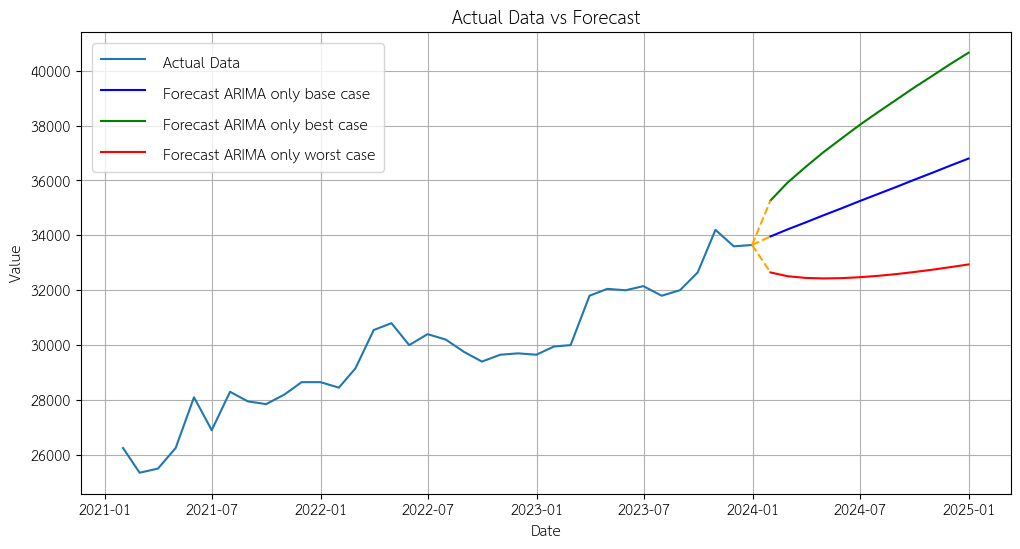

In [130]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'] , (Gold_Factor_data['GoldBar_Sale'].values) , label = 'Actual Data')
plt.plot(Date_forecast_period , (arima_only_predict), label='Forecast ARIMA only base case' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_predict.iloc[0])][0],
          color = 'orange',linestyle='--')
plt.plot(Date_forecast_period , arima_only_best_case, label='Forecast ARIMA only best case' , color = 'green')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_best_case[0])][0],
         color = 'orange',linestyle='--')
plt.plot(Date_forecast_period , arima_only_worst_case, label='Forecast ARIMA only worst case' , color = 'red')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_worst_case[0])][0], 
         color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

 Polynomial Regression model

In [131]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X = np.log(Gold_Factor_data['GoldBar_Sale'])
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

X_poly = poly_features.fit_transform(X)
model_poly = LinearRegression()
model_poly.fit(X_poly,y)
X_test_poly = poly_features.transform(X)
y_pred_poly = model_poly.predict(X_test_poly)
y_pred_poly_test = y_pred_poly

X_test_poly = poly_features.transform(output3_base[Factor_interested])
y_pred_poly = model_poly.predict(X_test_poly)
Predict_Poly = y_pred_poly
X_test_poly = poly_features.transform(output3_best[Factor_interested])
y_pred_poly = model_poly.predict(X_test_poly)
Predict_Poly_best = y_pred_poly
X_test_poly = poly_features.transform(output3_worst[Factor_interested])
y_pred_poly = model_poly.predict(X_test_poly)
Predict_Poly_worst = y_pred_poly

In [132]:
print(f"{Factor_interested[0]}:" ,model_poly.coef_[0][0])
print(f"{Factor_interested[1]}:" ,model_poly.coef_[0][1])
print(f"{Factor_interested[2]}" ,model_poly.coef_[0][2])
print(f"{Factor_interested[0]}**2 :" ,model_poly.coef_[0][3])
print(f"{Factor_interested[0]} {Factor_interested[1]}" ,model_poly.coef_[0][4])
print(f"{Factor_interested[0]} {Factor_interested[2]}" ,model_poly.coef_[0][5])
print(f"{Factor_interested[1]}**2 :" ,model_poly.coef_[0][6])
print(f"{Factor_interested[1]} {Factor_interested[2]}" ,model_poly.coef_[0][7])
print(f"{Factor_interested[2]}**2" ,model_poly.coef_[0][8])
print("Intercept : ", model_poly.intercept_[0])
print("R-Squared : " ,model_poly.score(X_poly,y))
print("MAE : ",metrics.mean_absolute_error(np.exp(y),np.exp(y_pred_poly_test)))
print("MAPE : ",metrics.mean_absolute_percentage_error(np.exp(y),np.exp(y_pred_poly_test)))
print("MSE : ",metrics.mean_squared_error(np.exp(y),np.exp(y_pred_poly_test)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(np.exp(y),np.exp(y_pred_poly_test))))

(Inflation): 6.183746440754838
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4: 26.223723360604055
LOG_CPI -57.51682305019379
(Inflation)**2 : 0.006384962890988888
(Inflation) %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4 0.007692331170282091
(Inflation) LOG_CPI -1.3352649160175005
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4**2 : -0.7790551874051714
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4 LOG_CPI -5.606137716041666
LOG_CPI**2 6.568164651310892
Intercept :  135.76734026071898
R-Squared :  0.9024312972305294
MAE :  576.5619844494913
MAPE :  0.01935817583349197
MSE :  491691.65222064673
RMSE :  701.207281922148


In [133]:
poly_features.get_params()

{'degree': 2, 'include_bias': False, 'interaction_only': False, 'order': 'C'}

In [134]:
poly_features.get_feature_names_out

<bound method PolynomialFeatures.get_feature_names_out of PolynomialFeatures(include_bias=False)>

In [135]:
# (Gold_Factor_data[Factor_interested[0]].iloc[0])
X_test_poly

array([[ 4.73083246e-01, -4.01817787e-02,  4.66831800e+00,
         2.23807758e-01, -1.90093263e-02,  2.20850303e+00,
         1.61457534e-03, -1.87581321e-01,  2.17931930e+01],
       [ 1.46703351e+00, -4.01817787e-02,  4.67031401e+00,
         2.15218731e+00, -5.89480157e-02,  6.85150715e+00,
         1.61457534e-03, -1.87661524e-01,  2.18118330e+01],
       [ 1.57849590e+00, -4.01817787e-02,  4.67231088e+00,
         2.49164930e+00, -6.34267729e-02,  7.37522356e+00,
         1.61457534e-03, -1.87741762e-01,  2.18304889e+01],
       [ 1.59809953e+00, -4.01817787e-02,  4.67430859e+00,
         2.55392210e+00, -6.42144816e-02,  7.47001036e+00,
         1.61457534e-03, -1.87822033e-01,  2.18491608e+01],
       [ 1.63004134e+00, -4.01817787e-02,  4.67630717e+00,
         2.65703478e+00, -6.54979605e-02,  7.62257401e+00,
         1.61457534e-03, -1.87902340e-01,  2.18678487e+01],
       [ 1.76913012e+00, -4.01817787e-02,  4.67830659e+00,
         3.12982138e+00, -7.10867949e-02,  8.276533

In [136]:
print(model_poly.coef_)

[[ 6.18374644e+00  2.62237234e+01 -5.75168231e+01  6.38496289e-03
   7.69233117e-03 -1.33526492e+00 -7.79055187e-01 -5.60613772e+00
   6.56816465e+00]]


In [137]:
Gold_Factor_data[Factor_interested[0]].iloc[0]
poly_features.get_feature_names_out([Factor_interested[0], Factor_interested[1], Factor_interested[2]])

array(['(Inflation)', '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4', 'LOG_CPI',
       '(Inflation)^2',
       '(Inflation) %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4',
       '(Inflation) LOG_CPI', '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4^2',
       '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4 LOG_CPI', 'LOG_CPI^2'],
      dtype=object)

In [138]:
Gold_Factor_data[Factor_interested[0]].iloc[0]

0.21

In [139]:
np.exp(model_poly.intercept_[0] + (Gold_Factor_data[Factor_interested[0]].iloc[0] * 6.18374644e+00) +\
    (Gold_Factor_data[Factor_interested[1]].iloc[0] * 2.62237234e+01) +\
    (Gold_Factor_data[Factor_interested[2]].iloc[0] * (-5.75168231e+01)) +\
    ((Gold_Factor_data[Factor_interested[0]].iloc[0]**2)*6.38496289e-03) +\
    (Gold_Factor_data[Factor_interested[0]].iloc[0]*Gold_Factor_data[Factor_interested[1]].iloc[0] * 7.69233117e-03) +\
    (Gold_Factor_data[Factor_interested[0]].iloc[0]*Gold_Factor_data[Factor_interested[2]].iloc[0] * (-1.3352649160175005)) +\
    ((Gold_Factor_data[Factor_interested[1]].iloc[0]**2)*(-7.79055187e-01)) +\
    (Gold_Factor_data[Factor_interested[1]].iloc[0] * Gold_Factor_data[Factor_interested[2]].iloc[0] * (-5.60613772e+00)) +\
    ((Gold_Factor_data[Factor_interested[2]].iloc[0]**2) * 6.56816465e+00))

25951.046298444777

In [591]:
test_w = pd.DataFrame()
test_w['Actual'] = Gold_Factor_data['GoldBar_Sale'].values
test_w['Pred'] = np.exp(y_pred_poly_test)
test_w['Diff'] = test_w['Actual'] - test_w['Pred']
test_w['MAE'] = sum(abs(test_w['Actual'] - test_w['Pred']))/36
print("MAE")
test_w


MAE


Actual          Pred         Diff         MAE
0    26250  25951.053003   298.946997  576.561984
1    25350  25497.975531  -147.975531  576.561984
2    25500  26354.616285  -854.616285  576.561984
3    26250  27554.974255 -1304.974255  576.561984
4    28100  27270.110970   829.889030  576.561984
5    26900  27577.117271  -677.117271  576.561984
6    28300  27096.110711  1203.889289  576.561984
7    27950  26723.356666  1226.643334  576.561984
8    27850  28288.774038  -438.774038  576.561984
9    28200  28583.329216  -383.329216  576.561984
10   28650  28727.713591   -77.713591  576.561984
11   28650  28478.576174   171.423826  576.561984
12   28450  29067.466995  -617.466995  576.561984
13   29150  29742.923882  -592.923882  576.561984
14   30550  29999.644524   550.355476  576.561984
15   30800  30269.325441   530.674559  576.561984
16   30000  30445.697550  -445.697550  576.561984
17   30400  30294.372968   105.627032  576.561984
18   30200  29894.788297   305.211703  576.561984
19   29750  29851.419137  -101.419137  576.561984
20   29400  29710.643135  -310.643135  576.561984
21   29650  29692.888801   -42.888801  576.561984
22   29700  29783.935565   -83.935565  576.561984
23   29650  29735.570608   -85.570608  576.561984
24   29950  29601.066472   348.933528  576.561984
25   30000  31107.823218 -1107.823218  576.561984
26   31800  31310.839309   489.160691  576.561984
27   32050  31554.278843   495.721157  576.561984
28   32000  31274.377608   725.622392  576.561984
29   32150  31994.842946   155.157054  576.561984
30   31800  32762.416468  -962.416468  576.561984
31   32000  33373.305885 -1373.305885  576.561984
32   32650  33270.550988  -620.550988  576.561984
33   34200  33018.733913  1181.266087  576.561984
34   33600  32908.663728   691.336272  576.561984
35   33650  32432.769403  1217.230597  576.561984

In [851]:
np.exp(Predict_Poly).mean() # MEAN

31220.438924942817

In [919]:
# np.exp(Predict_Poly)
# Gold_Factor_data['Report Date']
# Date_forecast_period
[(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),Predict_Poly[0][0])][0]

(33650.0, 10.386481426171585)

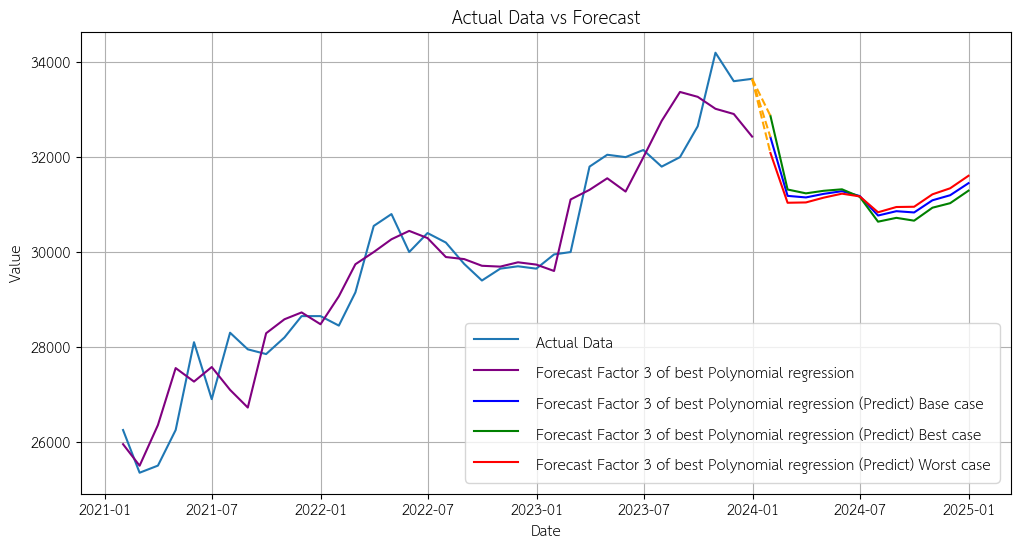

In [930]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Gold_Factor_data['Report Date'],np.exp(y_pred_poly_test), label='Forecast Factor 3 of best Polynomial regression' , color = 'purple')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression (Predict) Base case' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly[0][0]))][0], 
         color = 'orange',linestyle='--')
plt.plot(Date_forecast_period,np.exp(Predict_Poly_best), label='Forecast Factor 3 of best Polynomial regression (Predict) Best case' , color = 'green')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_best[0][0]))][0], 
         color = 'orange',linestyle='--')
plt.plot(Date_forecast_period,np.exp(Predict_Poly_worst), label='Forecast Factor 3 of best Polynomial regression (Predict) Worst case' , color = 'red')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_worst[0][0]))][0], 
         color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression # only

In [177]:
# linear and arima
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

model_linear = LinearRegression()
model_linear.fit(X,y)
y_pred_linear_test = model_linear.predict(X)
y_pred_linear = model_linear.predict(output3_base[Factor_interested])
print(np.exp(y_pred_linear))

[[32195.60008022]
 [31198.0296785 ]
 [31242.81287845]
 [31395.08937918]
 [31533.67302691]
 [31546.6520906 ]
 [31311.94752927]
 [31511.84034785]
 [31617.10301985]
 [31937.89983841]
 [32139.99308119]
 [32435.57976863]]


In [178]:
model_linear

LinearRegression()

In [180]:
print(f"{Factor_interested[0]} x1 :",model_linear.coef_[0][0])
print(f"{Factor_interested[1]} x2 :",model_linear.coef_[0][1])
print(f"{Factor_interested[2]} x3 :",model_linear.coef_[0][2])
print("intercept :",model_linear.intercept_)
print("R-squared :",model_linear.score(X,y))
n , p = X.shape
adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_linear)
print("MAE : ",metrics.mean_absolute_error(np.exp(y),np.exp(y_pred_linear_test)))
print("MAPE : ",metrics.mean_absolute_percentage_error(np.exp(y),np.exp(y_pred_linear_test)))
print("MSE : ",metrics.mean_squared_error(np.exp(y),np.exp(y_pred_linear_test)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(np.exp(y),np.exp(y_pred_linear_test))))


(Inflation) x1 : -0.03728871579460835
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4 x2 : 0.11141683953946213
LOG_CPI x3 : 2.7959848373847174
intercept : [-2.66135251]
R-squared : 0.8545589886864543
Adj-R-squared :  0.8409238938758095
MAE :  684.6244219068168
MAPE :  0.023085479778943603
MSE :  721698.6839544898
RMSE :  849.5285068521772


In [934]:
np.exp(y_pred_linear)

array([[32195.59555689],
       [31198.02146797],
       [31242.79926276],
       [31395.06953267],
       [31533.64619393],
       [31546.61768269],
       [31311.90528419],
       [31511.78838731],
       [31617.04061524],
       [31937.82531439],
       [32139.90576061],
       [32435.47825258]])

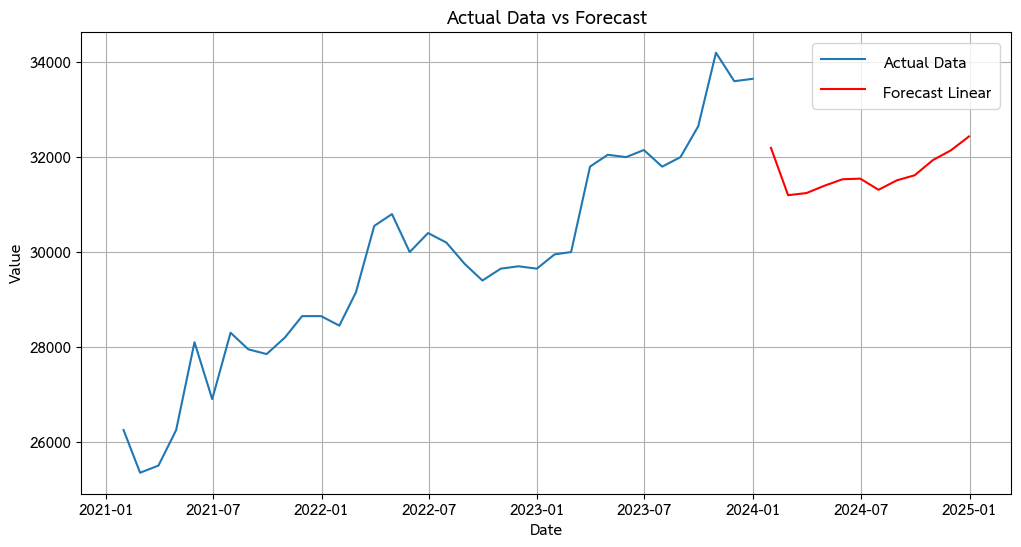

In [182]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Linear' , color = 'red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Elastic Net Model

In [467]:
#Elastic Net คือ การรวมระหว่าง Ridge Regression และ Lasso Regression เข้าด้วยกัน
from sklearn.linear_model import ElasticNet
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # l1_ratio เป็นการควบคุมการผสมระหว่าง L1 และ L2
elastic_net_model.fit(X, y)
y_pred_test_enet = elastic_net_model.predict(X)
print("x1 x2 x3 [Coeff] :",elastic_net_model.coef_)
print("Intercept : ",elastic_net_model.intercept_)
print("R-squared : ",elastic_net_model.score(X,y))
adj_r2_elastic_net = 1 - ( ((1 - elastic_net_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_elastic_net)
elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # l1_ratio เป็นการควบคุมการผสมระหว่าง L1 และ L2
elastic_net_model.fit(X, y)
y_pred_elastic_net = elastic_net_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_enet))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_enet))
print("MSE : ",metrics.mean_squared_error(y,y_pred_test_enet))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_enet)))

x1 x2 x3 [Coeff] : [-0.          0.          0.99076447]
Intercept :  [5.68896867]
R-squared :  0.5355072525287126
Adj-R-squared :  0.49196105745327934
MAE :  0.04034326184816347
MAPE :  0.003915027076048967
MSE :  0.0026432371293386653
RMSE :  0.05141242193613004


In [468]:
np.exp(y_pred_elastic_net)

array([30340.85144675, 30400.99115594, 30461.27586038, 30521.70596083,
       30582.28185928, 30643.00395895, 30703.87266431, 30764.8883811 ,
       30826.05151626, 30887.36247805, 30948.82167593, 31010.42952067])

Ridge Regression model

In [469]:
#Ridge Regression
from sklearn.linear_model import Ridge
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

ridge_model = Ridge(alpha=0.05)  # alpha คือค่า penalty
ridge_model.fit(X, y)
print("Coef of x1 , x2 , x3 : ",ridge_model.coef_)
print("Intercept : ",ridge_model.intercept_)
print("R-squared : ",ridge_model.score(X,y))
adj_r2_ridge = 1 - ( ((1 - ridge_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_ridge)
y_pred_ridge_test = ridge_model.predict(X)
y_pred_ridge = ridge_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_ridge_test))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_ridge_test))
print("MSE : ",metrics.mean_squared_error(y,y_pred_ridge_test))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_ridge_test)))

Coef of x1 , x2 , x3 :  [[0.00380536 0.01533569 0.79922876]]
Intercept :  [6.57467332]
R-squared :  0.464738451316688
Adj-R-squared :  0.4145576811276275
MAE :  0.043627229033766625
MAPE :  0.004233616823803344
MSE :  0.00304595326211095
RMSE :  0.05519015548185156


In [470]:
print(np.exp(y_pred_ridge))

[[30124.2123937 ]
 [30286.7083563 ]
 [30348.01617528]
 [30398.84093668]
 [30451.20131715]
 [30516.11262071]
 [30605.7905416 ]
 [30652.4639365 ]
 [30708.72740671]
 [30743.90533367]
 [30791.05102997]
 [30829.3391748 ]]


Lasso Regression model

In [471]:
from sklearn.linear_model import Lasso
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

lasso_model = Lasso(alpha=0.001)  # alpha คือค่า penalty
lasso_model.fit(X, y)
y_pred_test_lasso = lasso_model.predict(X)
print("Coef of x1 , x2 , x3 : ",lasso_model.coef_)
print("Intercept : ",lasso_model.intercept_)
print("R-squared : ",lasso_model.score(X,y))
adj_r2_lasso = 1 - ( ((1 - lasso_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_lasso)
y_pred_lasso = lasso_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_lasso))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_lasso))
print("MSE : ",metrics.mean_squared_error(y,y_pred_test_lasso))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_lasso)))

Coef of x1 , x2 , x3 :  [-0.          0.          0.98654774]
Intercept :  [5.7085858]
R-squared :  0.5340286741766568
Adj-R-squared :  0.49034386238071836
MAE :  0.04039628319598333
MAPE :  0.003920198634061935
MSE :  0.002651651110439698
RMSE :  0.051494185209979754


In [472]:
np.exp(y_pred_lasso)

array([30338.00678908, 30397.88467477, 30457.9064185 , 30518.07241664,
       30578.38306676, 30638.83876765, 30699.43991934, 30760.18692309,
       30821.08018137, 30882.12009791, 30943.30707768, 31004.6415269 ])

In [473]:
# #SVR Support Vector Regression
# from sklearn.svm import SVR
# X = Gold_Factor_data[Factor_interested]
# y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

# svr_model = SVR(kernel='linear')  # สามารถเลือก kernel ที่แตกต่างกันได้
# svr_model.fit(X, y)
# print("x1 x2 x3 [Coef] :",svr_model.coef_)
# print("Intercept : ",svr_model.intercept_)
# print("R-squared : ",svr_model.score(X,y))
# y_pred_svr_test = svr_model.predict(X)
# y_pred_svr = svr_model.predict(output3_base[Factor_interested])

In [474]:
# print(np.exp(y_pred_svr))

#Show All output

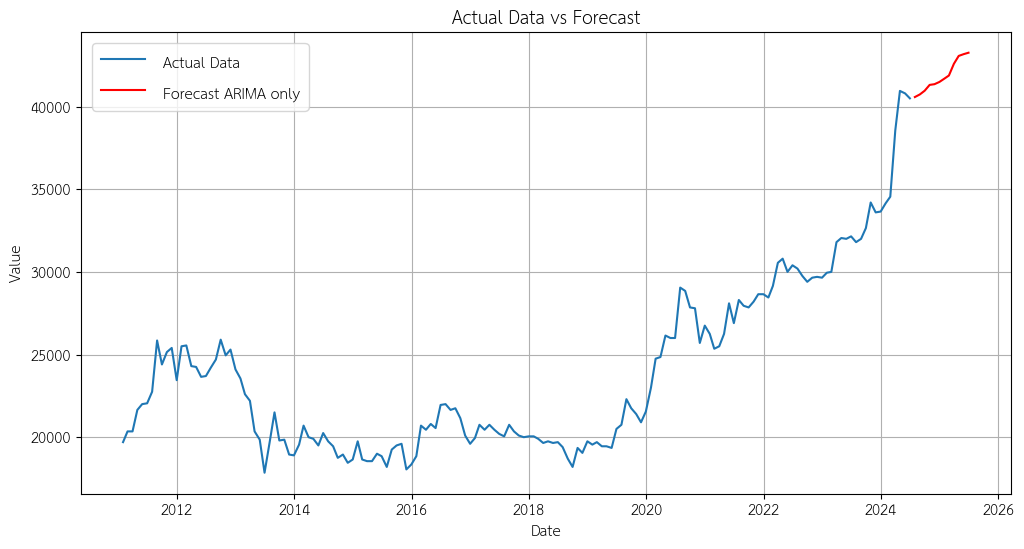

In [475]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [476]:
arima_only_predict

162    40578.481732
163    40736.651818
164    40960.021466
165    41313.790237
166    41356.049991
167    41492.486889
168    41694.123350
169    41881.271018
170    42590.015182
171    43066.938681
172    43174.397997
173    43260.124125
dtype: float64

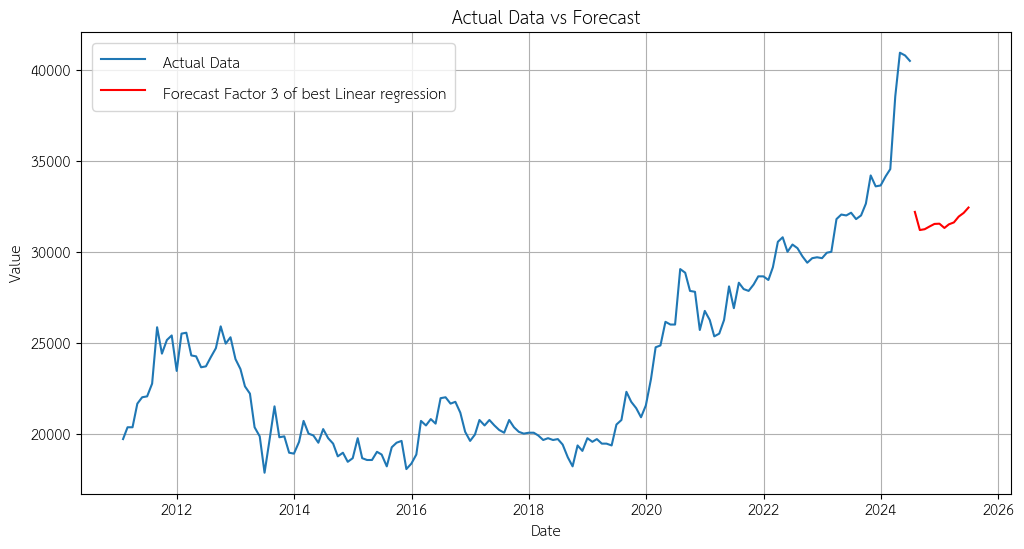

In [477]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [480]:
np.exp(y_pred_linear)

array([[32195.59555689],
       [31198.02146797],
       [31242.79926276],
       [31395.06953267],
       [31533.64619393],
       [31546.61768269],
       [31311.90528419],
       [31511.78838731],
       [31617.04061524],
       [31937.82531439],
       [32139.90576061],
       [32435.47825258]])

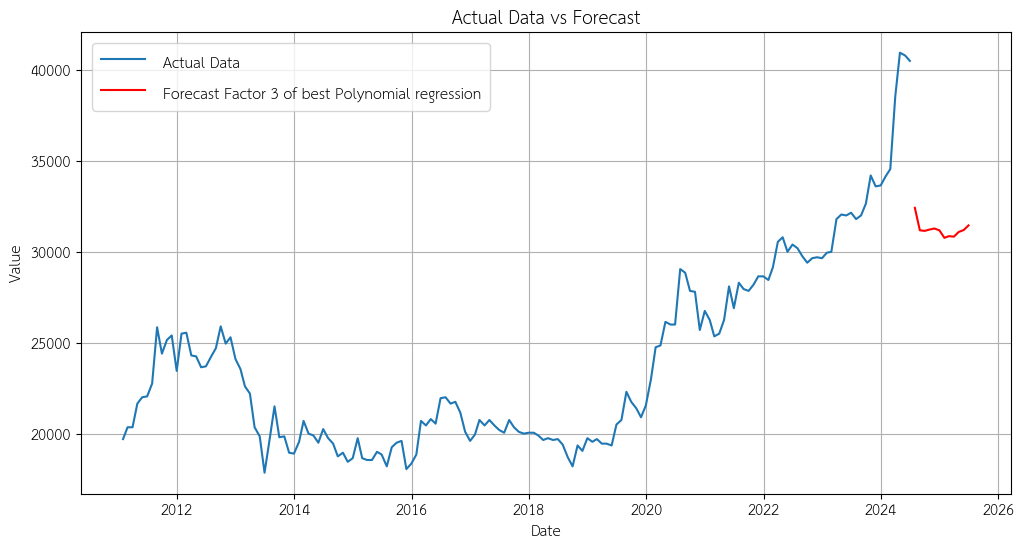

In [481]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [482]:
np.exp(Predict_Poly)

array([[32418.3994927 ],
       [31183.8199117 ],
       [31150.74220036],
       [31225.79969537],
       [31282.28728854],
       [31180.38834856],
       [30769.58213897],
       [30860.893958  ],
       [30834.0651881 ],
       [31090.60469646],
       [31197.37974803],
       [31451.30443252]])

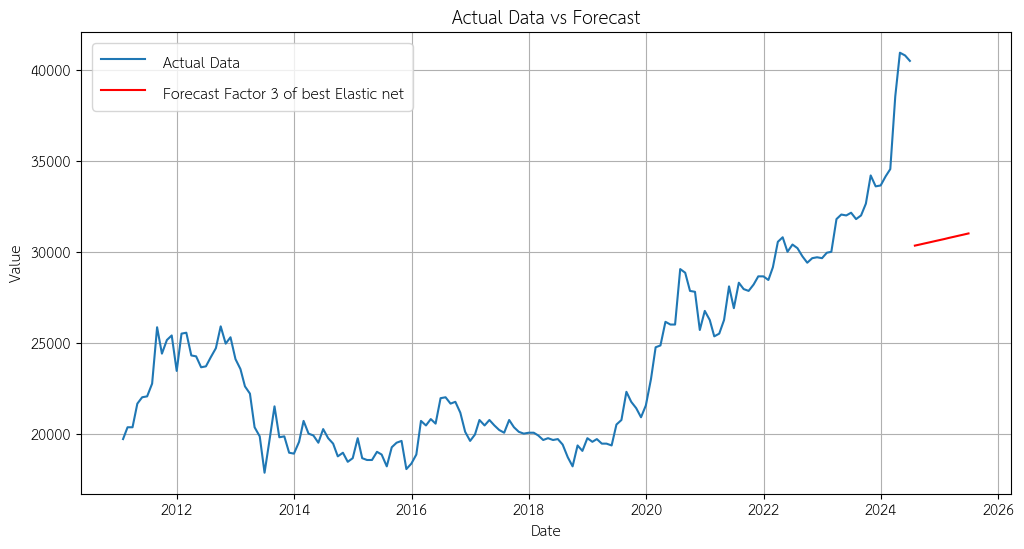

In [483]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [484]:
np.exp(y_pred_elastic_net)

array([30340.85144675, 30400.99115594, 30461.27586038, 30521.70596083,
       30582.28185928, 30643.00395895, 30703.87266431, 30764.8883811 ,
       30826.05151626, 30887.36247805, 30948.82167593, 31010.42952067])

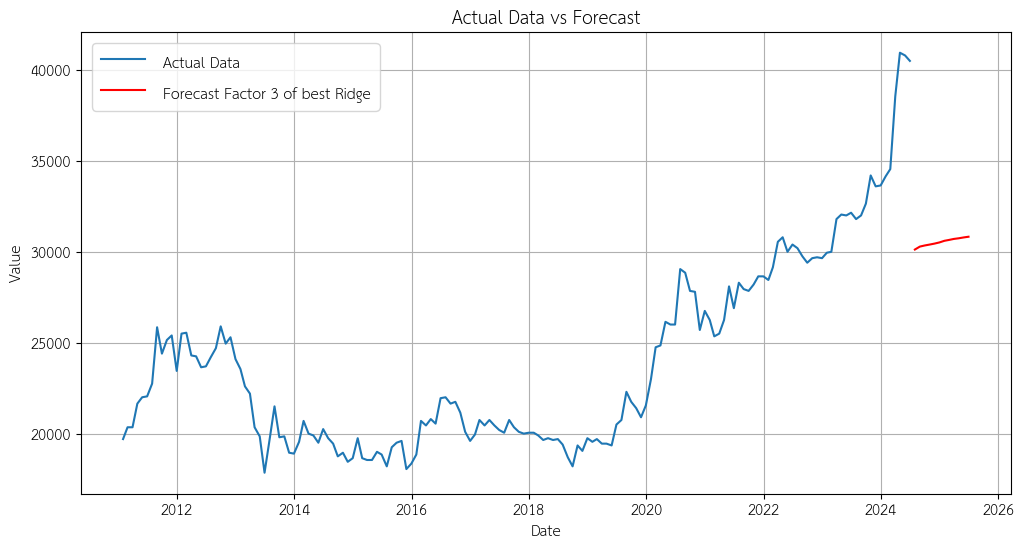

In [485]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [486]:
np.exp(y_pred_ridge)

array([[30124.2123937 ],
       [30286.7083563 ],
       [30348.01617528],
       [30398.84093668],
       [30451.20131715],
       [30516.11262071],
       [30605.7905416 ],
       [30652.4639365 ],
       [30708.72740671],
       [30743.90533367],
       [30791.05102997],
       [30829.3391748 ]])

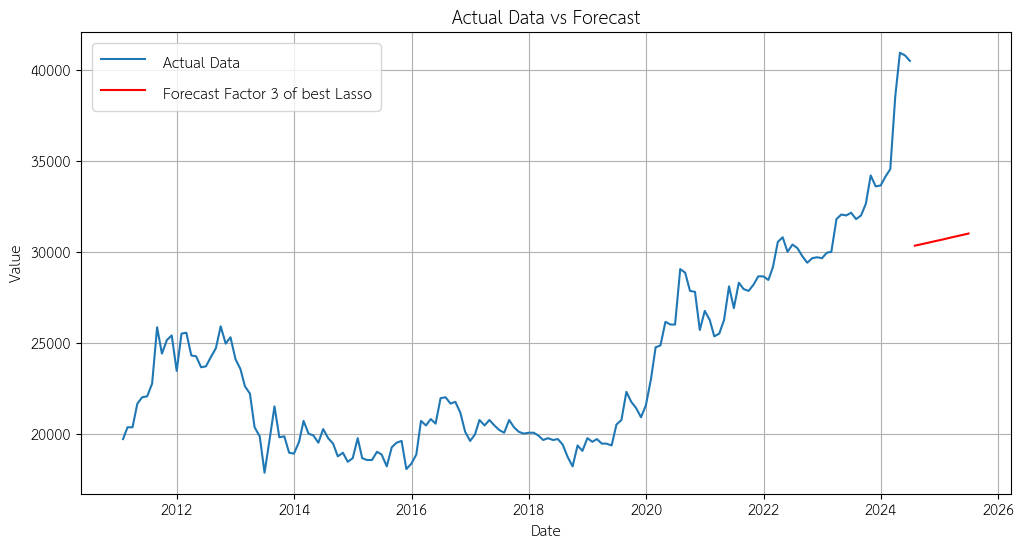

In [487]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [488]:
np.exp(y_pred_lasso)

array([30338.00678908, 30397.88467477, 30457.9064185 , 30518.07241664,
       30578.38306676, 30638.83876765, 30699.43991934, 30760.18692309,
       30821.08018137, 30882.12009791, 30943.30707768, 31004.6415269 ])

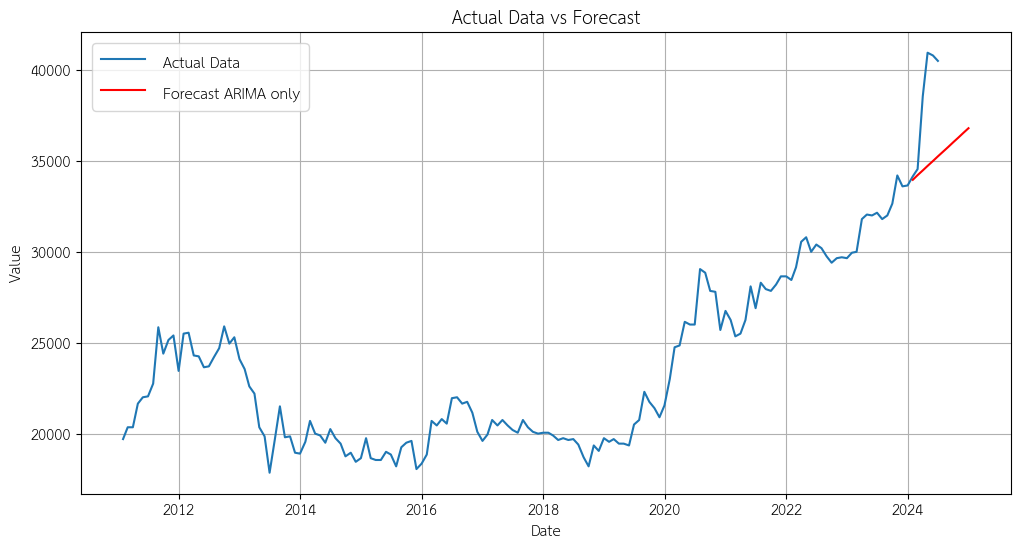

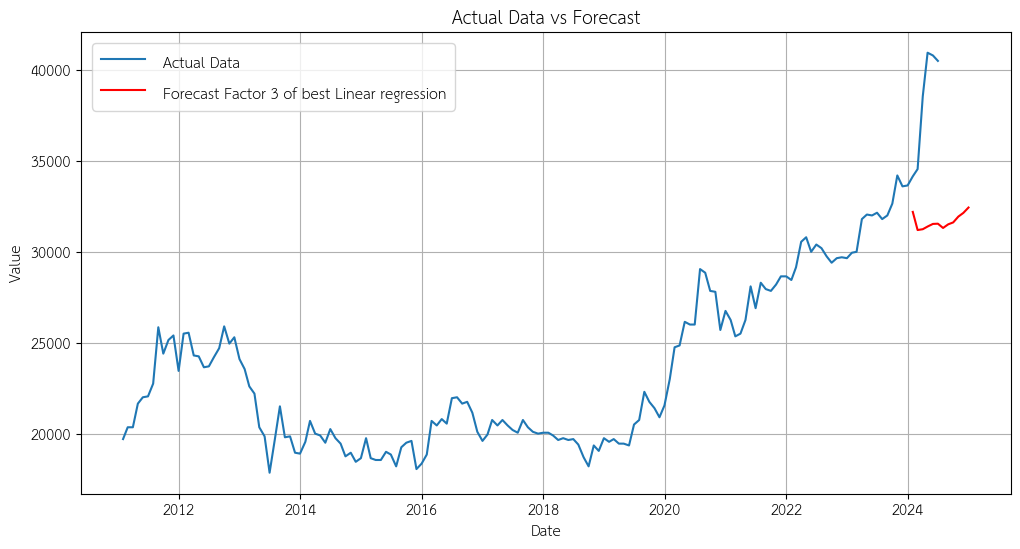

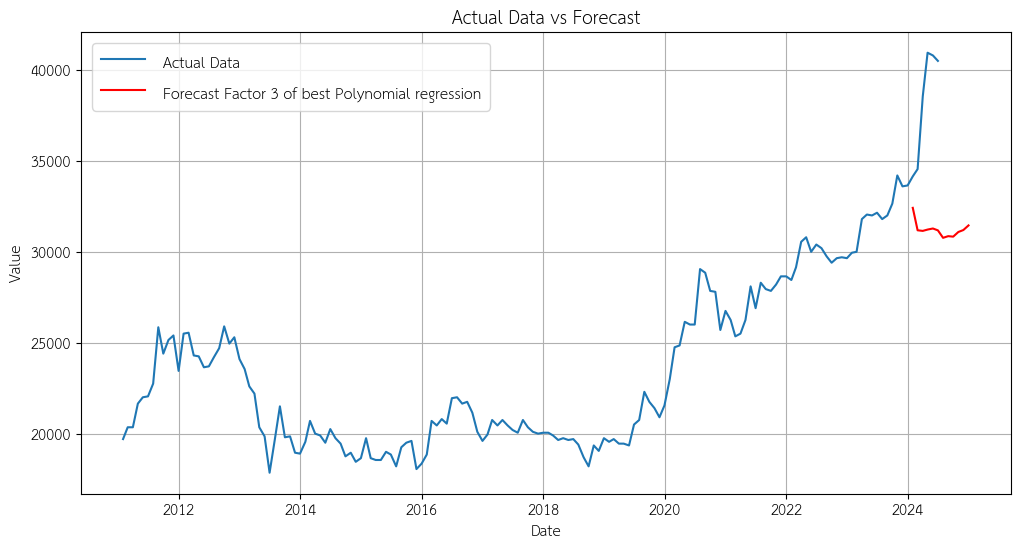

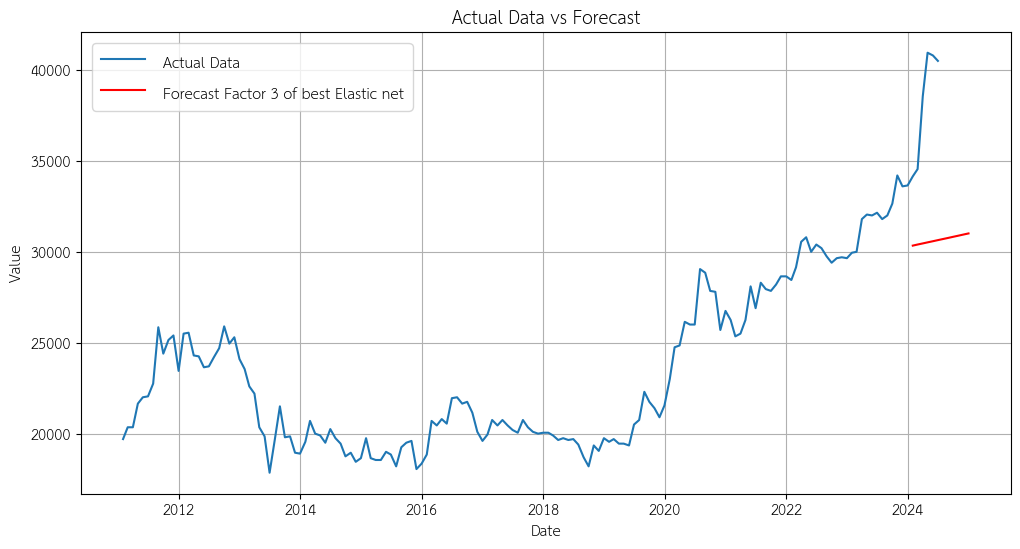

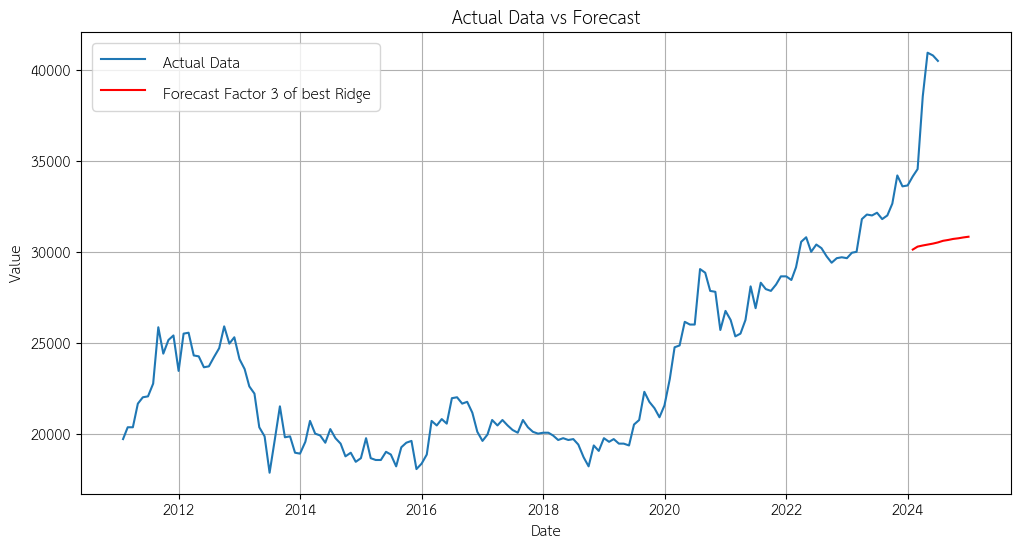

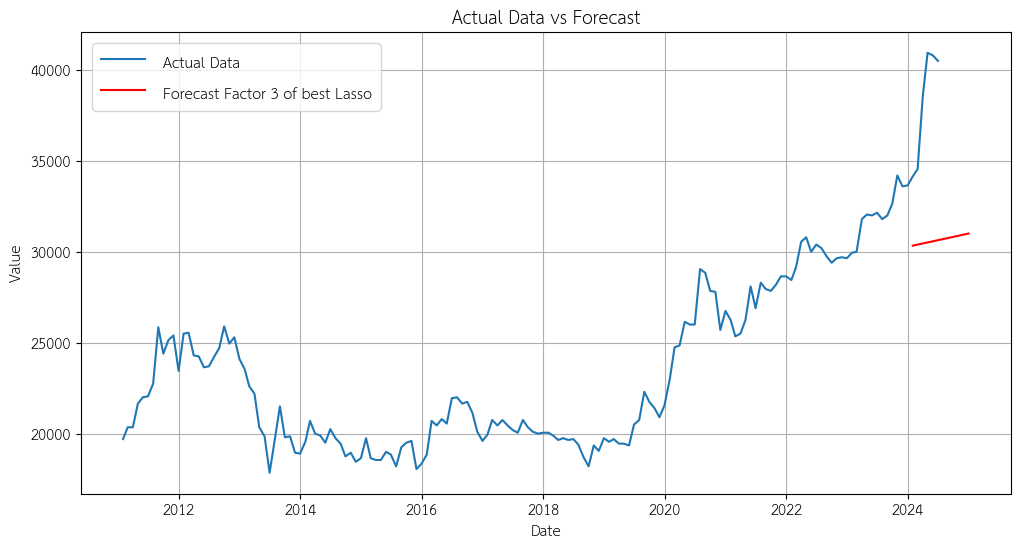

In [785]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

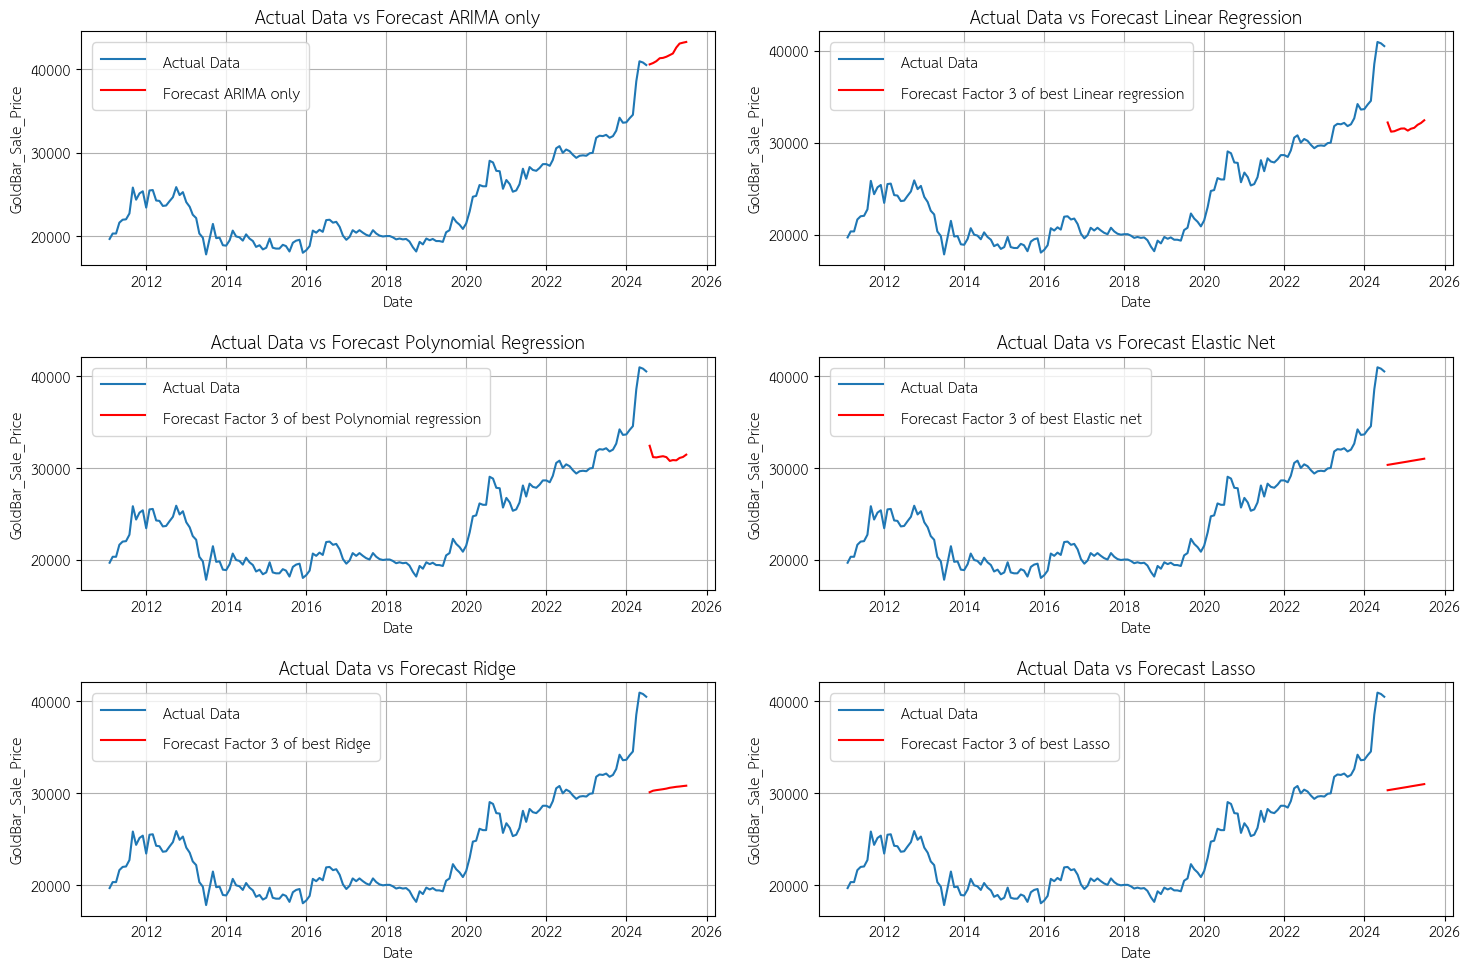

In [490]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # สร้างพื้นที่สำหรับ subplot 3 แถว 2 คอลัมน์
y_tag_label = 'GoldBar_Sale_Price'
# กราฟที่ 1: ARIMA
axs[0, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[0, 0].plot(Date_forecast_period, arima_only_predict, label='Forecast ARIMA only', color='red')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel(y_tag_label)
axs[0, 0].set_title('Actual Data vs Forecast ARIMA only')
axs[0, 0].legend()
axs[0, 0].grid(True)

# กราฟที่ 2: Linear Regression
axs[0, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[0, 1].plot(Date_forecast_period, np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression', color='red')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel(y_tag_label)
axs[0, 1].set_title('Actual Data vs Forecast Linear Regression')
axs[0, 1].legend()
axs[0, 1].grid(True)

# กราฟที่ 3: Polynomial Regression
axs[1, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[1, 0].plot(Date_forecast_period, np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression', color='red')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel(y_tag_label)
axs[1, 0].set_title('Actual Data vs Forecast Polynomial Regression')
axs[1, 0].legend()
axs[1, 0].grid(True)

# กราฟที่ 4: Elastic Net
axs[1, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[1, 1].plot(Date_forecast_period, np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net', color='red')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel(y_tag_label)
axs[1, 1].set_title('Actual Data vs Forecast Elastic Net')
axs[1, 1].legend()
axs[1, 1].grid(True)

# กราฟที่ 5: Ridge
axs[2, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[2, 0].plot(Date_forecast_period, np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge', color='red')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel(y_tag_label)
axs[2, 0].set_title('Actual Data vs Forecast Ridge')
axs[2, 0].legend()
axs[2, 0].grid(True)

# กราฟที่ 6: Lasso
axs[2, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[2, 1].plot(Date_forecast_period, np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso', color='red')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel(y_tag_label)
axs[2, 1].set_title('Actual Data vs Forecast Lasso')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


In [782]:
# import pmdarima as pm
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # ข้อมูลตัวอย่าง (ใช้ข้อมูลจริงแทน)
# data = pd.Series([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140])

# # สร้างโมเดล ARIMA ด้วย pmdarima
# model = pm.auto_arima(data, seasonal=False, stepwise=True, trace=True)

# # ทำนายค่าในอนาคต (เช่น 10 periods)
# n_periods = 10
# forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)  # alpha=0.05 สำหรับ 95% confidence interval

# # คำนวณเปอร์เซ็นไทล์
# percentile_10 = np.percentile(conf_int, 10, axis=1)
# percentile_90 = np.percentile(conf_int, 90, axis=1)

# # กำหนด base case, best case, และ worst case
# base_case = forecast
# best_case = percentile_90  # 90th percentile สำหรับกรณีที่ดีที่สุด
# worst_case = percentile_10  # 10th percentile สำหรับกรณีที่เลวร้ายที่สุด

# # สร้างลำดับเวลา (time index) สำหรับการทำนาย
# index_of_fc = np.arange(len(data), len(data) + n_periods)

# # เพิ่มจุดข้อมูลสุดท้ายของข้อมูลจริงลงในกราฟการทำนายเพื่อให้กราฟต่อเนื่อง
# last_data_point = data.iloc[-1]
# extended_data = np.append(data.values, [last_data_point])
# extended_base_case = np.append([last_data_point], base_case)
# extended_best_case = np.append([last_data_point], best_case)
# extended_worst_case = np.append([last_data_point], worst_case)

# # แสดงผลการทำนาย
# plt.figure(figsize=(12,6))
# plt.plot(data, label='Historical Data')
# plt.plot(np.arange(len(data), len(data) + n_periods), base_case, label='Base Case', color='blue')
# plt.fill_between(np.arange(len(data), len(data) + n_periods), worst_case, best_case, color='pink', alpha=0.3, label='Percentile Interval')
# plt.plot(np.append(len(data)-1, np.arange(len(data), len(data) + n_periods)), np.append(data.iloc[-1], base_case), label='Base Case Continuation', color='blue', linestyle='--')
# plt.legend()
# plt.title('ARIMA Forecast with Base, Best, and Worst Case Scenarios (Percentile)')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.show()
